## Import Driver

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import neccesary libraries

In [2]:
import os
import pickle
import random
import scipy.io
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50

## Download images data and extract it

In [3]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar

--2024-08-11 15:04:29--  http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1345040896 (1.3G) [application/x-tar]
Saving to: ‘VOCtrainval_03-May-2010.tar’

VOCtrainval_03-May- 100%[===================>]   1.25G  28.7MB/s    in 47s     

2024-08-11 15:05:16 (27.1 MB/s) - ‘VOCtrainval_03-May-2010.tar’ saved [1345040896/1345040896]



In [4]:
import tarfile

tar_file_path = 'VOCtrainval_03-May-2010.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

## Download mask data and extract it

In [5]:
# download mask images
!wget https://cs.stanford.edu/~roozbeh/pascal-context/trainval.tar.gz
!tar -xvzf trainval.tar.gz

Streaming output truncated to the last 5000 lines.
trainval/2009_002851.mat
trainval/2008_004670.mat
trainval/2010_002678.mat
trainval/2009_003234.mat
trainval/2008_001649.mat
trainval/2010_001544.mat
trainval/2009_003067.mat
trainval/2008_004983.mat
trainval/2008_005414.mat
trainval/2009_002808.mat
trainval/2008_000190.mat
trainval/2009_002431.mat
trainval/2008_006956.mat
trainval/2008_004756.mat
trainval/2010_004345.mat
trainval/2010_005480.mat
trainval/2010_003771.mat
trainval/2010_004698.mat
trainval/2009_004648.mat
trainval/2008_005699.mat
trainval/2010_000588.mat
trainval/2010_000401.mat
trainval/2010_000285.mat
trainval/2010_002513.mat
trainval/2008_000078.mat
trainval/2008_005945.mat
trainval/2010_001671.mat
trainval/2009_001664.mat
trainval/2010_004259.mat
trainval/2009_003466.mat
trainval/2009_003982.mat
trainval/2010_002708.mat
trainval/2008_004934.mat
trainval/2008_002700.mat
trainval/2010_001608.mat
trainval/2008_006815.mat
trainval/2008_007521.mat
trainval/2009_003224.mat

## Set root directory for images and masks

In [10]:
# Images and mask directory
image_dir = 'VOCdevkit/VOC2010/JPEGImages/'
mask_dir = 'trainval/'

## Read images and Mask paths

In [11]:
# Get the list of images and masks
mask_paths = sorted([fname for fname in os.listdir(mask_dir) if fname.endswith('.mat')])
image_paths = sorted([fname.replace('.mat', '.jpg') for fname in os.listdir(mask_dir) if os.path.exists(os.path.join(image_dir, fname.replace('.mat', '.jpg')))])

# Check if the number of images matches the number of masks
assert len(image_paths) == len(mask_paths), "The number of images and masks should be the same."

paired_image_paths = [os.path.join(image_dir, fname) for fname in image_paths]
paired_mask_paths = [os.path.join(mask_dir, fname) for fname in mask_paths]

## Preproccessing images and masks

In [3]:
# Load .mat file and extract label map
def load_mat_file(mat_file_path):
    mat = scipy.io.loadmat(mat_file_path)
    label_map = mat['LabelMap']
    return label_map

# Load image from file path
def load_image(image_path):
    image = load_img(image_path)
    return img_to_array(image)

# Resize image and mask
def resize_image_and_mask(image, mask, target_size):
    # Resize image
    image = Image.fromarray(image.astype('uint8')).resize(target_size, Image.BILINEAR)
    image = np.array(image)

    # Resize mask using nearest neighbor interpolation
    mask = Image.fromarray(mask.astype('uint16')).resize(target_size, Image.NEAREST)
    mask = np.array(mask)

    return image, mask

## One-hot encode masks

In [4]:
# One-hot encode the label map
def one_hot_encode(label_map, num_classes):
    one_hot = np.zeros((label_map.shape[0], label_map.shape[1], num_classes), dtype=np.uint8)
    for c in range(num_classes):
        one_hot[:, :, c] = (label_map == c).astype(np.uint8)
    return one_hot

## Data generator using image and mask paths

In [5]:
# Data generator using paired paths
def data_generator(paired_image_paths, paired_mask_paths, batch_size, num_classes, target_size):
    while True:
        for i in range(0, len(paired_image_paths), batch_size):
            batch_images_paths = paired_image_paths[i:i+batch_size]
            batch_masks_paths = paired_mask_paths[i:i+batch_size]

            images = []
            masks = []

            for img_path, mask_path in zip(batch_images_paths, batch_masks_paths):
                image = load_image(img_path)
                label_map = load_mat_file(mask_path)

                # Resize image and mask
                image, label_map = resize_image_and_mask(image, label_map, target_size)

                mask = one_hot_encode(label_map, num_classes)

                images.append(image)
                masks.append(mask)

            yield np.array(images), np.array(masks)

## Function for display some sample of image and mask side by side

In [6]:
# Display samples function
def display_samples(image_paths, mask_paths, num_samples=10, target_size=(256, 256), num_classes=459):
    sample_indices = np.random.choice(len(image_paths), num_samples, replace=False)

    plt.figure(figsize=(20, num_samples * 5))

    for i, idx in enumerate(sample_indices):
        img_path = image_paths[idx]
        mask_path = mask_paths[idx]

        image = load_image(img_path)
        label_map = load_mat_file(mask_path)

        # Resize image and mask
        image, label_map = resize_image_and_mask(image, label_map, target_size)

        mask = one_hot_encode(label_map, num_classes)
        mask_rgb = np.argmax(mask, axis=-1)

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image.astype(np.uint8))
        plt.title("Image")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask_rgb, cmap='jet', alpha=0.5)
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Select half of dataset randomly

In [12]:
# Combine the image and mask paths into a list of tuples
paired_paths = list(zip(paired_image_paths, paired_mask_paths))

# Shuffle the combined list to randomize the selection
random.shuffle(paired_paths)

# Split the list in half
half_index = len(paired_paths) // 2
selected_pairs = paired_paths[:half_index]

# Unzip the selected pairs back into separate lists
selected_image_paths, selected_mask_paths = zip(*selected_pairs)

# Convert back to lists (zip returns tuples)
selected_image_paths = list(selected_image_paths)
selected_mask_paths = list(selected_mask_paths)

paired_image_paths = selected_image_paths
paired_mask_paths = selected_mask_paths

## Split dataset for train, validation and test with 70, 20, 10%

In [13]:
# Split into training (70%) and temp (30%)
train_image_paths, temp_image_paths, train_mask_paths, temp_mask_paths = train_test_split(
    paired_image_paths, paired_mask_paths, test_size=0.3, random_state=42)

# Split temp into validation (2/3 of 30% -> 20% of total) and test (1/3 of 30% -> 10% of total)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    temp_image_paths, temp_mask_paths, test_size=0.33, random_state=42)

# Check the lengths
print(f"Training set size: {len(train_image_paths)}")
print(f"Validation set size: {len(val_image_paths)}")
print(f"Test set size: {len(test_image_paths)}")

Training set size: 3535
Validation set size: 1015
Test set size: 501


## Pickle link

You can access to the model: [Link](https://drive.google.com/file/d/1RpzrxNN5FkTmjmz-vH_WNYnDpTr7hssQ/view?usp=sharing)

## Load paths to use from method 1

In [14]:
# Load the variables from the file
with open('drive/MyDrive/UNET/paired_paths.pkl', 'rb') as f:
    train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths = pickle.load(f)

print("Train image paths:", len(train_image_paths))
print("Train mask paths:", len(train_mask_paths))
print("Val image paths:", len(val_image_paths))
print("Val mask paths:", len(val_mask_paths))
print("Test image paths:", len(test_image_paths))
print("Test mask paths:", len(test_mask_paths))

Train image paths: 3535
Train mask paths: 3535
Val image paths: 1015
Val mask paths: 1015
Test image paths: 501
Test mask paths: 501


## Create data generator

In [15]:
# Create data generators
batch_size = 32
target_size = (128, 128)
num_classes = 459

train_gen = data_generator(train_image_paths, train_mask_paths, batch_size, num_classes, target_size)
val_gen = data_generator(val_image_paths, val_mask_paths, batch_size, num_classes, target_size)
test_gen = data_generator(test_image_paths, test_mask_paths, batch_size, num_classes, target_size)

## Display 10 samples of dataset

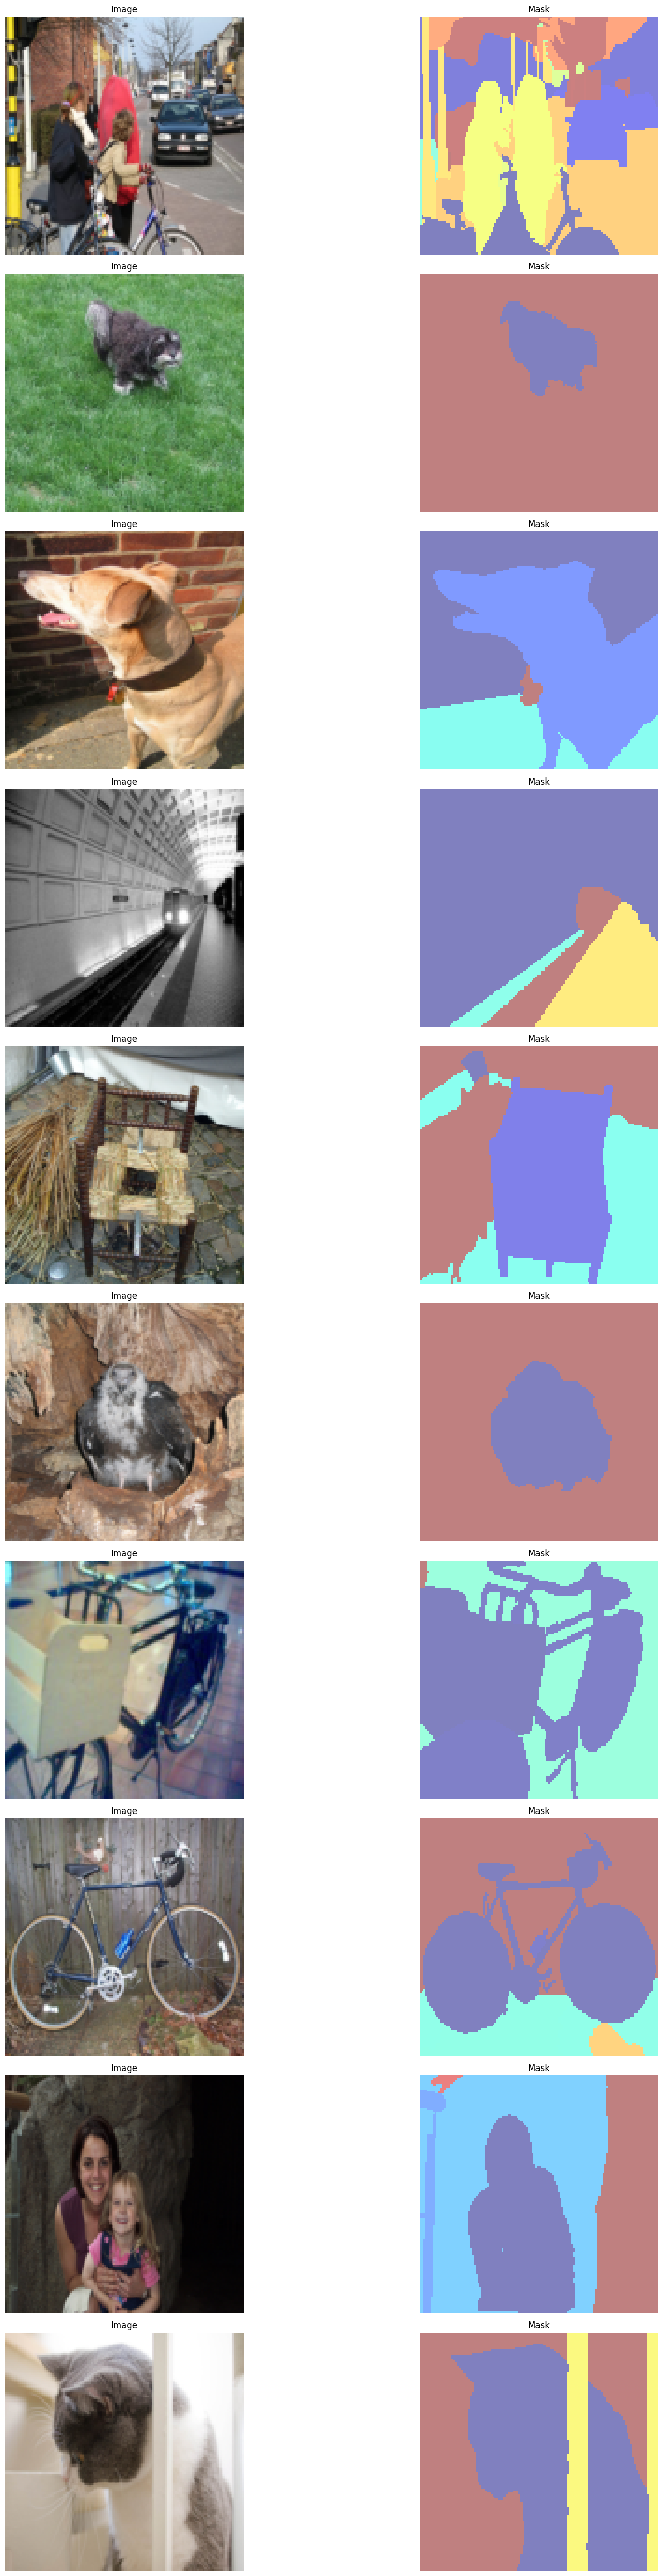

In [16]:
# Display samples
display_samples(paired_image_paths, paired_mask_paths, num_samples=10, target_size=target_size, num_classes=num_classes)

## Fetch one batch to check

In [17]:
# Fetch one batch to check
images, masks = next(train_gen)
print(images.shape)  # Should be (batch_size, target_height, target_width, 3)
print(masks.shape)   # Should be (batch_size, target_height, target_width, num_classes)

(32, 128, 128, 3)
(32, 128, 128, 459)


## Define U-Net model with ResNet50 encoder

In [18]:
# Define U-Net model with ResNet50 encoder
def unet_model(input_size=(128, 128, 3), num_classes=459):
    inputs = Input(input_size)

    # Encoder using ResNet50
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    # Extracting specific layers from ResNet50 as encoder layers
    c1 = resnet50.get_layer("conv1_relu").output  # Output after conv1 (64x64)
    c2 = resnet50.get_layer("conv2_block3_out").output  # Output after conv2 (32x32)
    c3 = resnet50.get_layer("conv3_block4_out").output  # Output after conv3 (16x16)
    c4 = resnet50.get_layer("conv4_block6_out").output  # Output after conv4 (8x8)

    # Bottleneck
    c5 = resnet50.get_layer("conv5_block3_out").output  # Output after conv5 (4x4)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)  # 4x4 -> 8x8
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)  # 8x8 -> 16x16
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)  # 16x16 -> 32x32
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)  # 32x32 -> 64x64
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Add one more upsampling layer to reach the desired output size
    u10 = UpSampling2D((2, 2))(c9)  # 64x64 -> 128x128
    c10 = Conv2D(64, (3, 3), activation='relu', padding='same')(u10)

    # Ensure the output layer has the correct shape
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c10)

    model = Model(inputs, outputs)
    return model


# Initialize U-Net model with ResNet50 encoder
model = unet_model(input_size=(target_size[0], target_size[1], 3), num_classes=num_classes)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 44,005,323 (167.87 MB)

 Trainable params: 43,952,203 (167.66 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Define checkpoint callback

In [19]:
# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    'unet_model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras',  # File name to save the model
    monitor='val_loss',       # Monitor the validation loss
    verbose=1,                # Verbosity mode, 1 to show messages
    save_best_only=False,     # Save all models, not just the best one
    mode='auto'               # Mode for monitoring the metric
)

In [20]:
# Define the custom callback to evaluate on test data
class TestCallback(Callback):
    def __init__(self, test_gen, num_test_samples, target_size, num_classes):
        self.test_gen = test_gen
        self.num_test_samples = num_test_samples
        self.target_size = target_size
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEvaluating on test data at the end of epoch {epoch + 1}")
        test_images, test_masks = next(self.test_gen)
        predicted_masks = self.model.predict(test_images)

        plt.figure(figsize=(20, 5 * self.num_test_samples))
        for i in range(self.num_test_samples):
            plt.subplot(self.num_test_samples, 3, 3*i + 1)
            plt.imshow(test_images[i].astype(np.uint8))
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(self.num_test_samples, 3, 3*i + 2)
            true_mask_rgb = np.argmax(test_masks[i], axis=-1)
            plt.imshow(true_mask_rgb, cmap='jet', alpha=0.5)
            plt.title("True Mask")
            plt.axis('off')

            plt.subplot(self.num_test_samples, 3, 3*i + 3)
            predicted_mask_rgb = np.argmax(predicted_masks[i], axis=-1)
            plt.imshow(predicted_mask_rgb, cmap='jet', alpha=0.5)
            plt.title("Predicted Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Define the custom callback
num_test_samples = 3  # Number of test samples to display
test_callback = TestCallback(test_gen, num_test_samples, target_size, num_classes)

## Train the model

Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1235 - loss: 4.5076
Epoch 1: saving model to unet_model_epoch_01_val_loss_25.7373.keras

Evaluating on test data at the end of epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


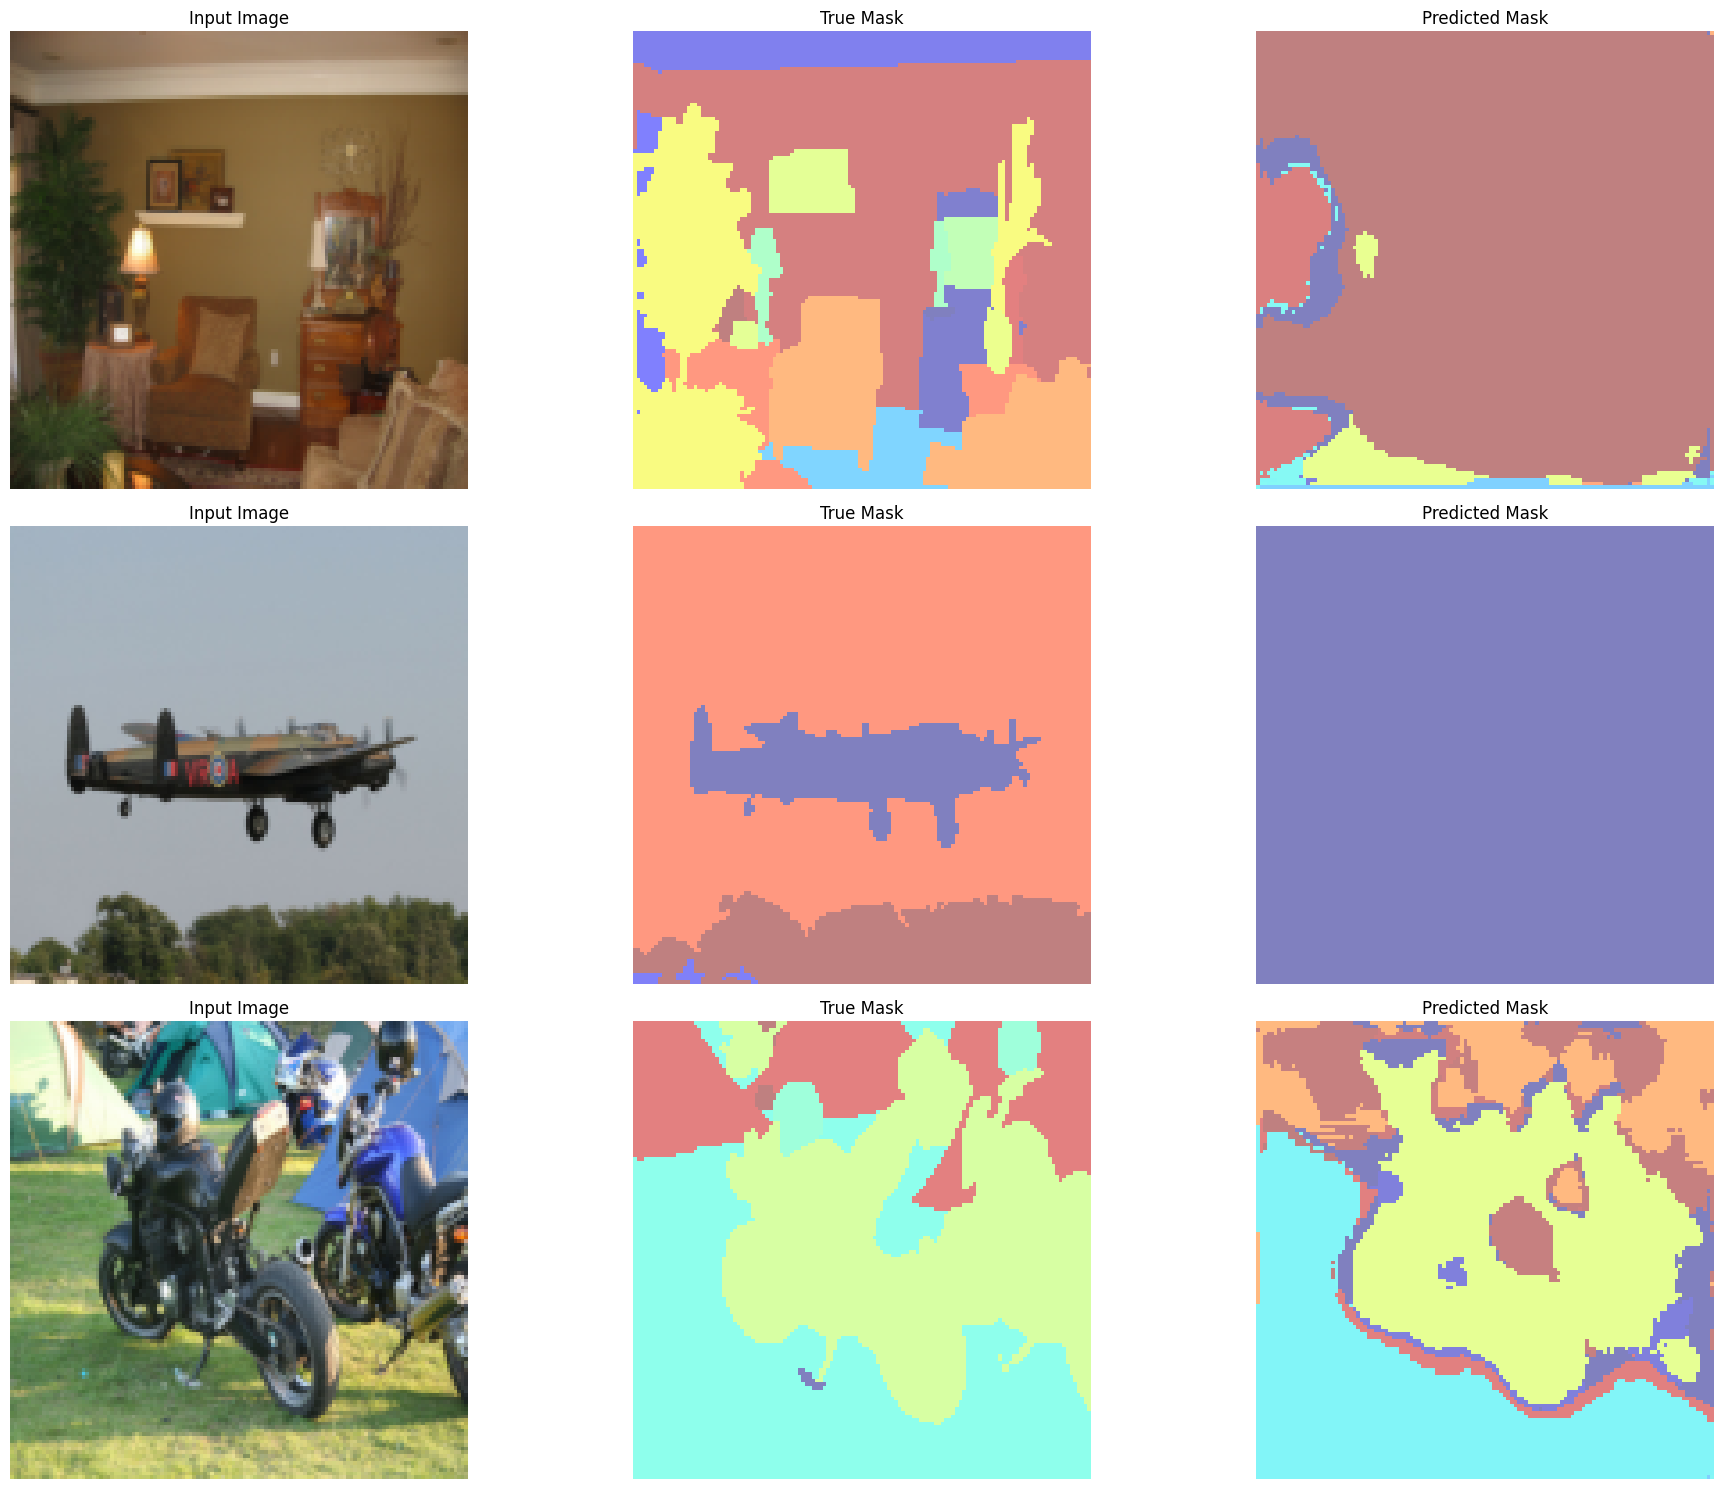

110/110 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.1240 - loss: 4.5011 - val_accuracy: 0.1543 - val_loss: 25.7373
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2849 - loss: 3.1222
Epoch 2: saving model to unet_model_epoch_02_val_loss_15.7713.keras

Evaluating on test data at the end of epoch 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


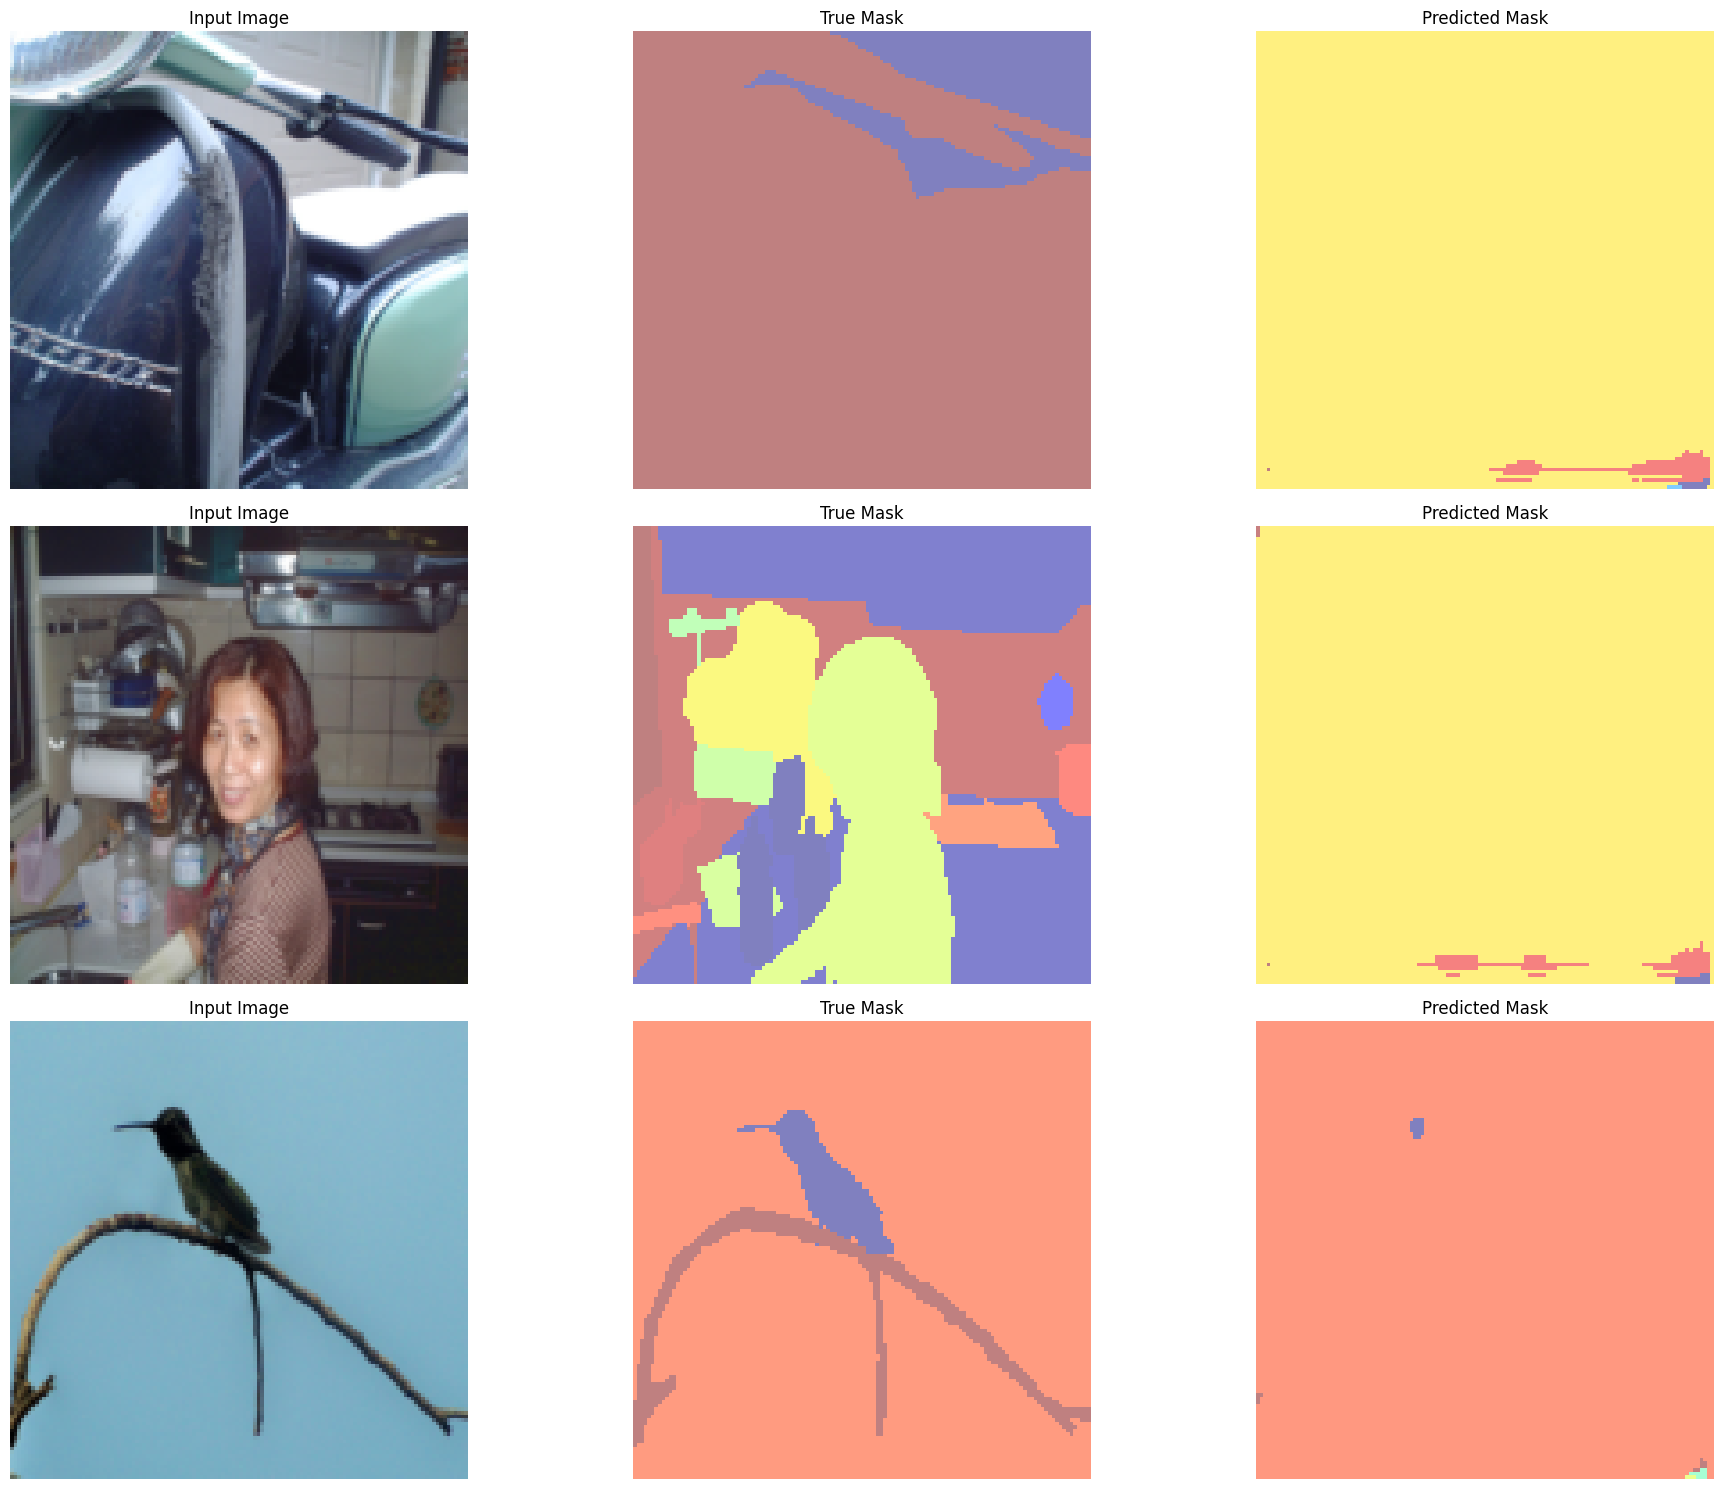

110/110 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.2850 - loss: 3.1217 - val_accuracy: 0.1131 - val_loss: 15.7713
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3195 - loss: 2.9001
Epoch 3: saving model to unet_model_epoch_03_val_loss_3.2214.keras

Evaluating on test data at the end of epoch 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


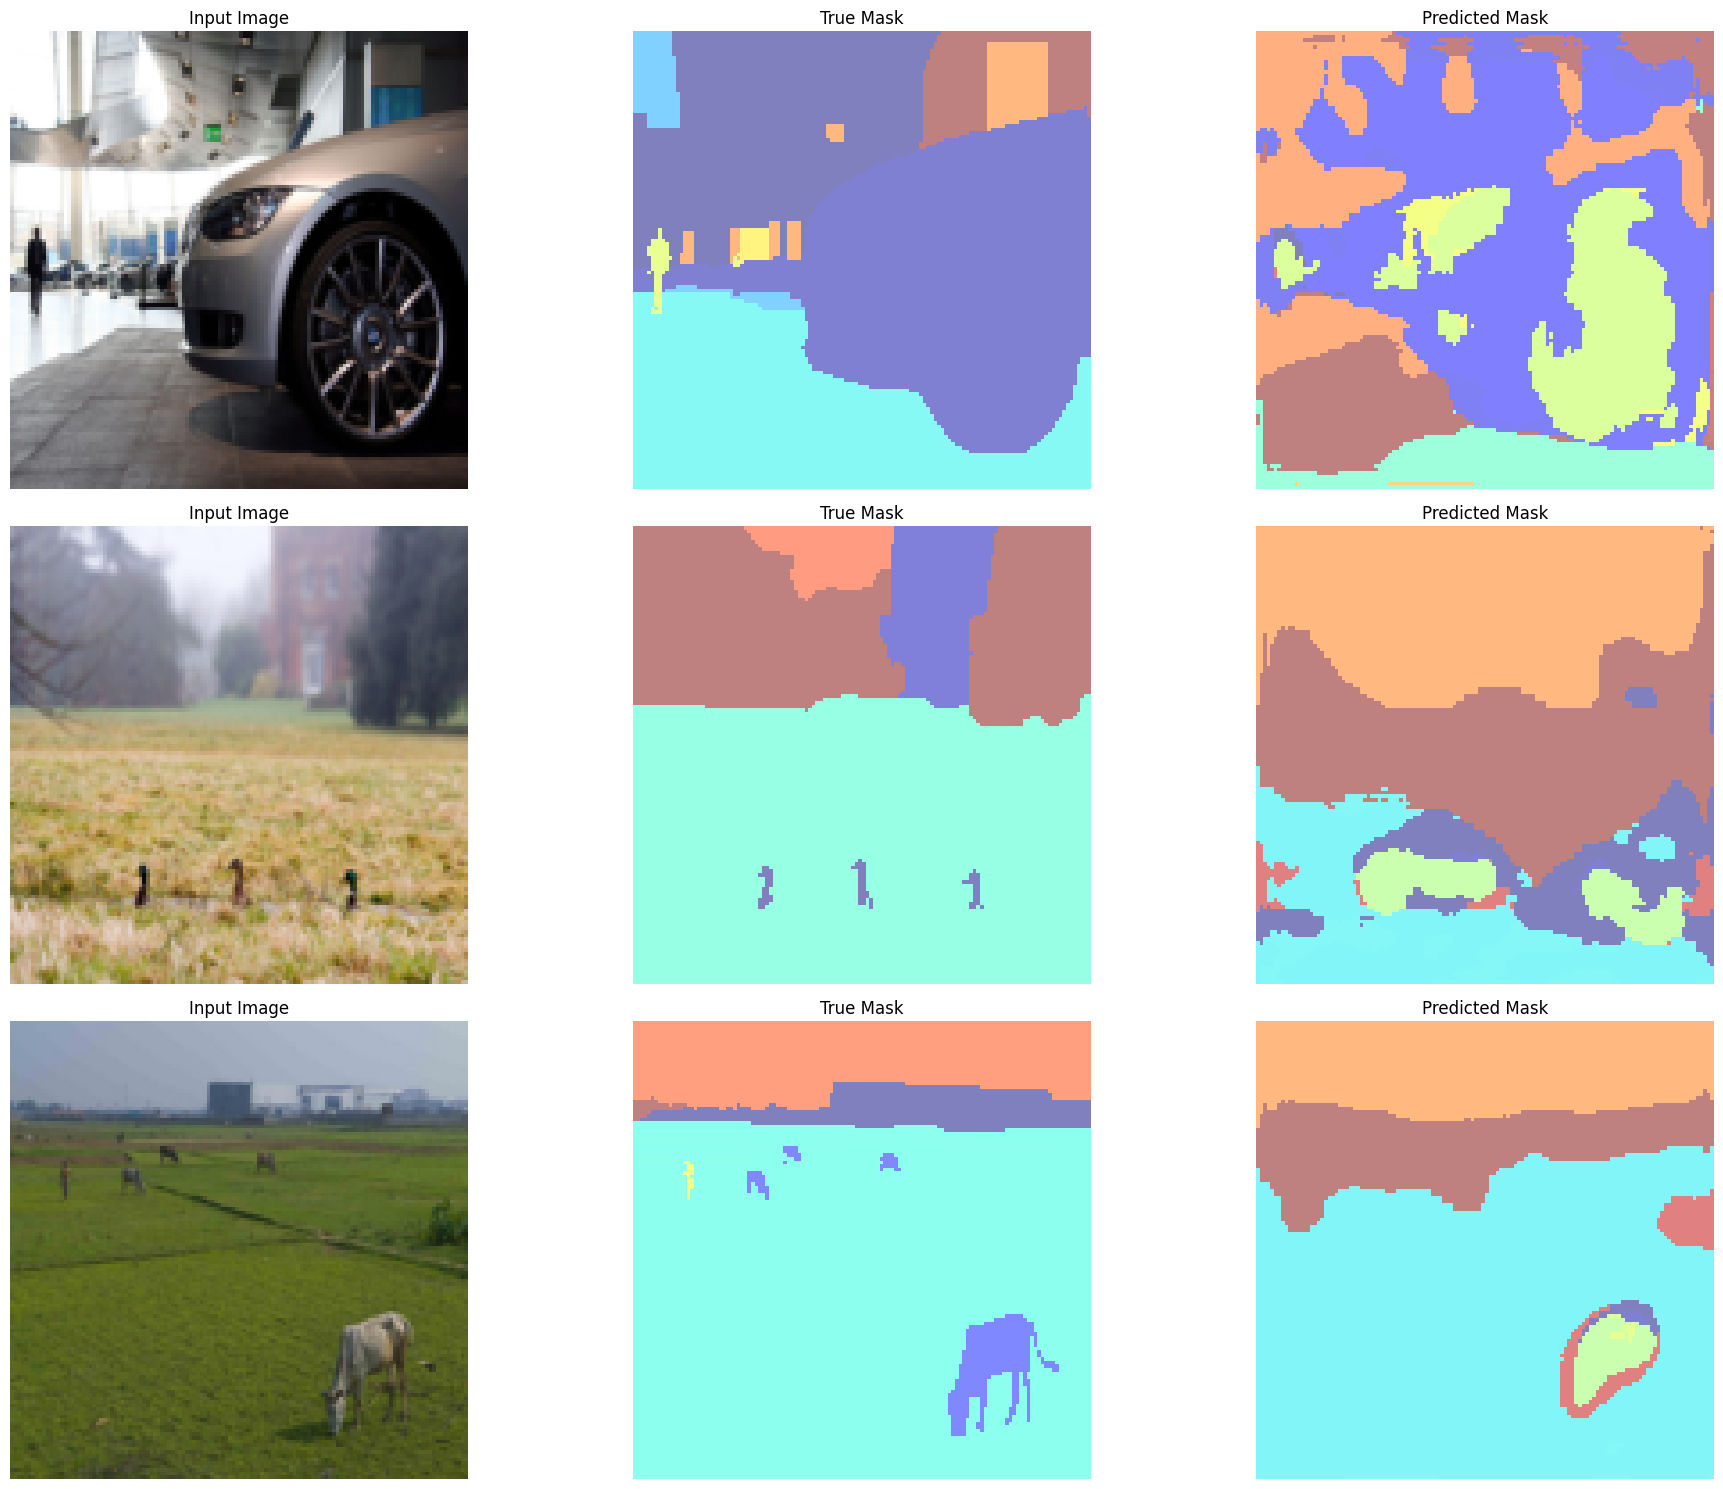

110/110 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.3196 - loss: 2.8998 - val_accuracy: 0.2438 - val_loss: 3.2214
Epoch 4/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3418 - loss: 2.7396
Epoch 4: saving model to unet_model_epoch_04_val_loss_3.3736.keras

Evaluating on test data at the end of epoch 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


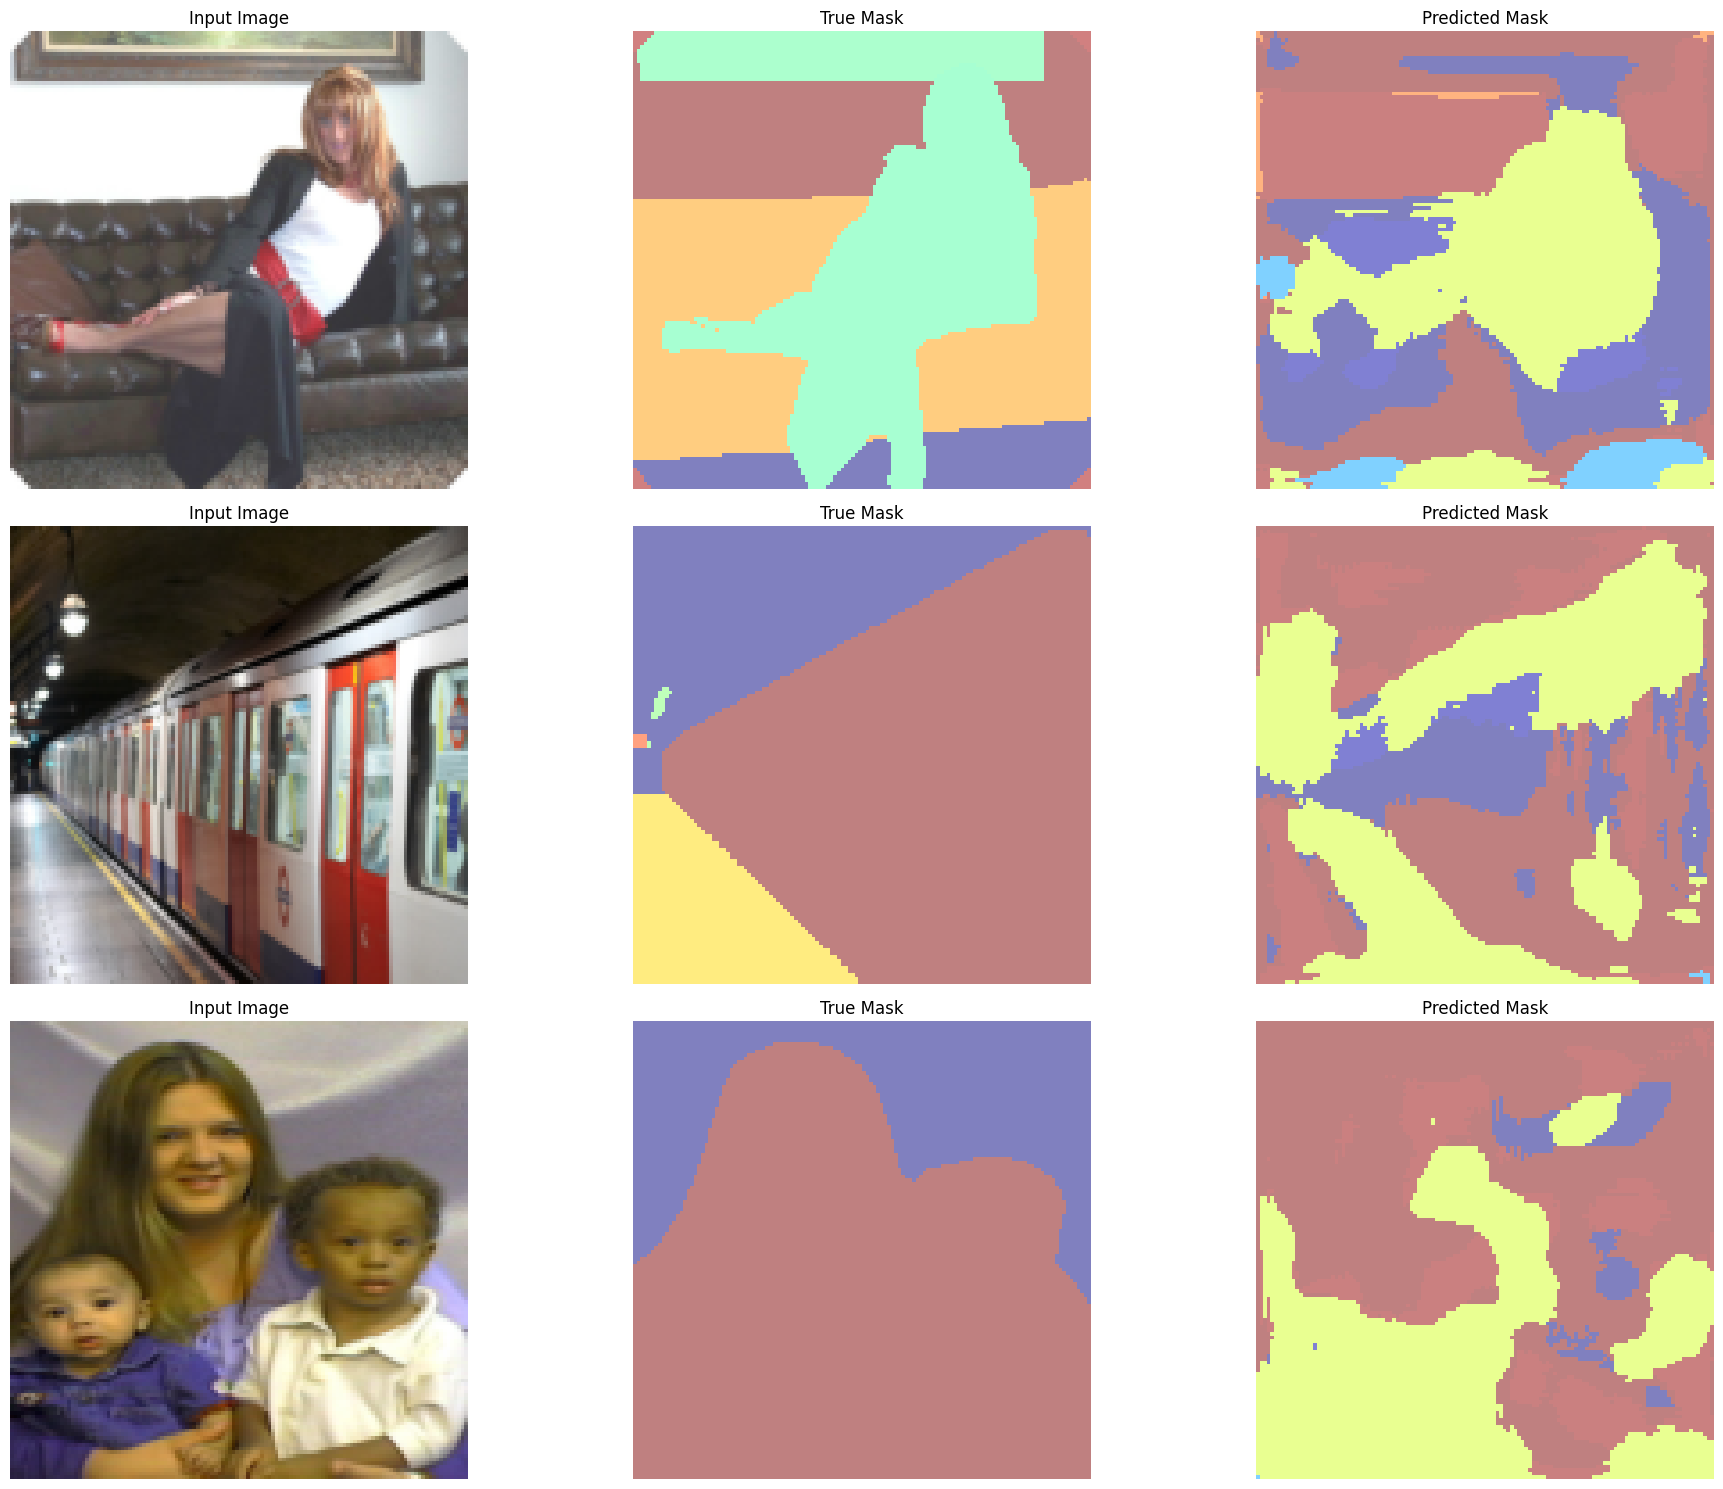

110/110 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.3418 - loss: 2.7395 - val_accuracy: 0.2165 - val_loss: 3.3736
Epoch 5/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3618 - loss: 2.6289
Epoch 5: saving model to unet_model_epoch_05_val_loss_3.0545.keras

Evaluating on test data at the end of epoch 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


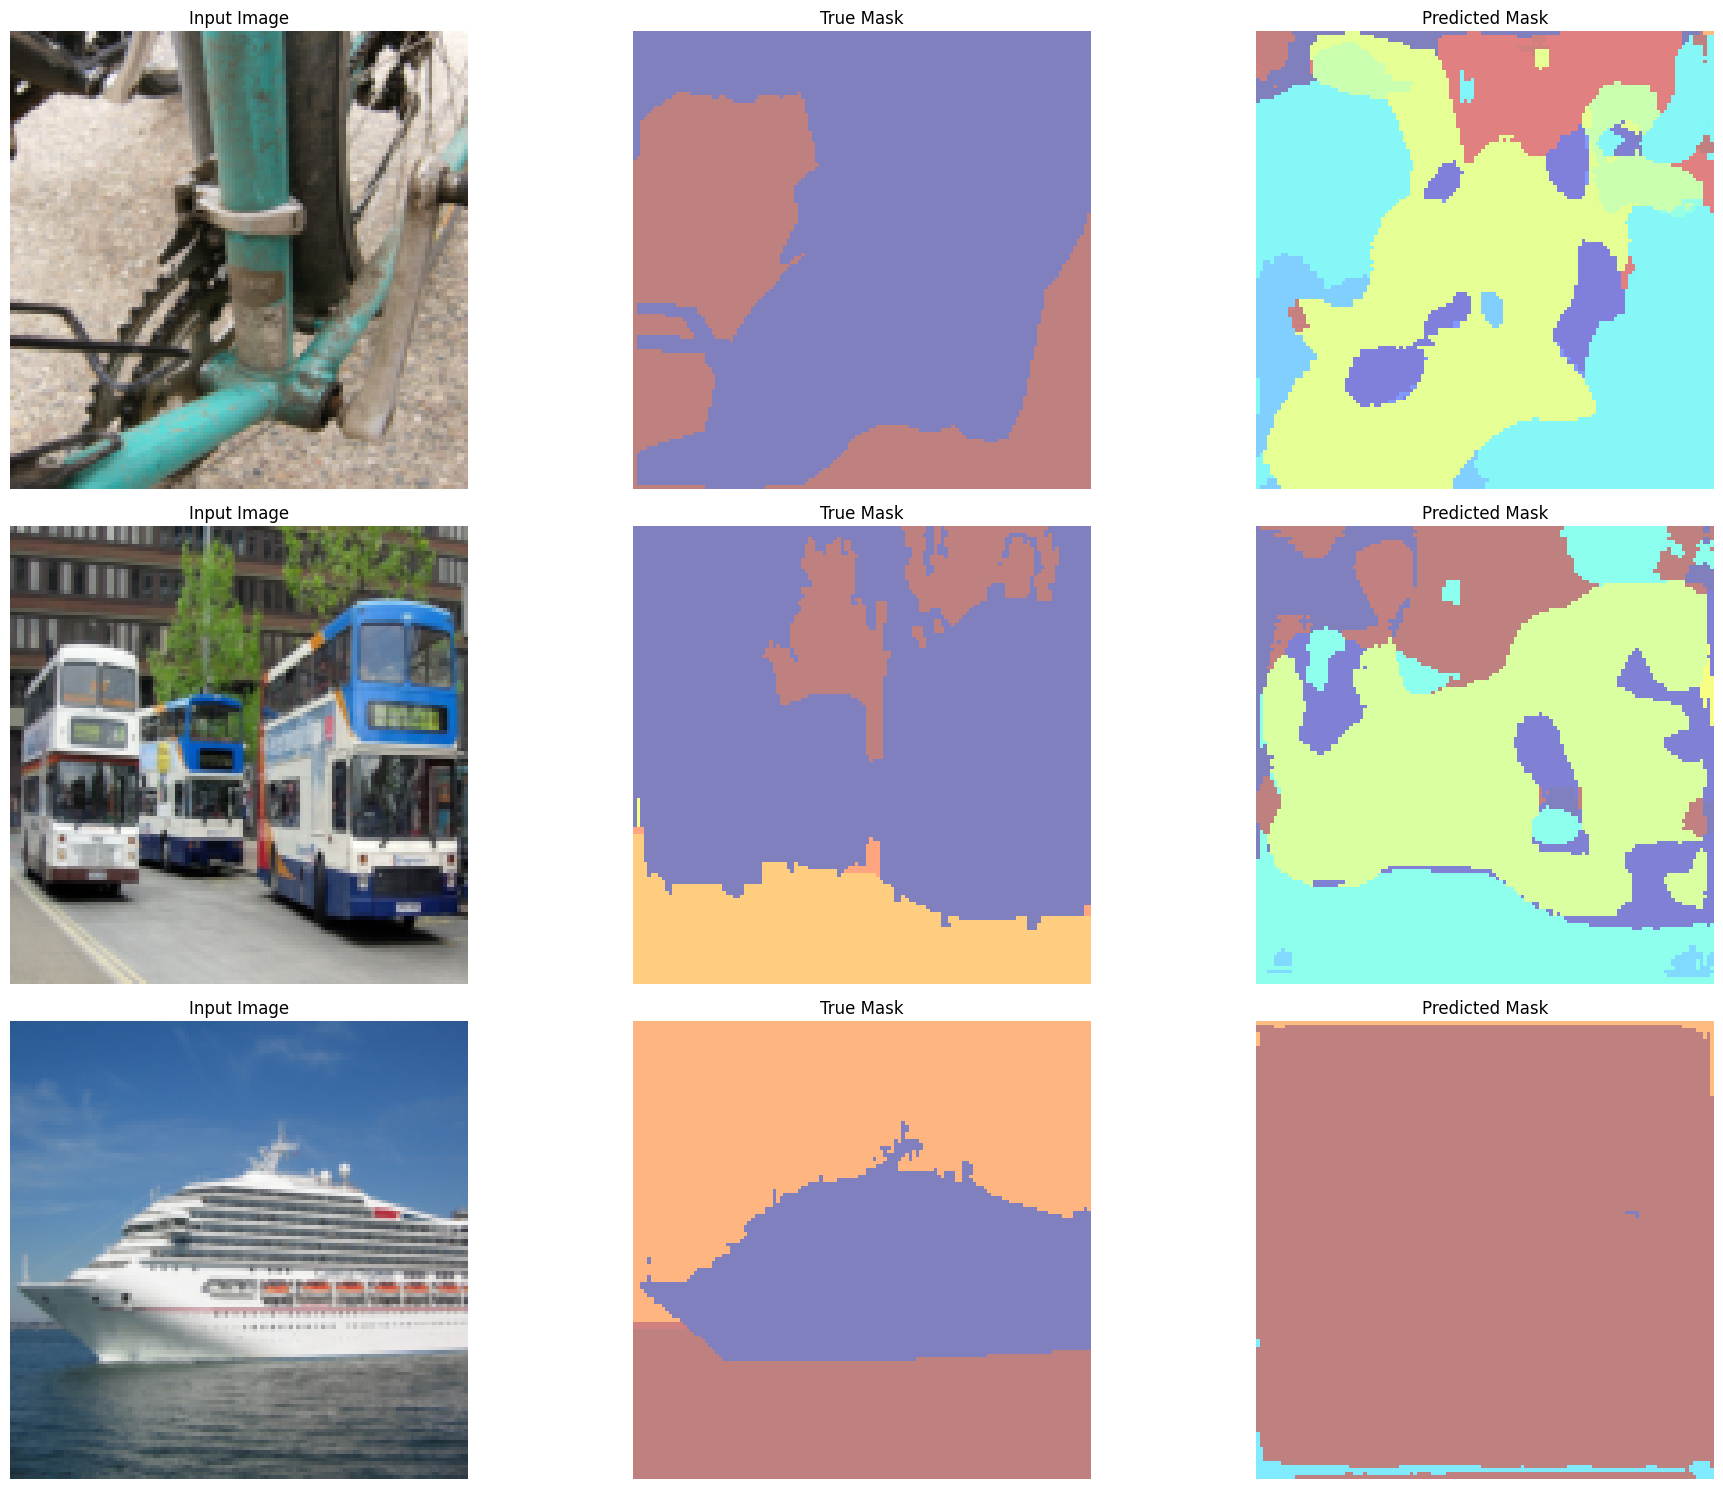

110/110 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.3618 - loss: 2.6288 - val_accuracy: 0.2510 - val_loss: 3.0545
Epoch 6/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3787 - loss: 2.5211
Epoch 6: saving model to unet_model_epoch_06_val_loss_3.0703.keras

Evaluating on test data at the end of epoch 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


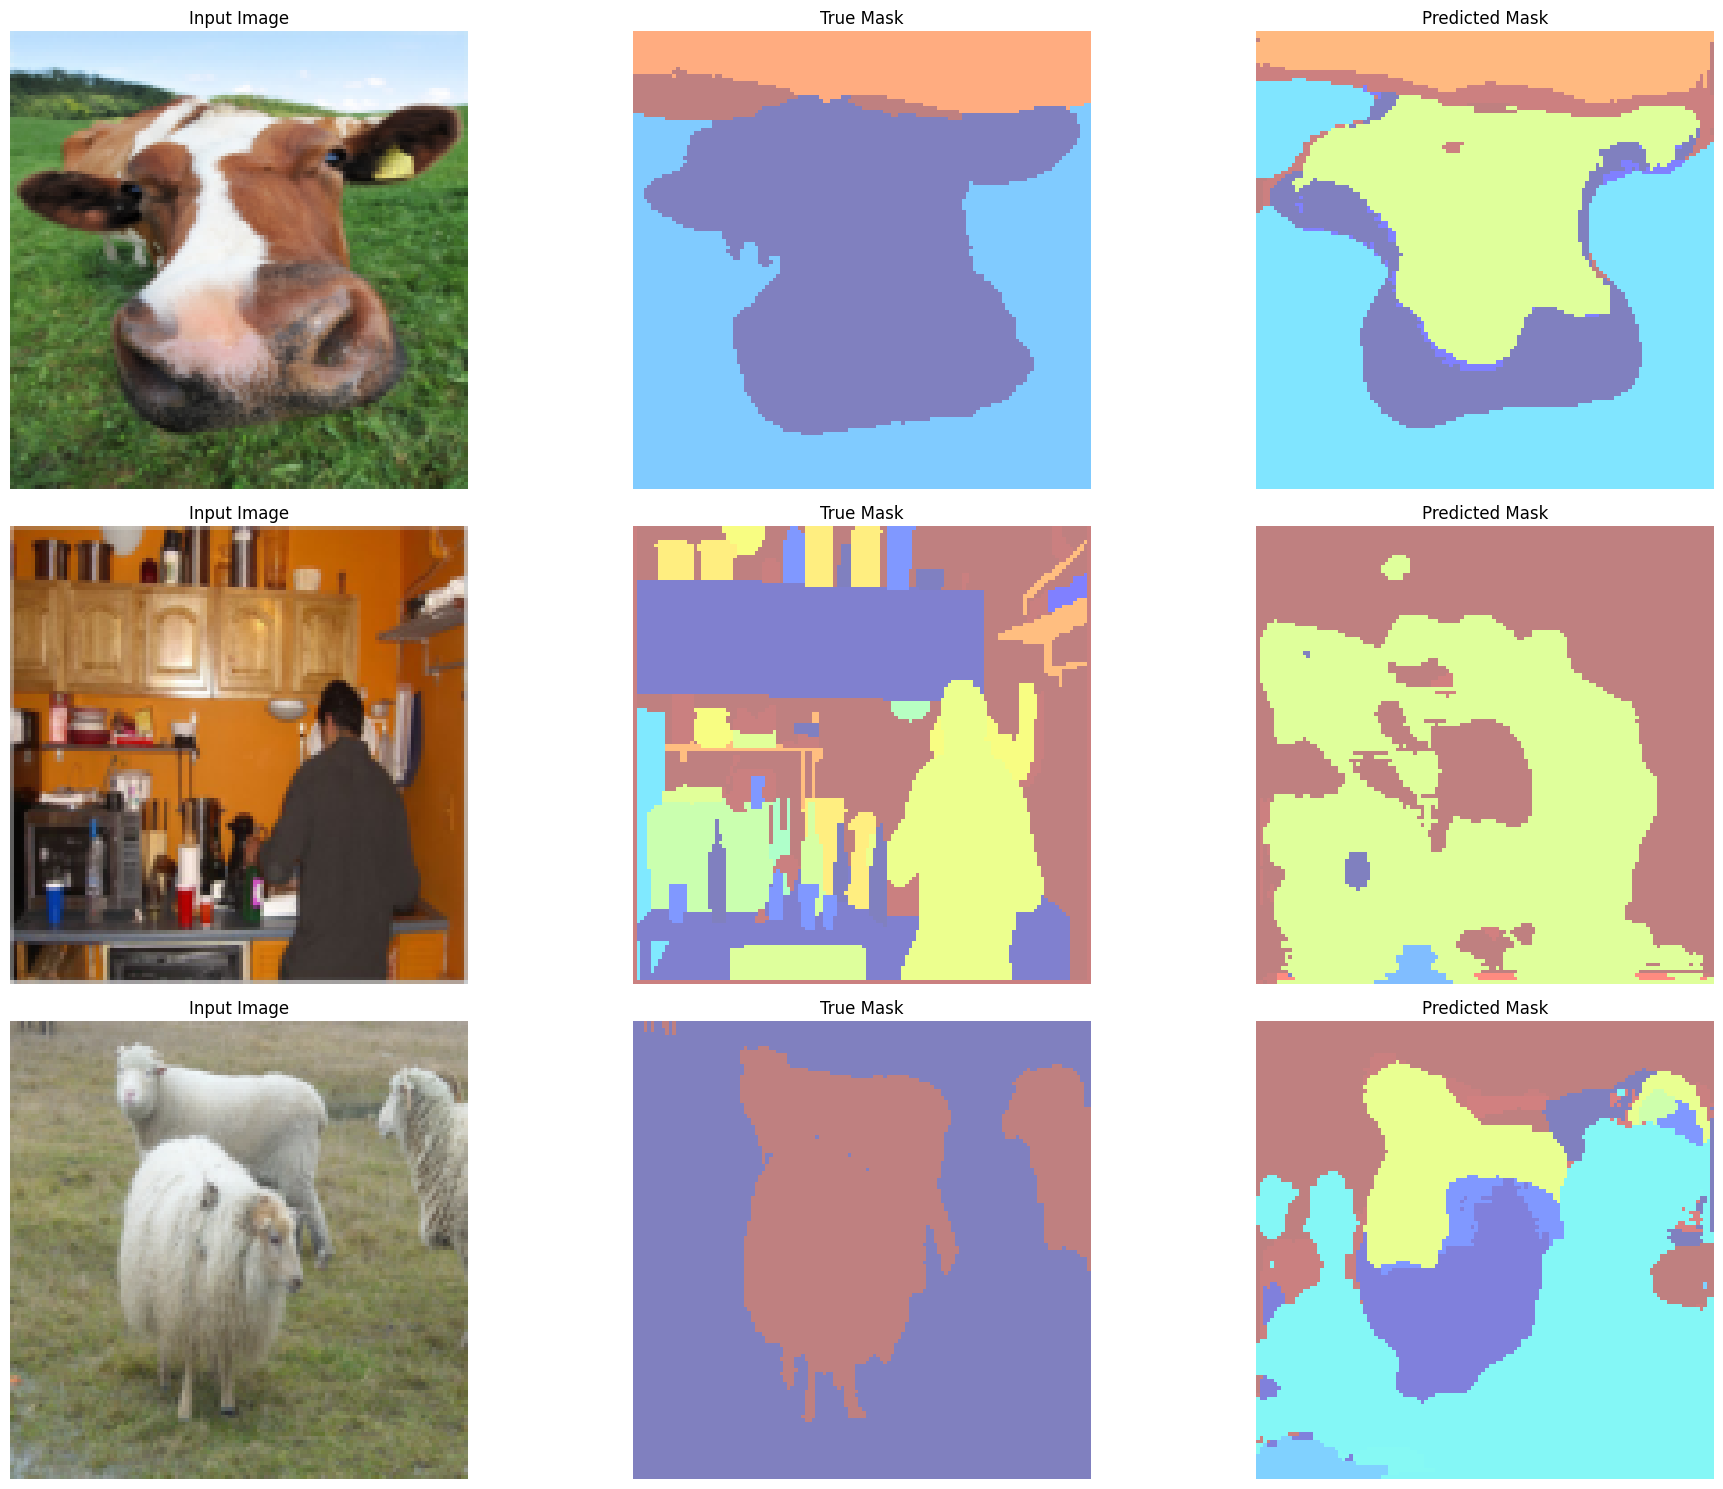

110/110 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.3786 - loss: 2.5212 - val_accuracy: 0.2749 - val_loss: 3.0703
Epoch 7/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3828 - loss: 2.4967
Epoch 7: saving model to unet_model_epoch_07_val_loss_3.0646.keras

Evaluating on test data at the end of epoch 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


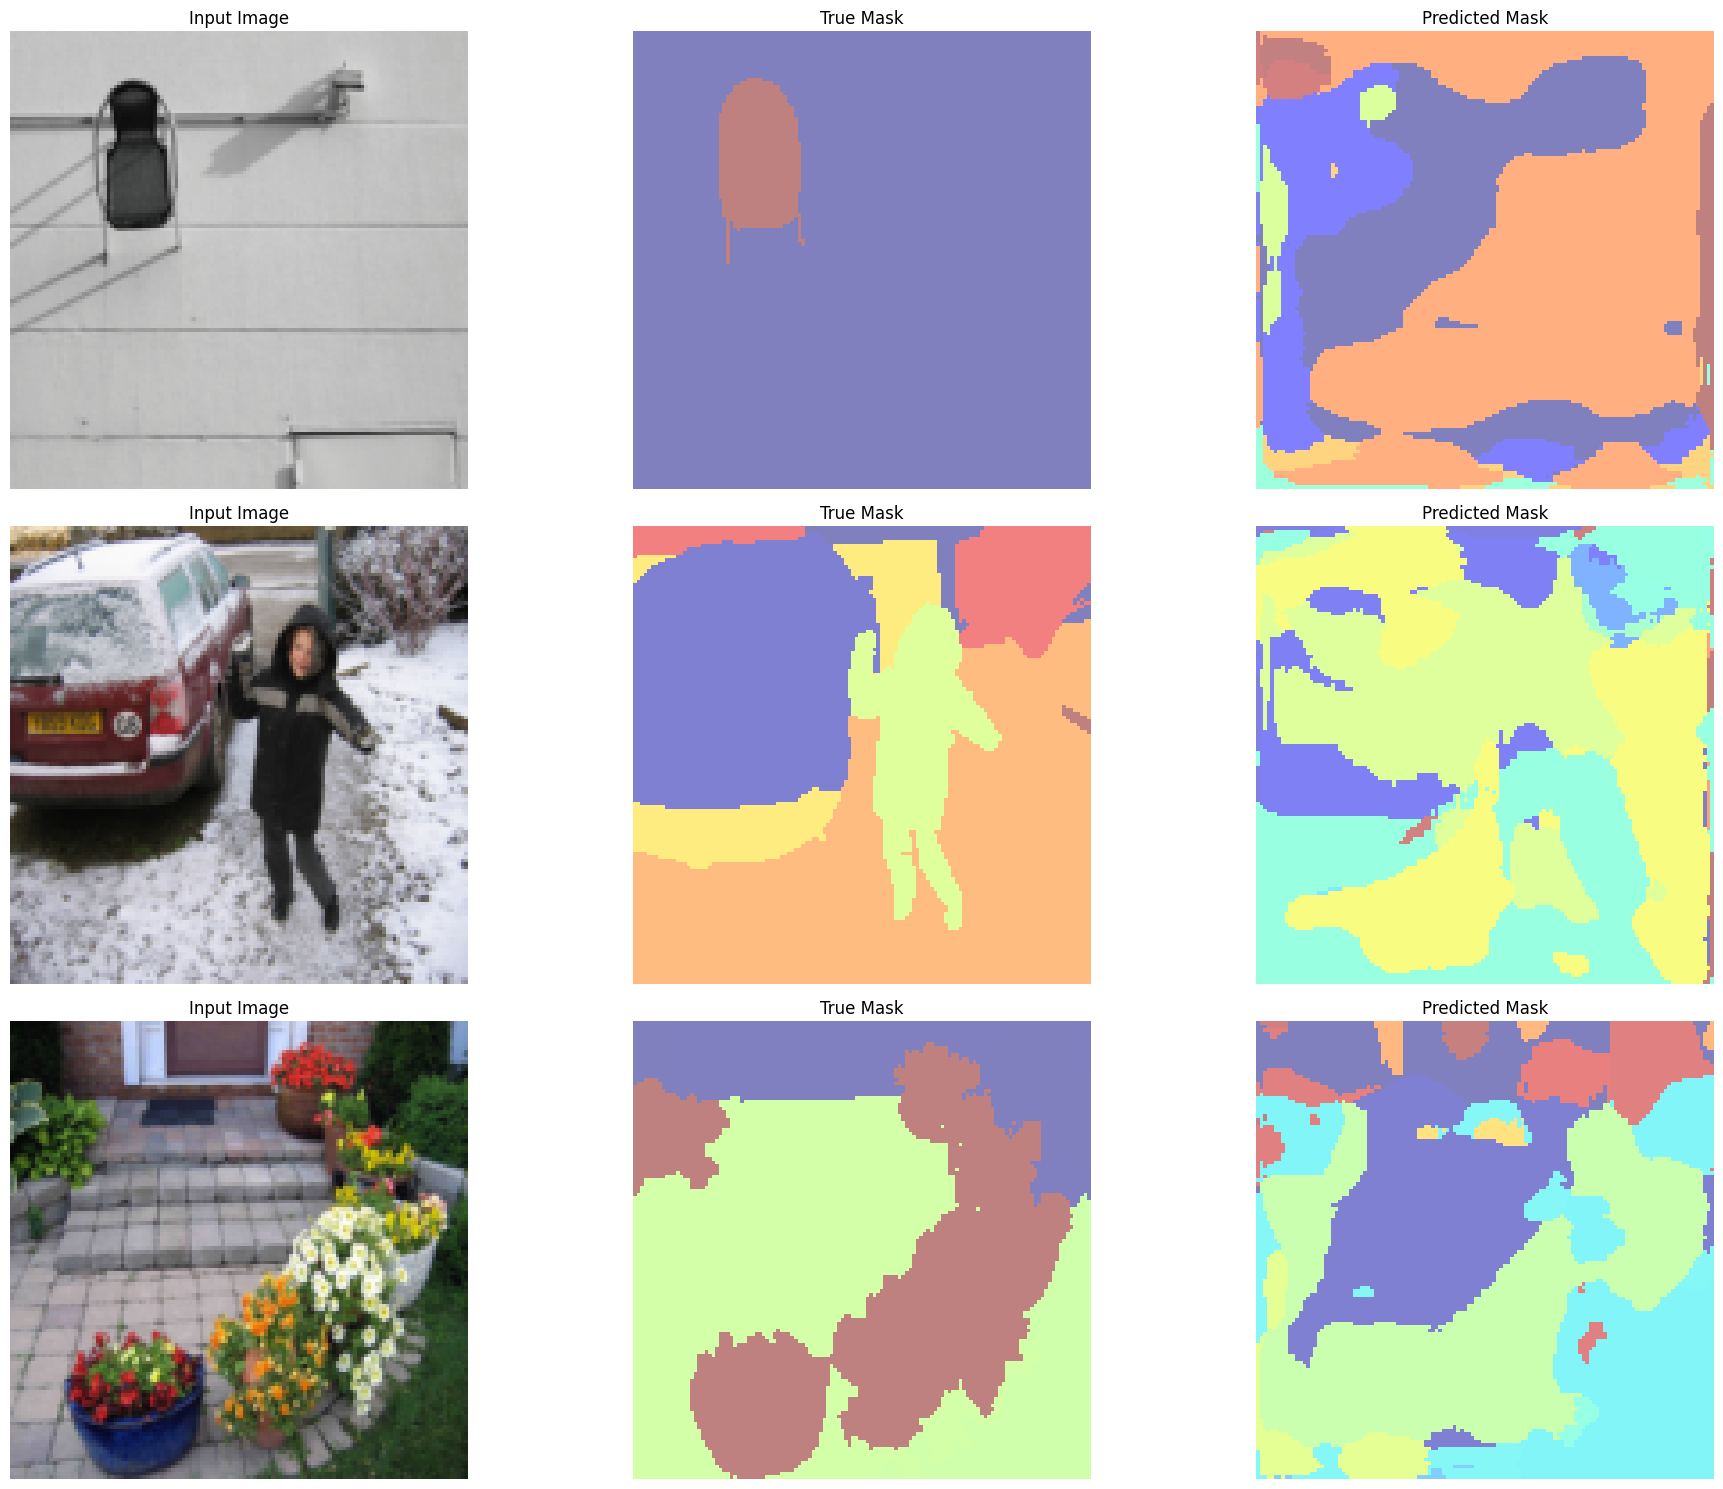

110/110 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.3828 - loss: 2.4967 - val_accuracy: 0.2706 - val_loss: 3.0646
Epoch 8/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3904 - loss: 2.4607
Epoch 8: saving model to unet_model_epoch_08_val_loss_2.7690.keras

Evaluating on test data at the end of epoch 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


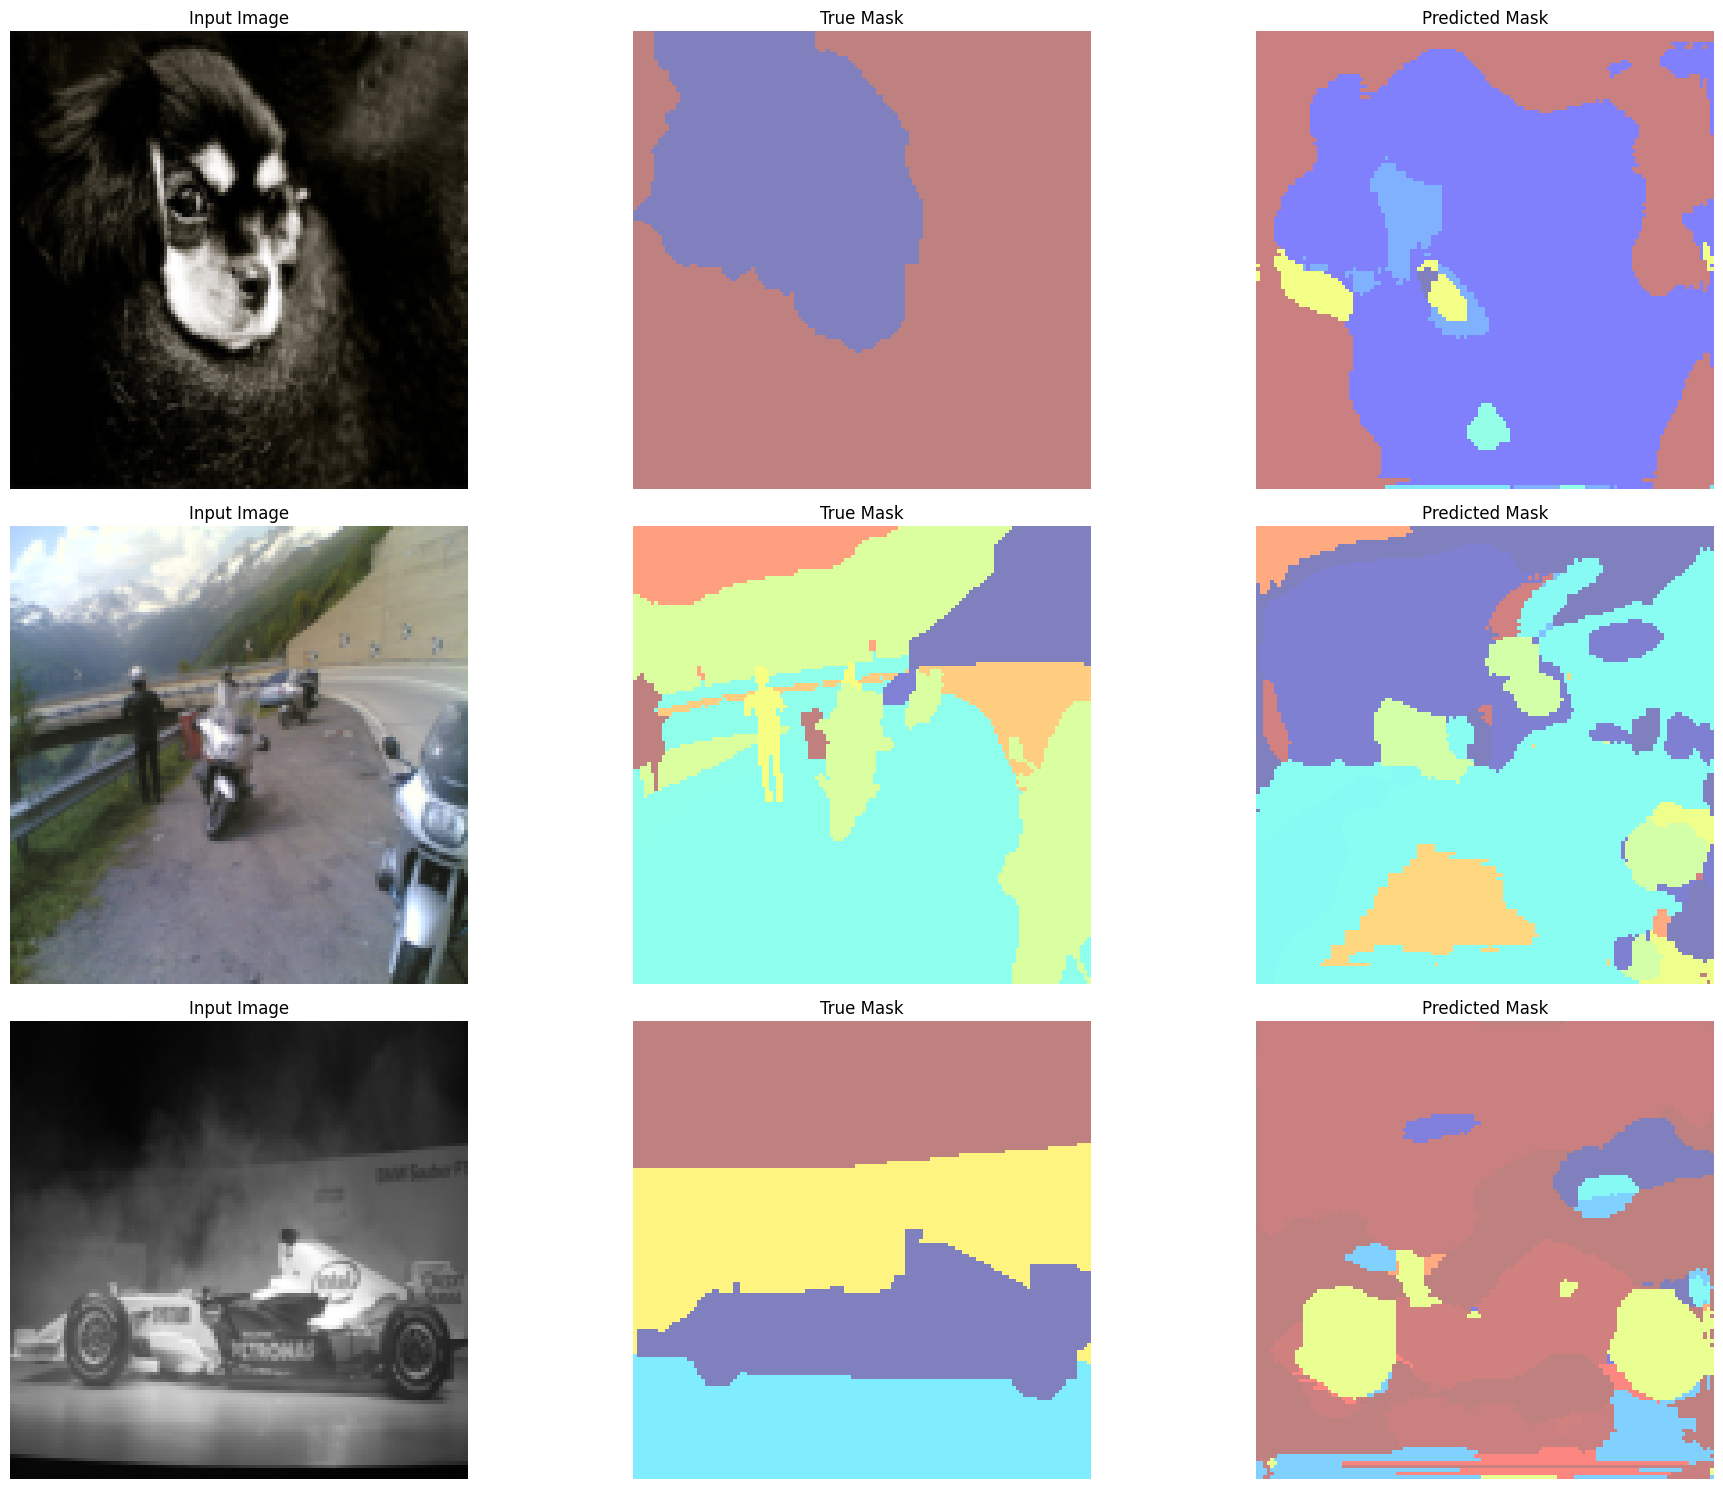

110/110 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.3905 - loss: 2.4605 - val_accuracy: 0.3407 - val_loss: 2.7690
Epoch 9/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4037 - loss: 2.3964
Epoch 9: saving model to unet_model_epoch_09_val_loss_2.7784.keras

Evaluating on test data at the end of epoch 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


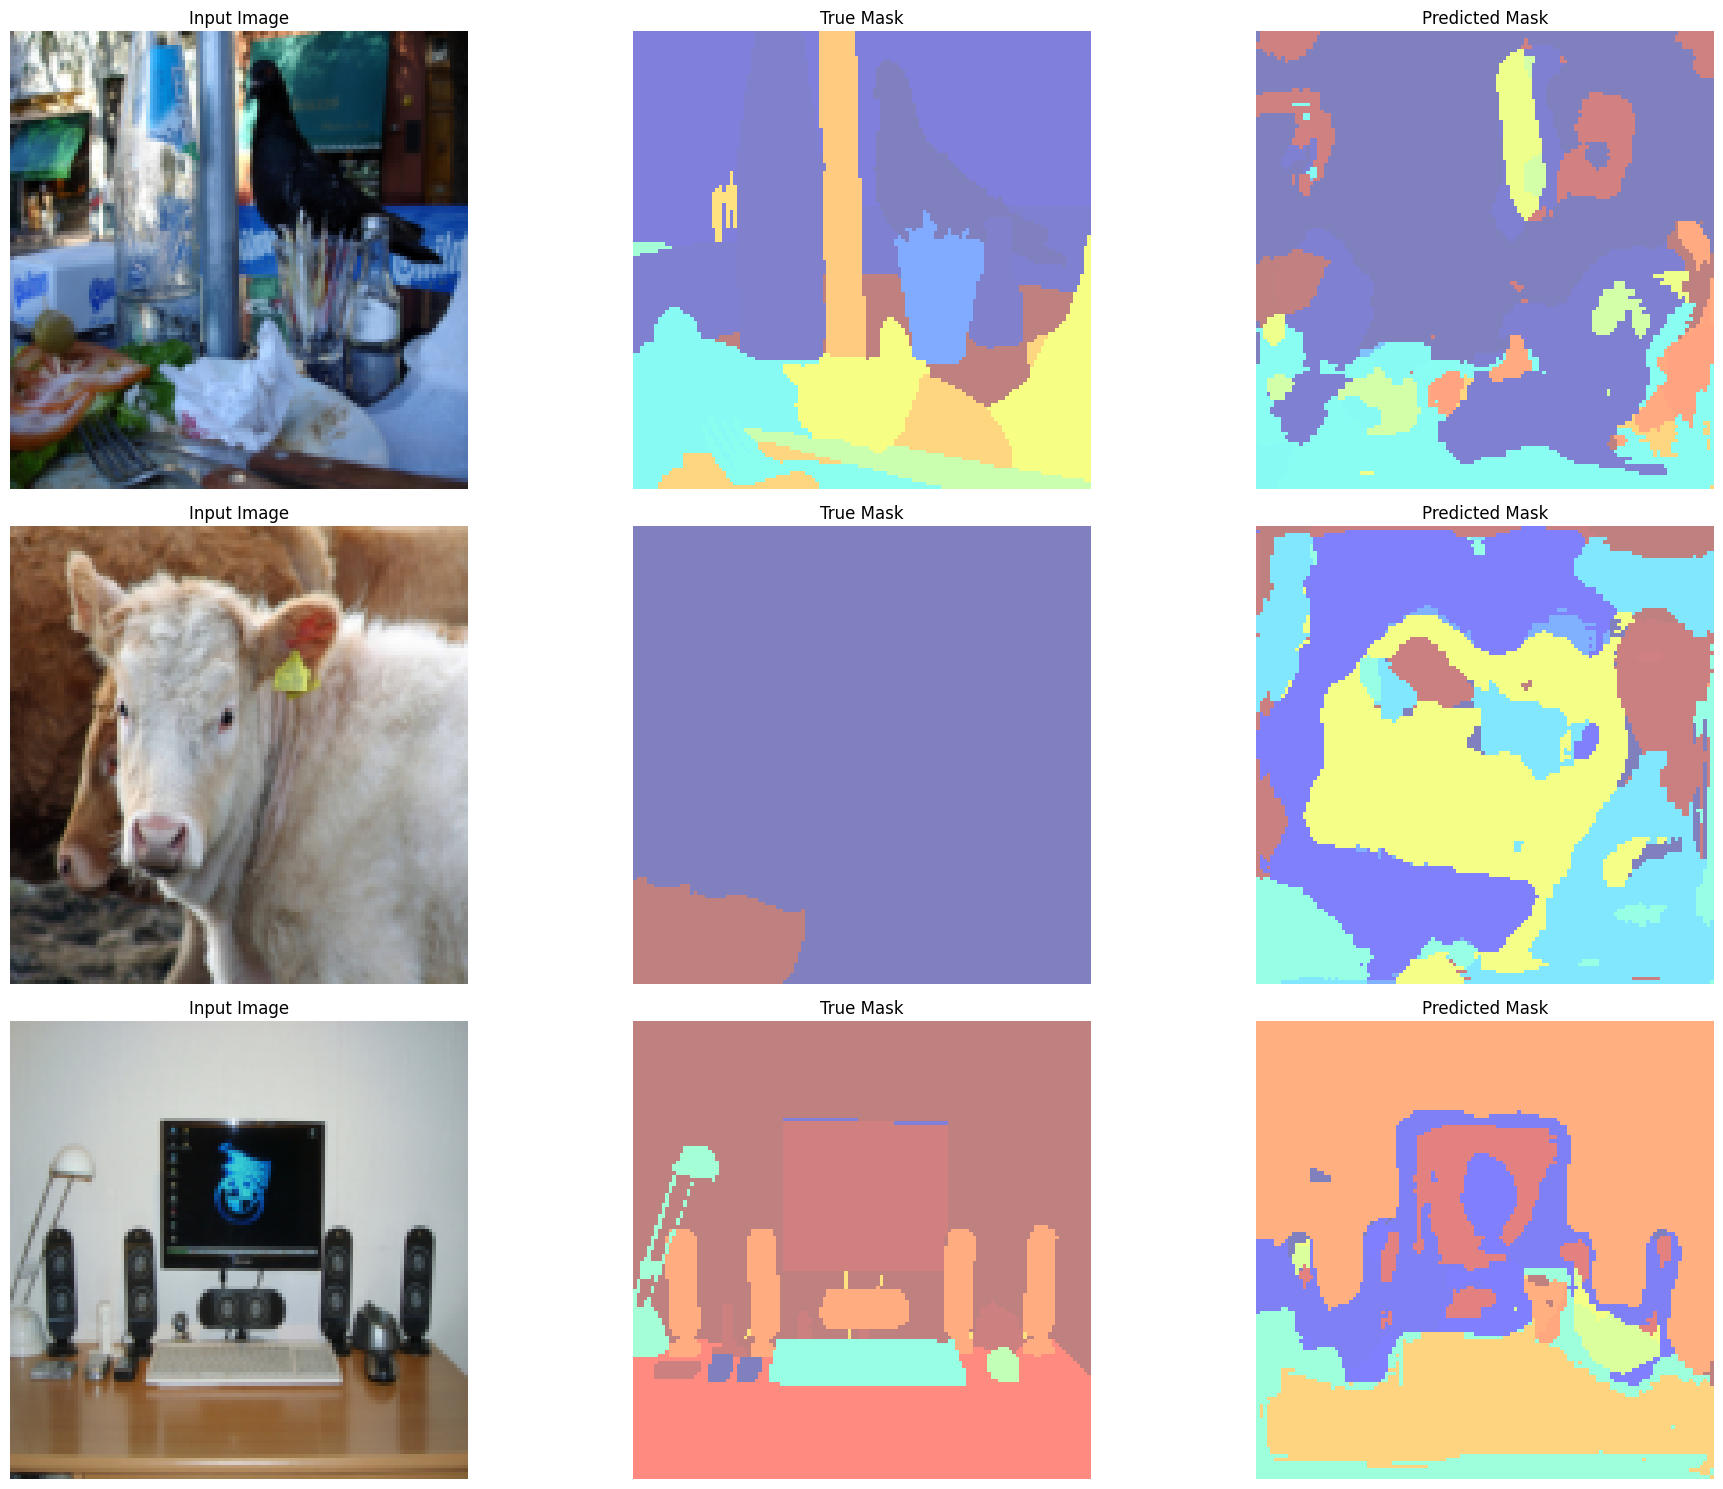

110/110 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.4037 - loss: 2.3963 - val_accuracy: 0.3456 - val_loss: 2.7784
Epoch 10/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4066 - loss: 2.3678
Epoch 10: saving model to unet_model_epoch_10_val_loss_3.0032.keras

Evaluating on test data at the end of epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


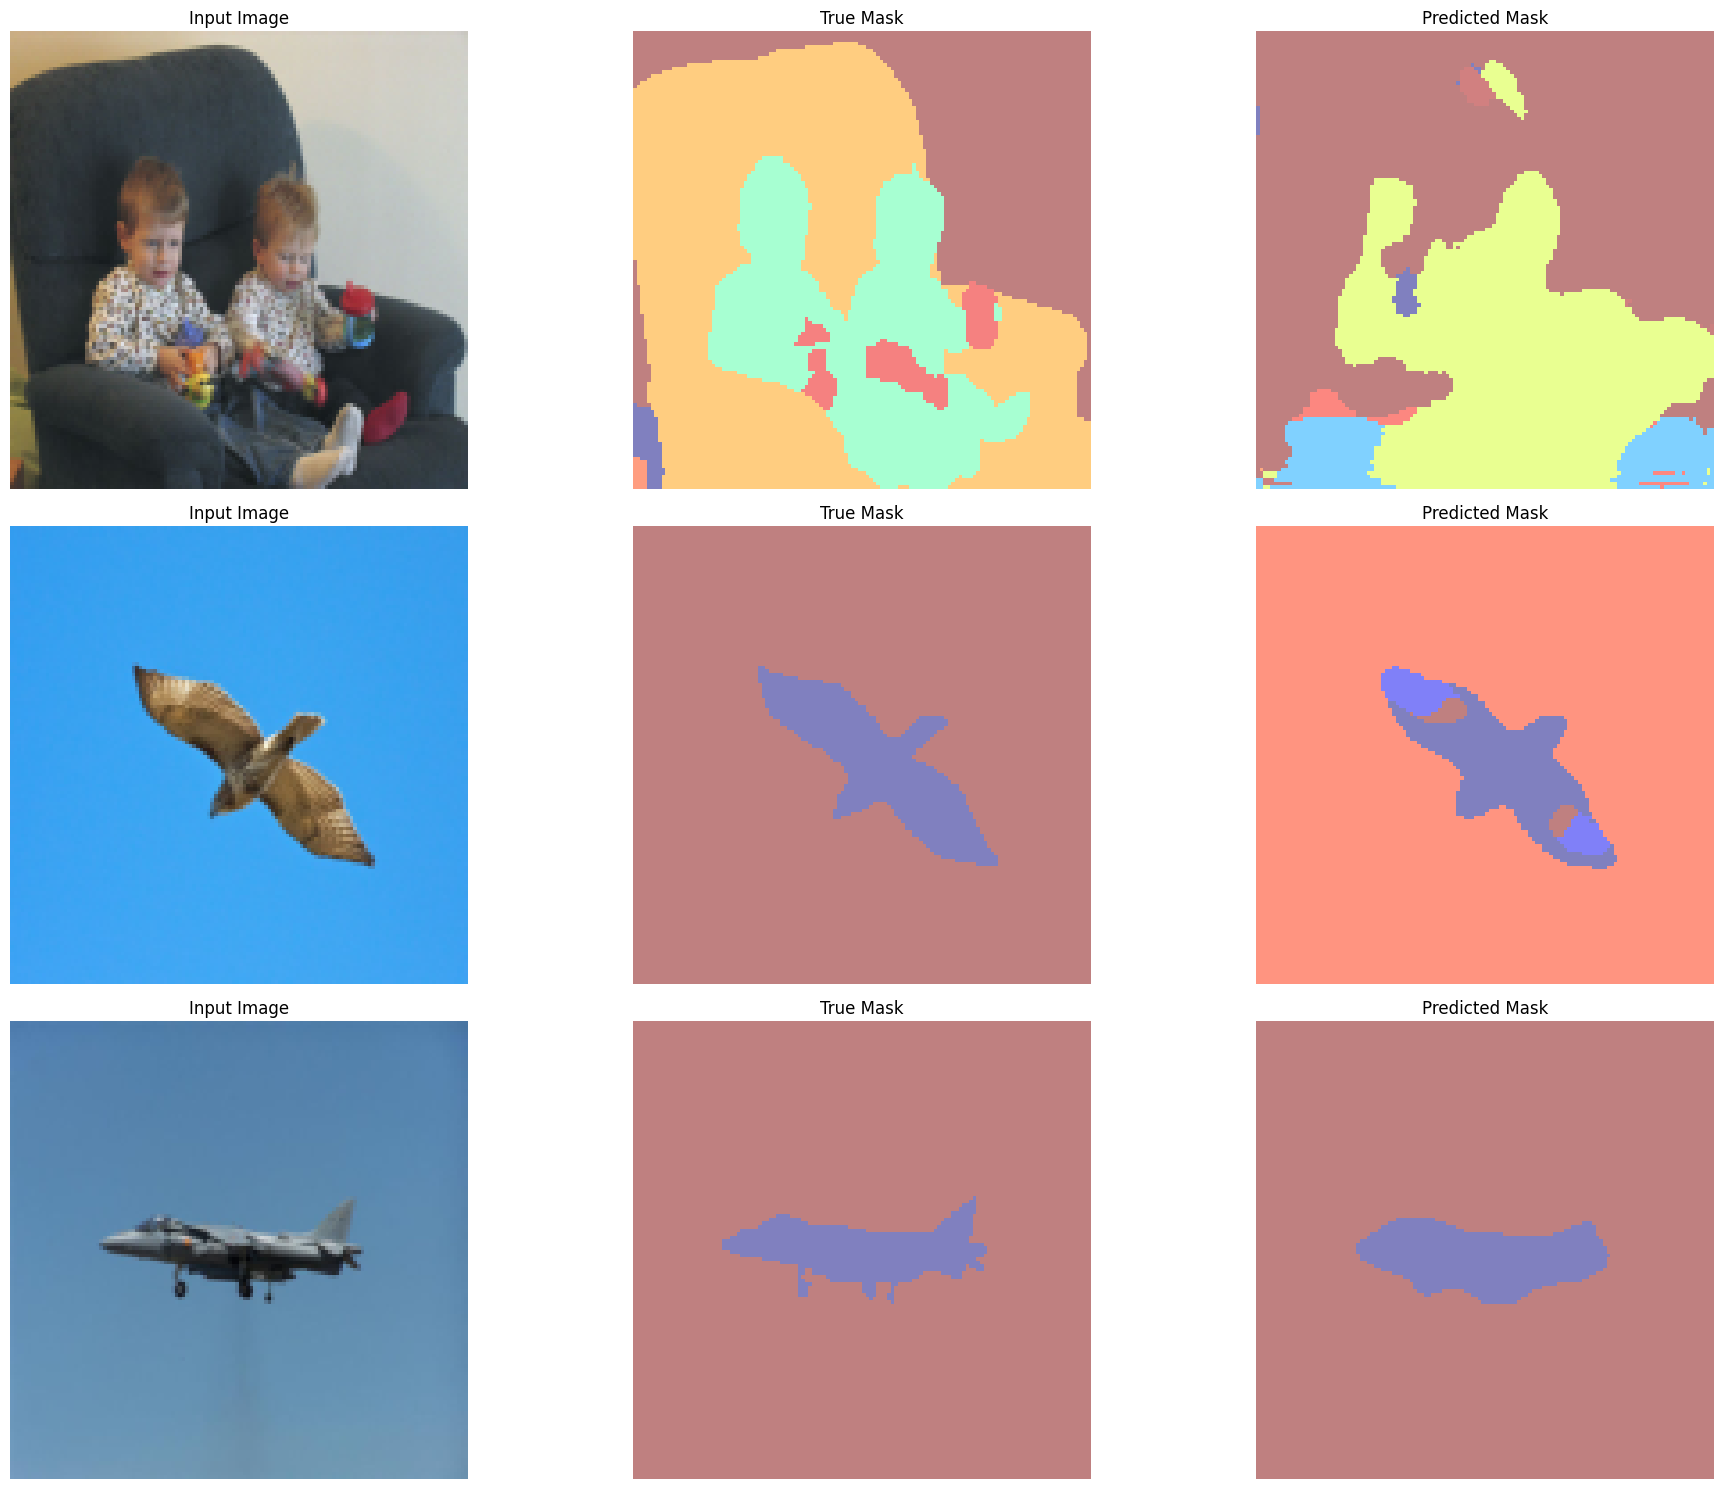

110/110 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.4066 - loss: 2.3676 - val_accuracy: 0.3223 - val_loss: 3.0032
Epoch 11/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4184 - loss: 2.3151
Epoch 11: saving model to unet_model_epoch_11_val_loss_4.3194.keras

Evaluating on test data at the end of epoch 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


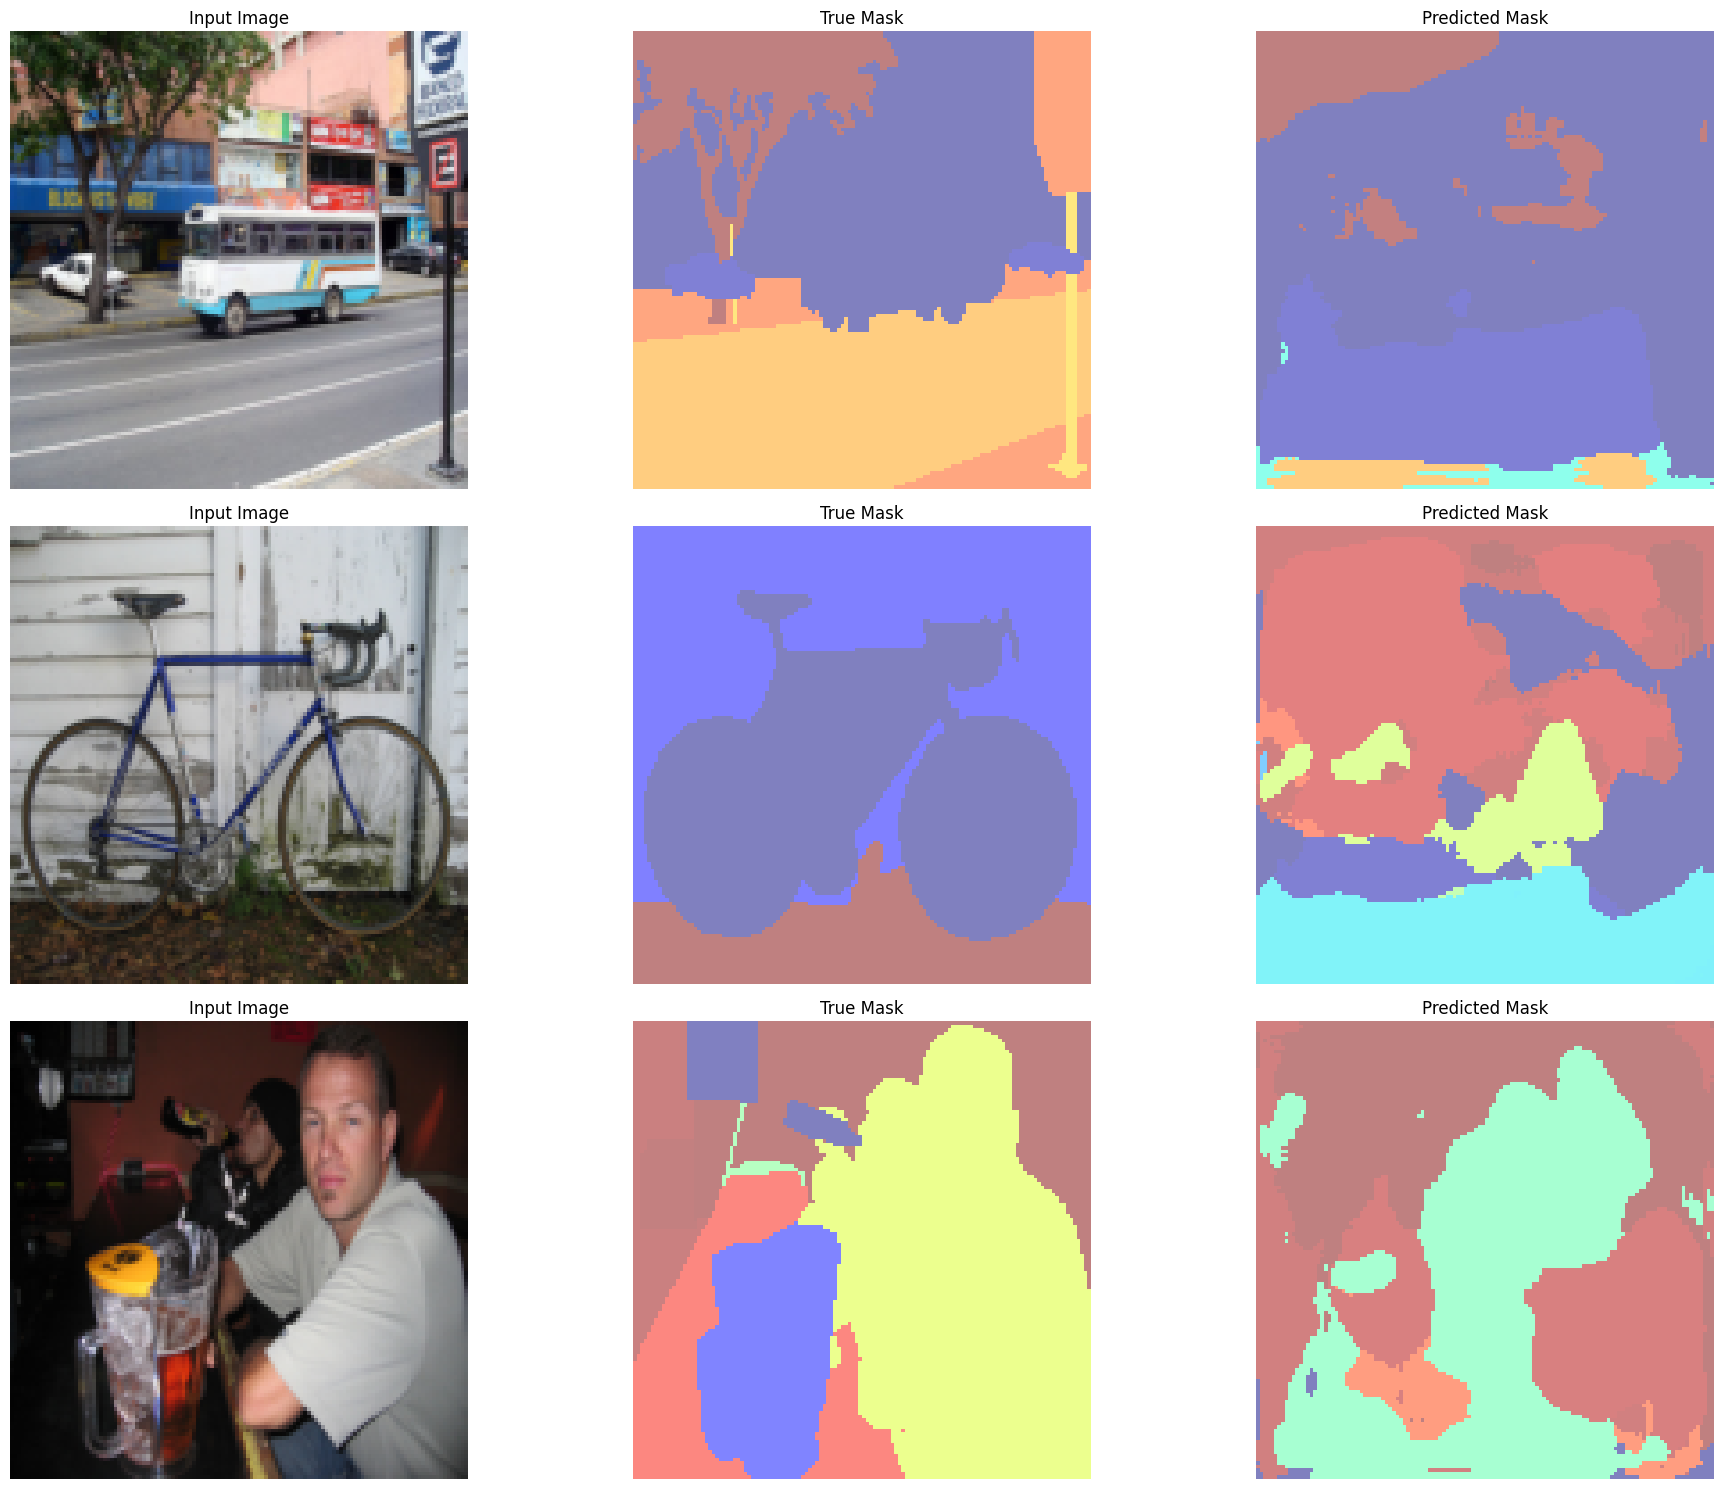

110/110 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.4184 - loss: 2.3151 - val_accuracy: 0.1814 - val_loss: 4.3194
Epoch 12/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4212 - loss: 2.3063
Epoch 12: saving model to unet_model_epoch_12_val_loss_3.2944.keras

Evaluating on test data at the end of epoch 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


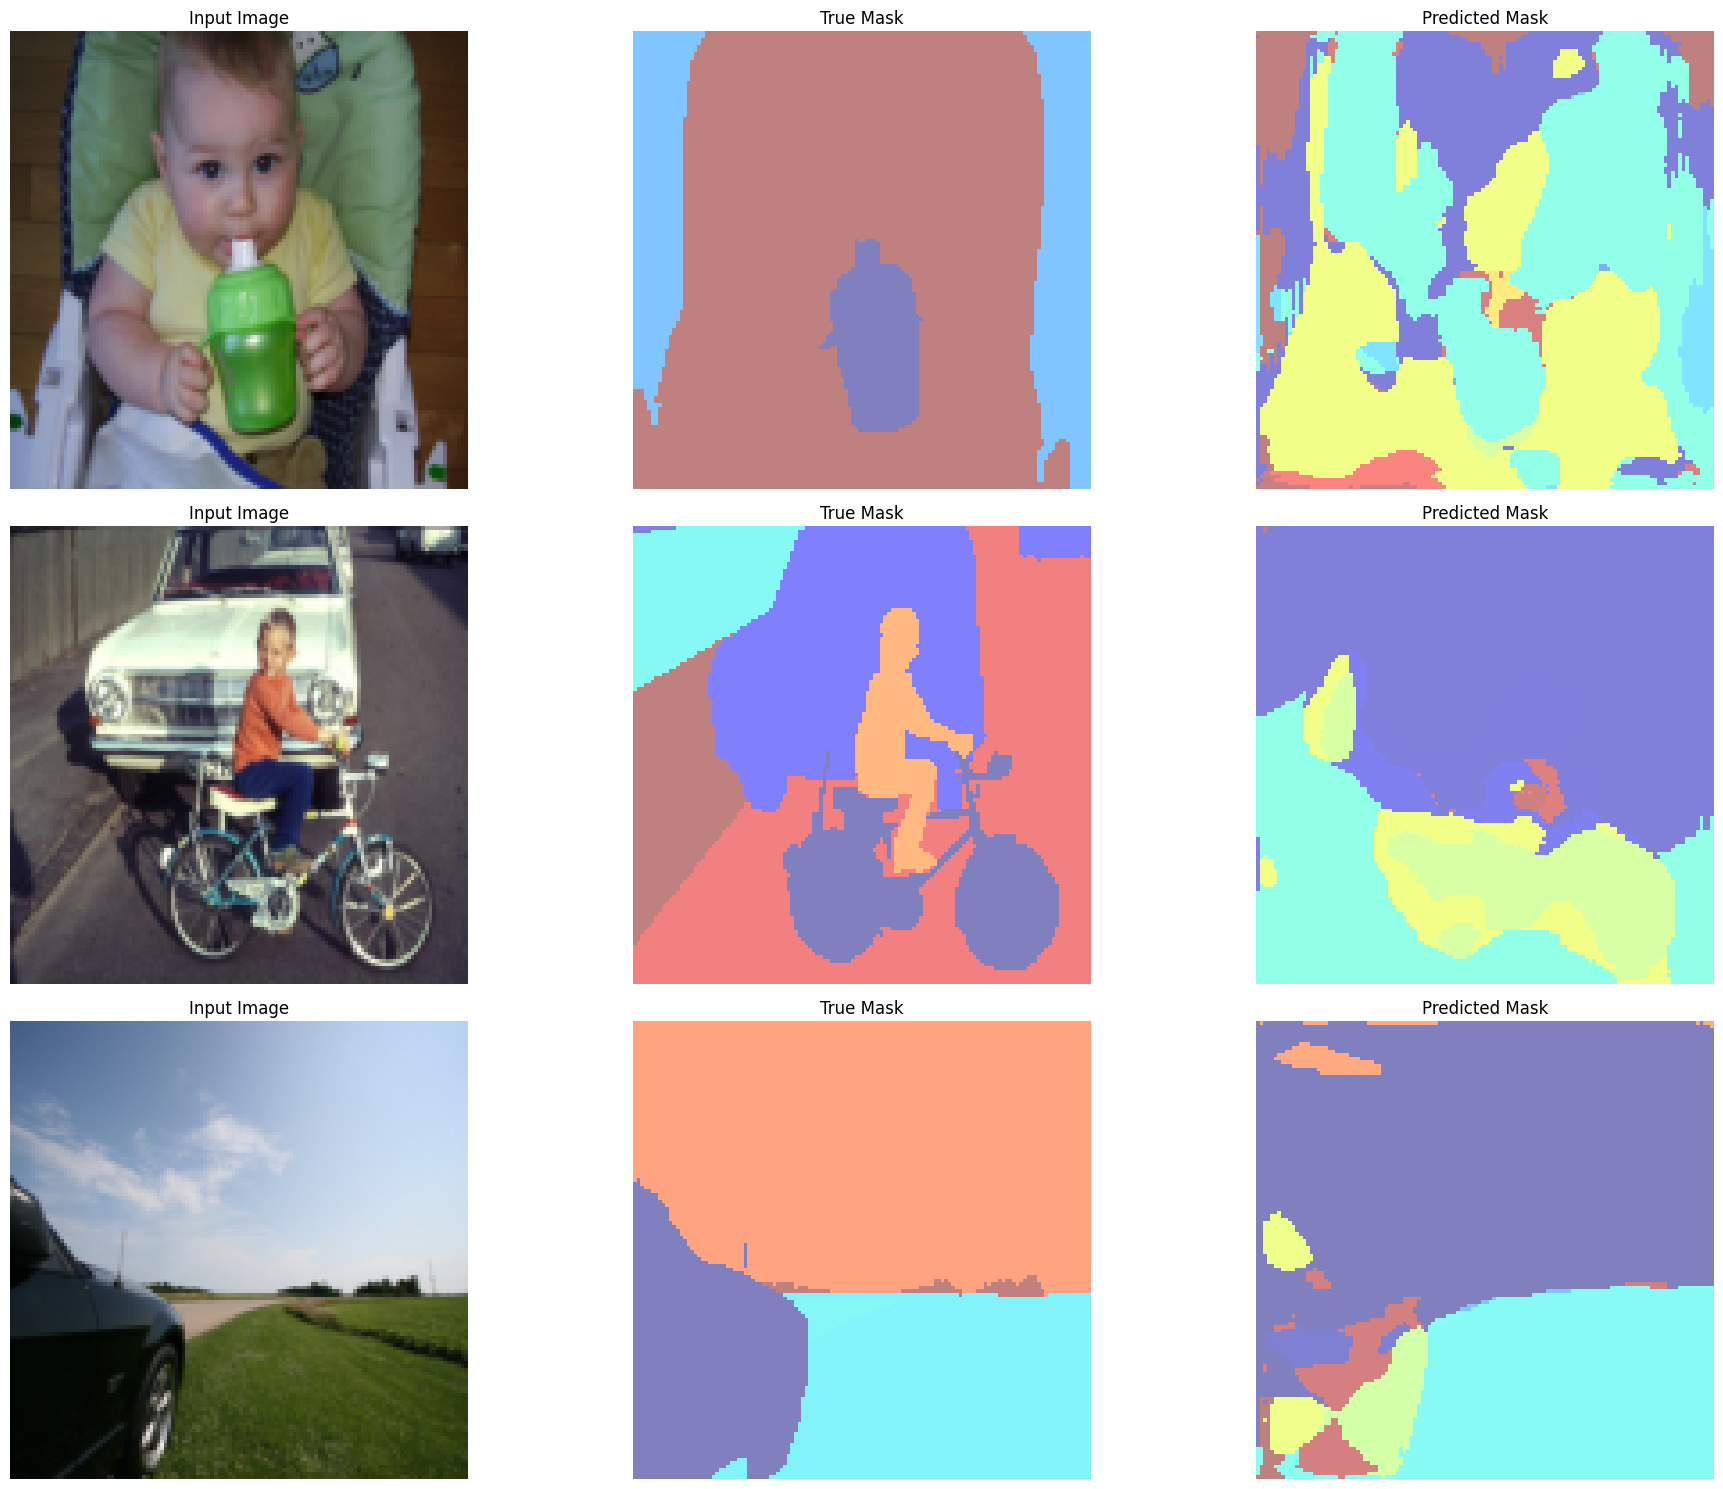

110/110 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.4211 - loss: 2.3065 - val_accuracy: 0.2719 - val_loss: 3.2944
Epoch 13/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4234 - loss: 2.2815
Epoch 13: saving model to unet_model_epoch_13_val_loss_2.7727.keras

Evaluating on test data at the end of epoch 13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


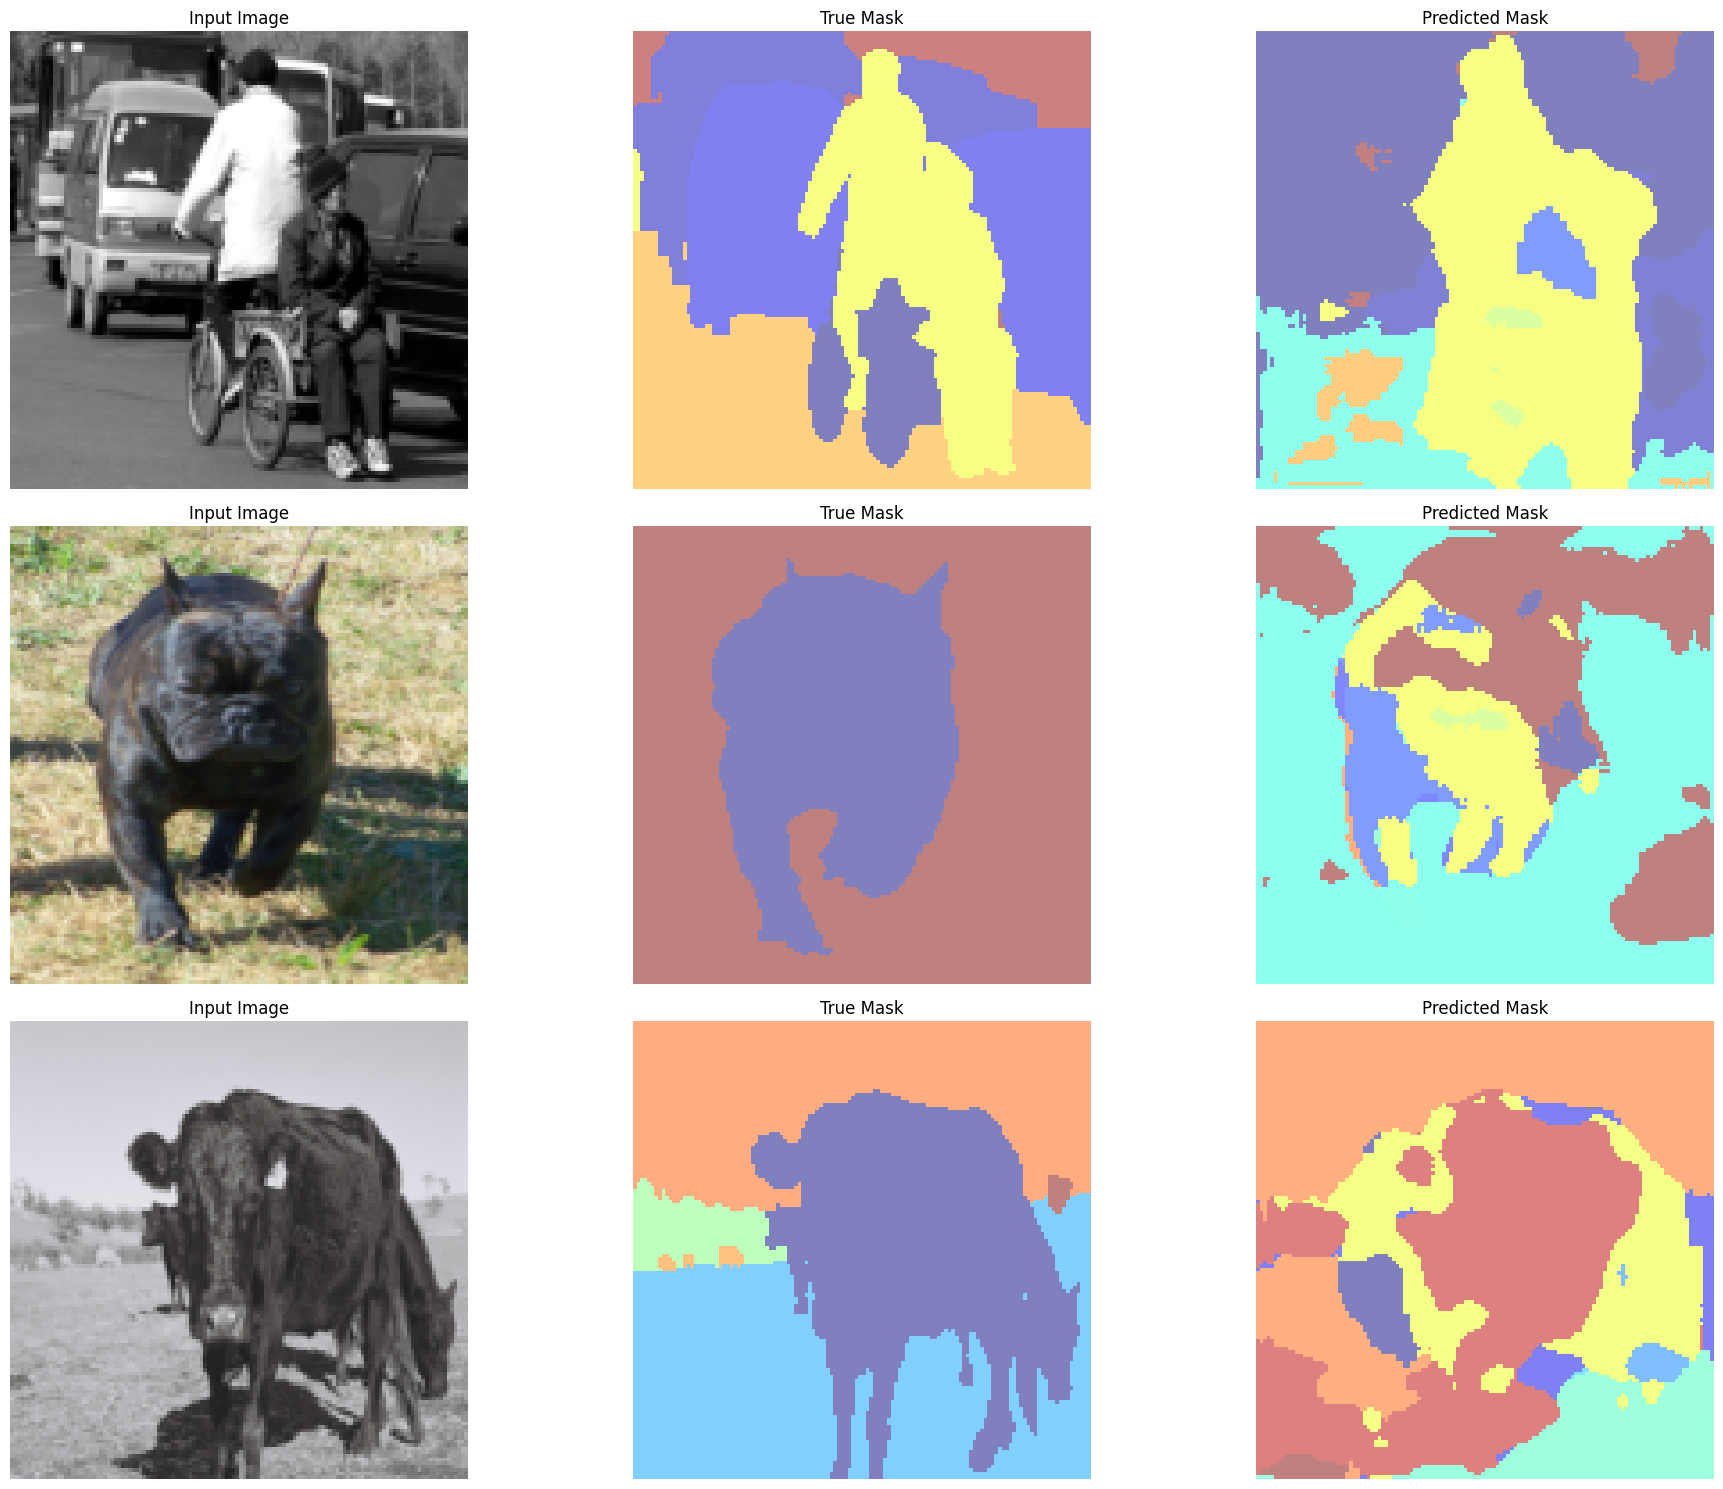

110/110 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.4234 - loss: 2.2814 - val_accuracy: 0.3418 - val_loss: 2.7727
Epoch 14/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4364 - loss: 2.2026
Epoch 14: saving model to unet_model_epoch_14_val_loss_2.8821.keras

Evaluating on test data at the end of epoch 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


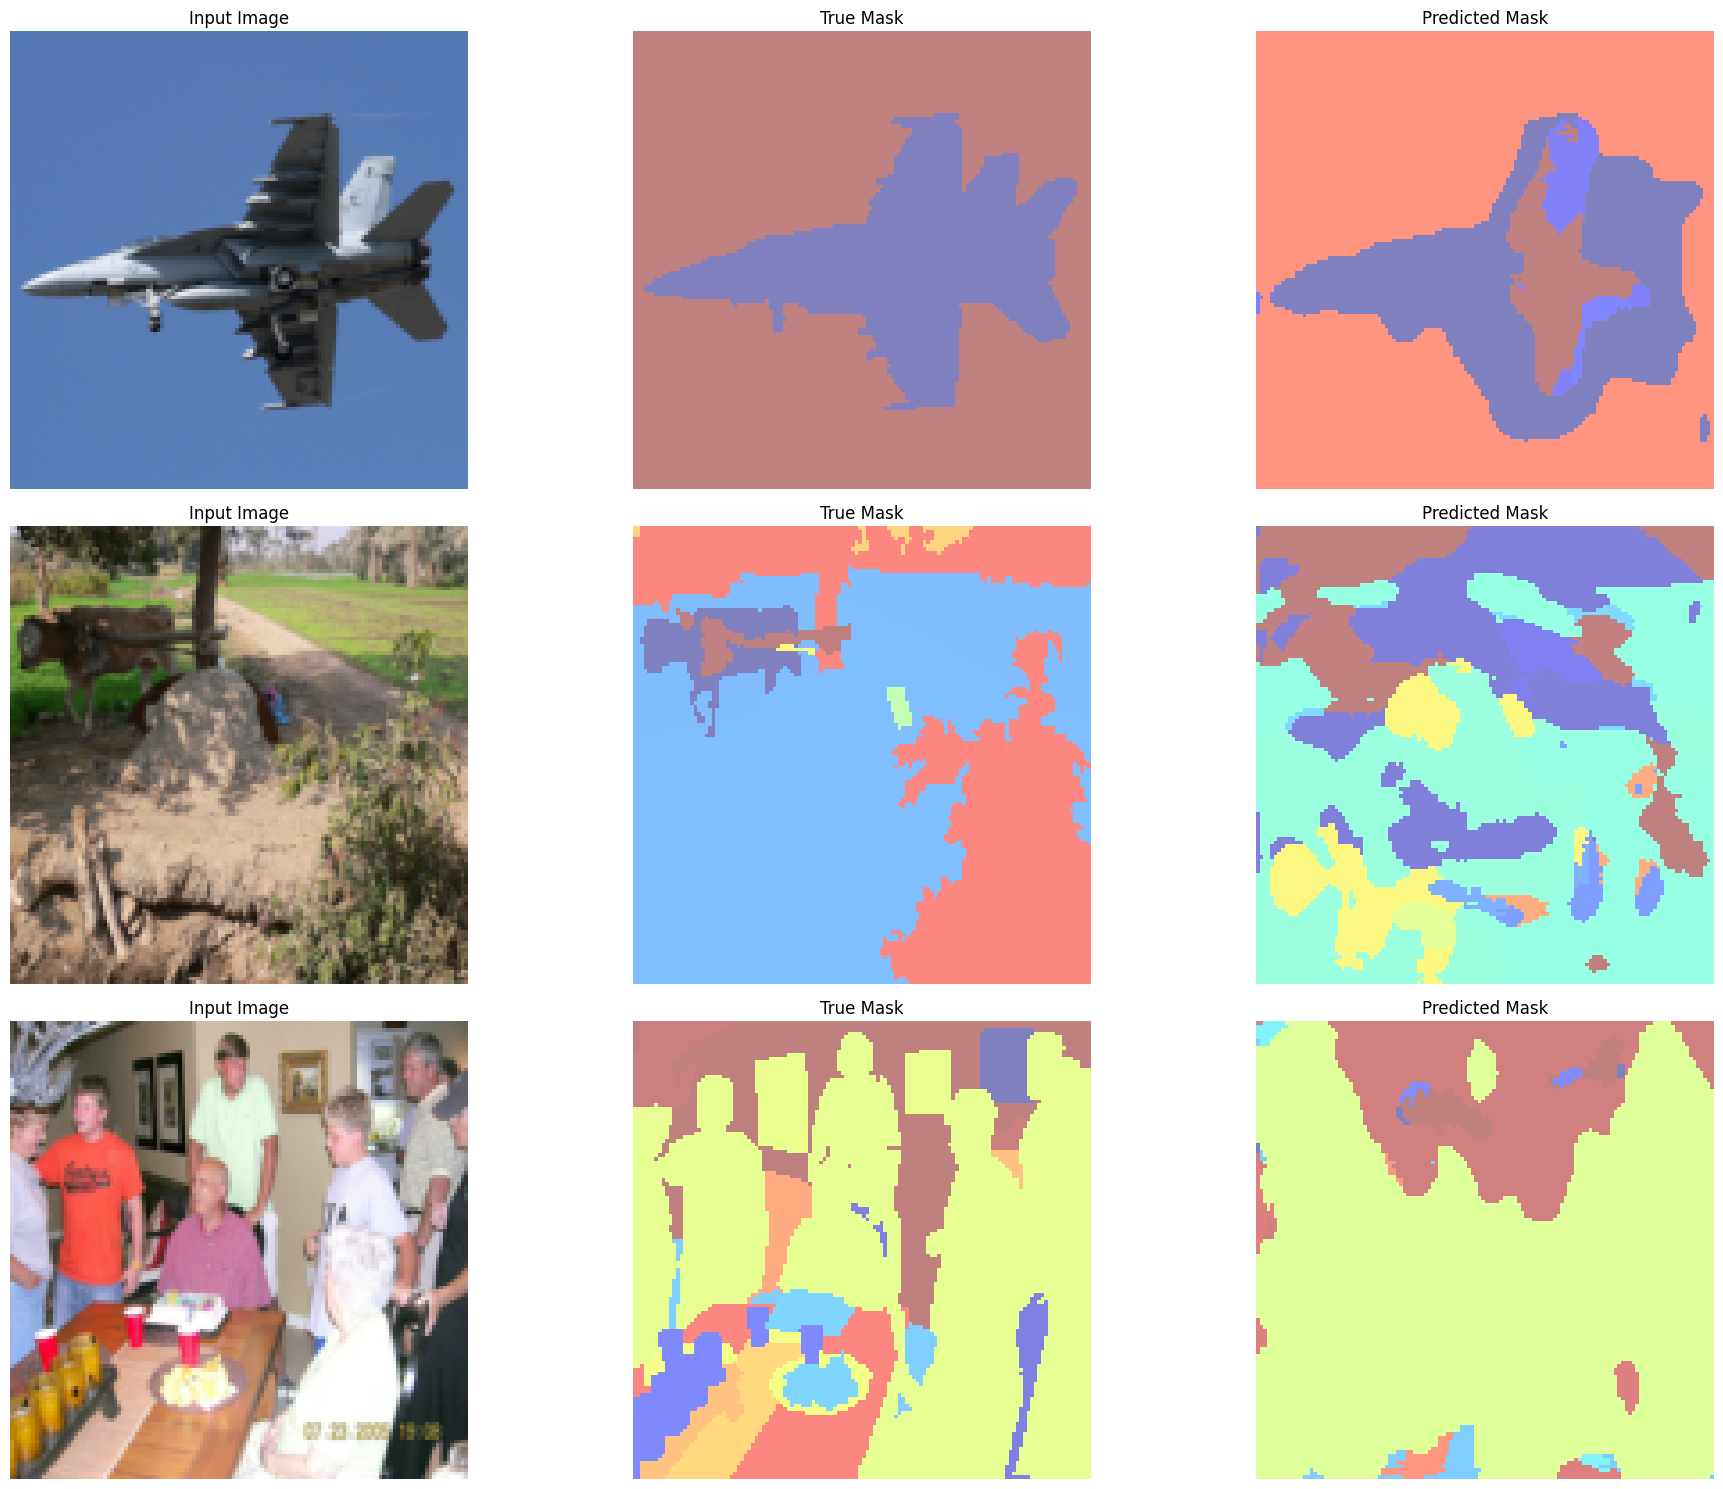

110/110 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.4364 - loss: 2.2029 - val_accuracy: 0.3305 - val_loss: 2.8821
Epoch 15/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4436 - loss: 2.1701
Epoch 15: saving model to unet_model_epoch_15_val_loss_3.4571.keras

Evaluating on test data at the end of epoch 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


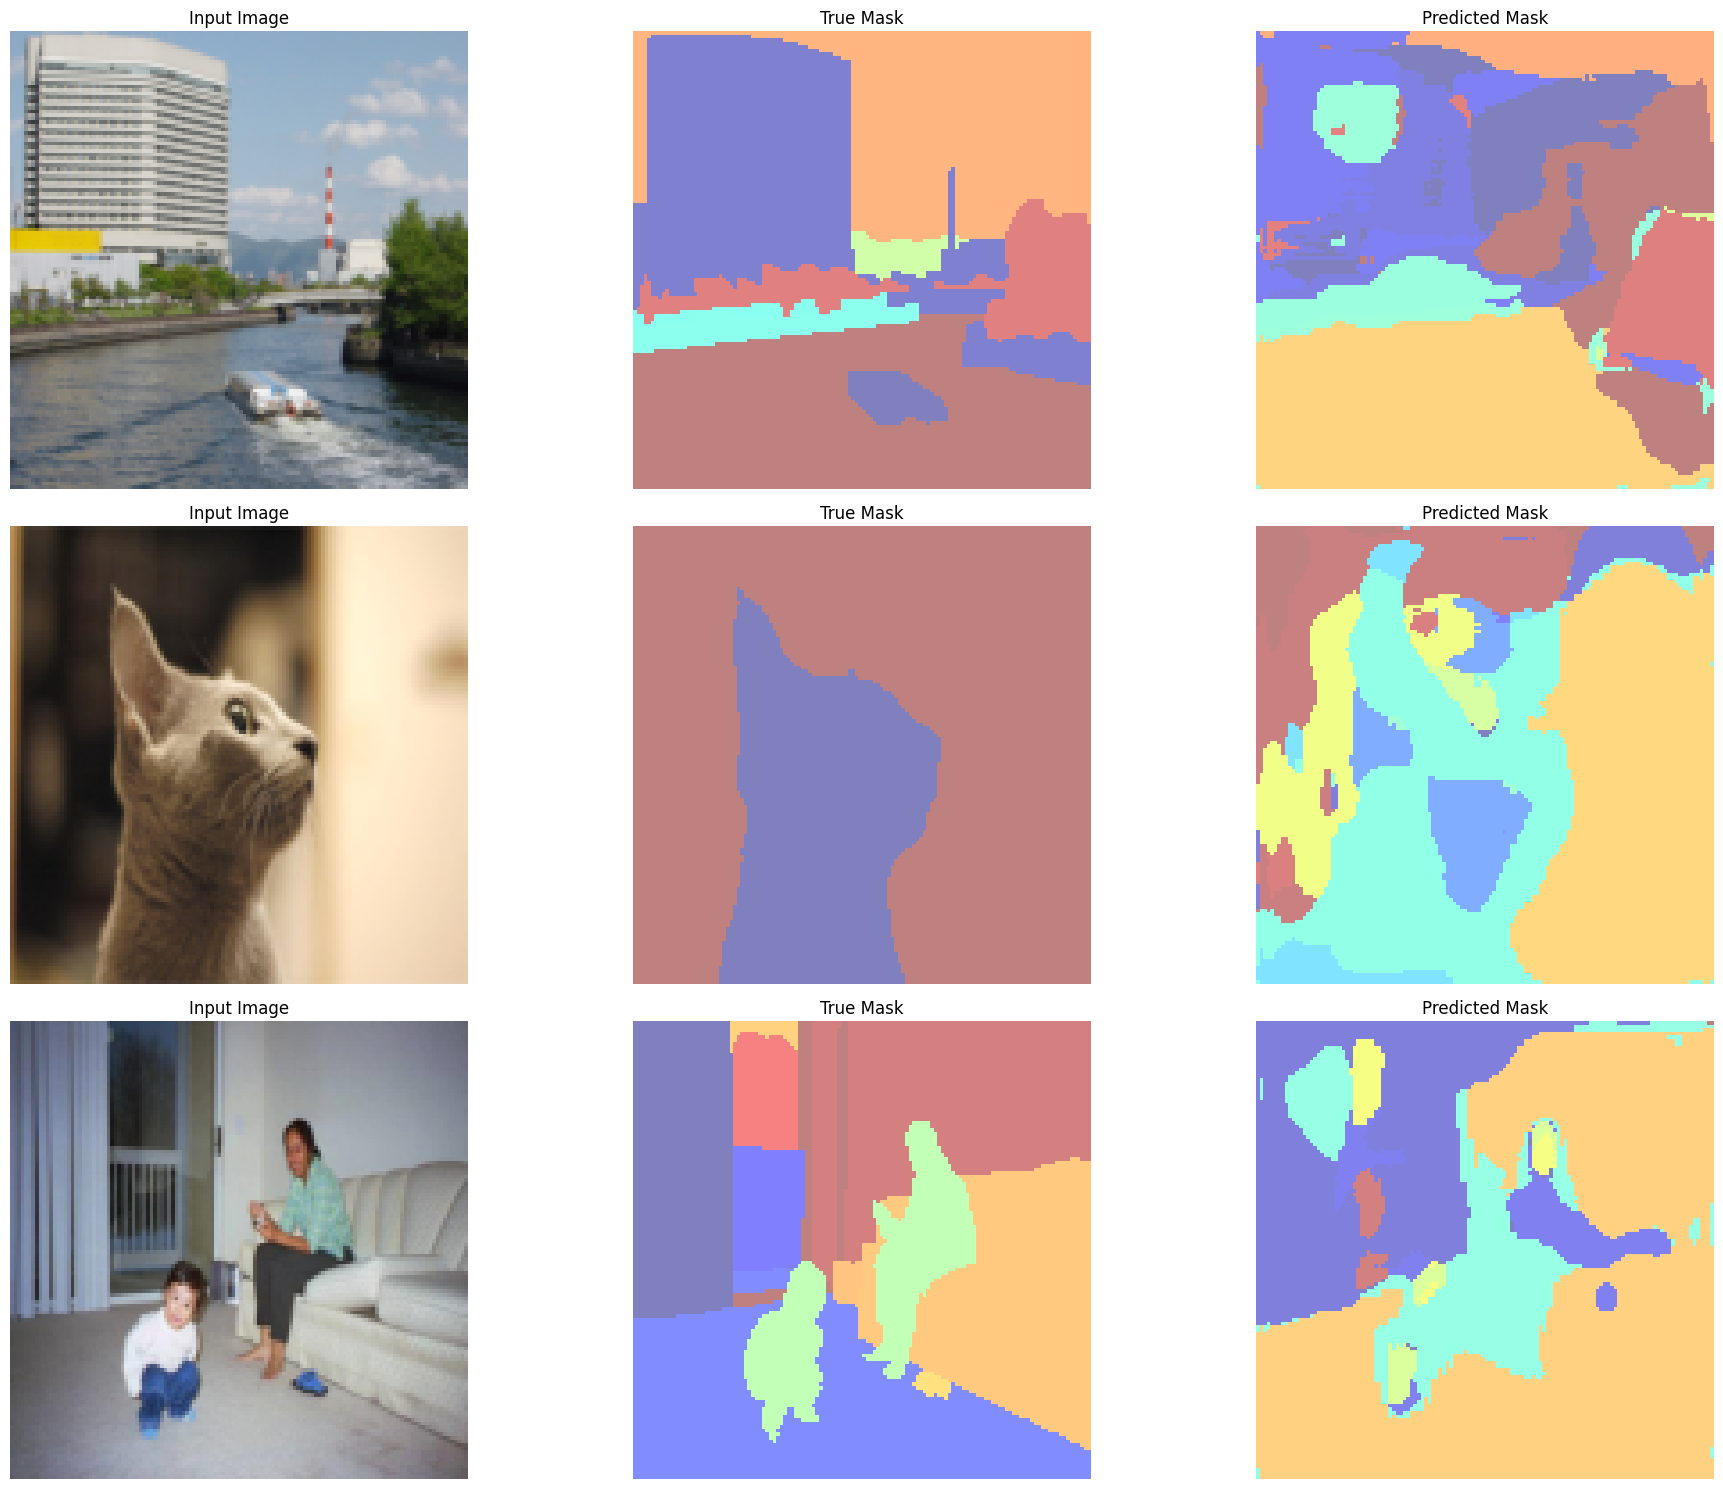

110/110 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.4436 - loss: 2.1703 - val_accuracy: 0.2594 - val_loss: 3.4571
Epoch 16/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4598 - loss: 2.1064
Epoch 16: saving model to unet_model_epoch_16_val_loss_2.7464.keras

Evaluating on test data at the end of epoch 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


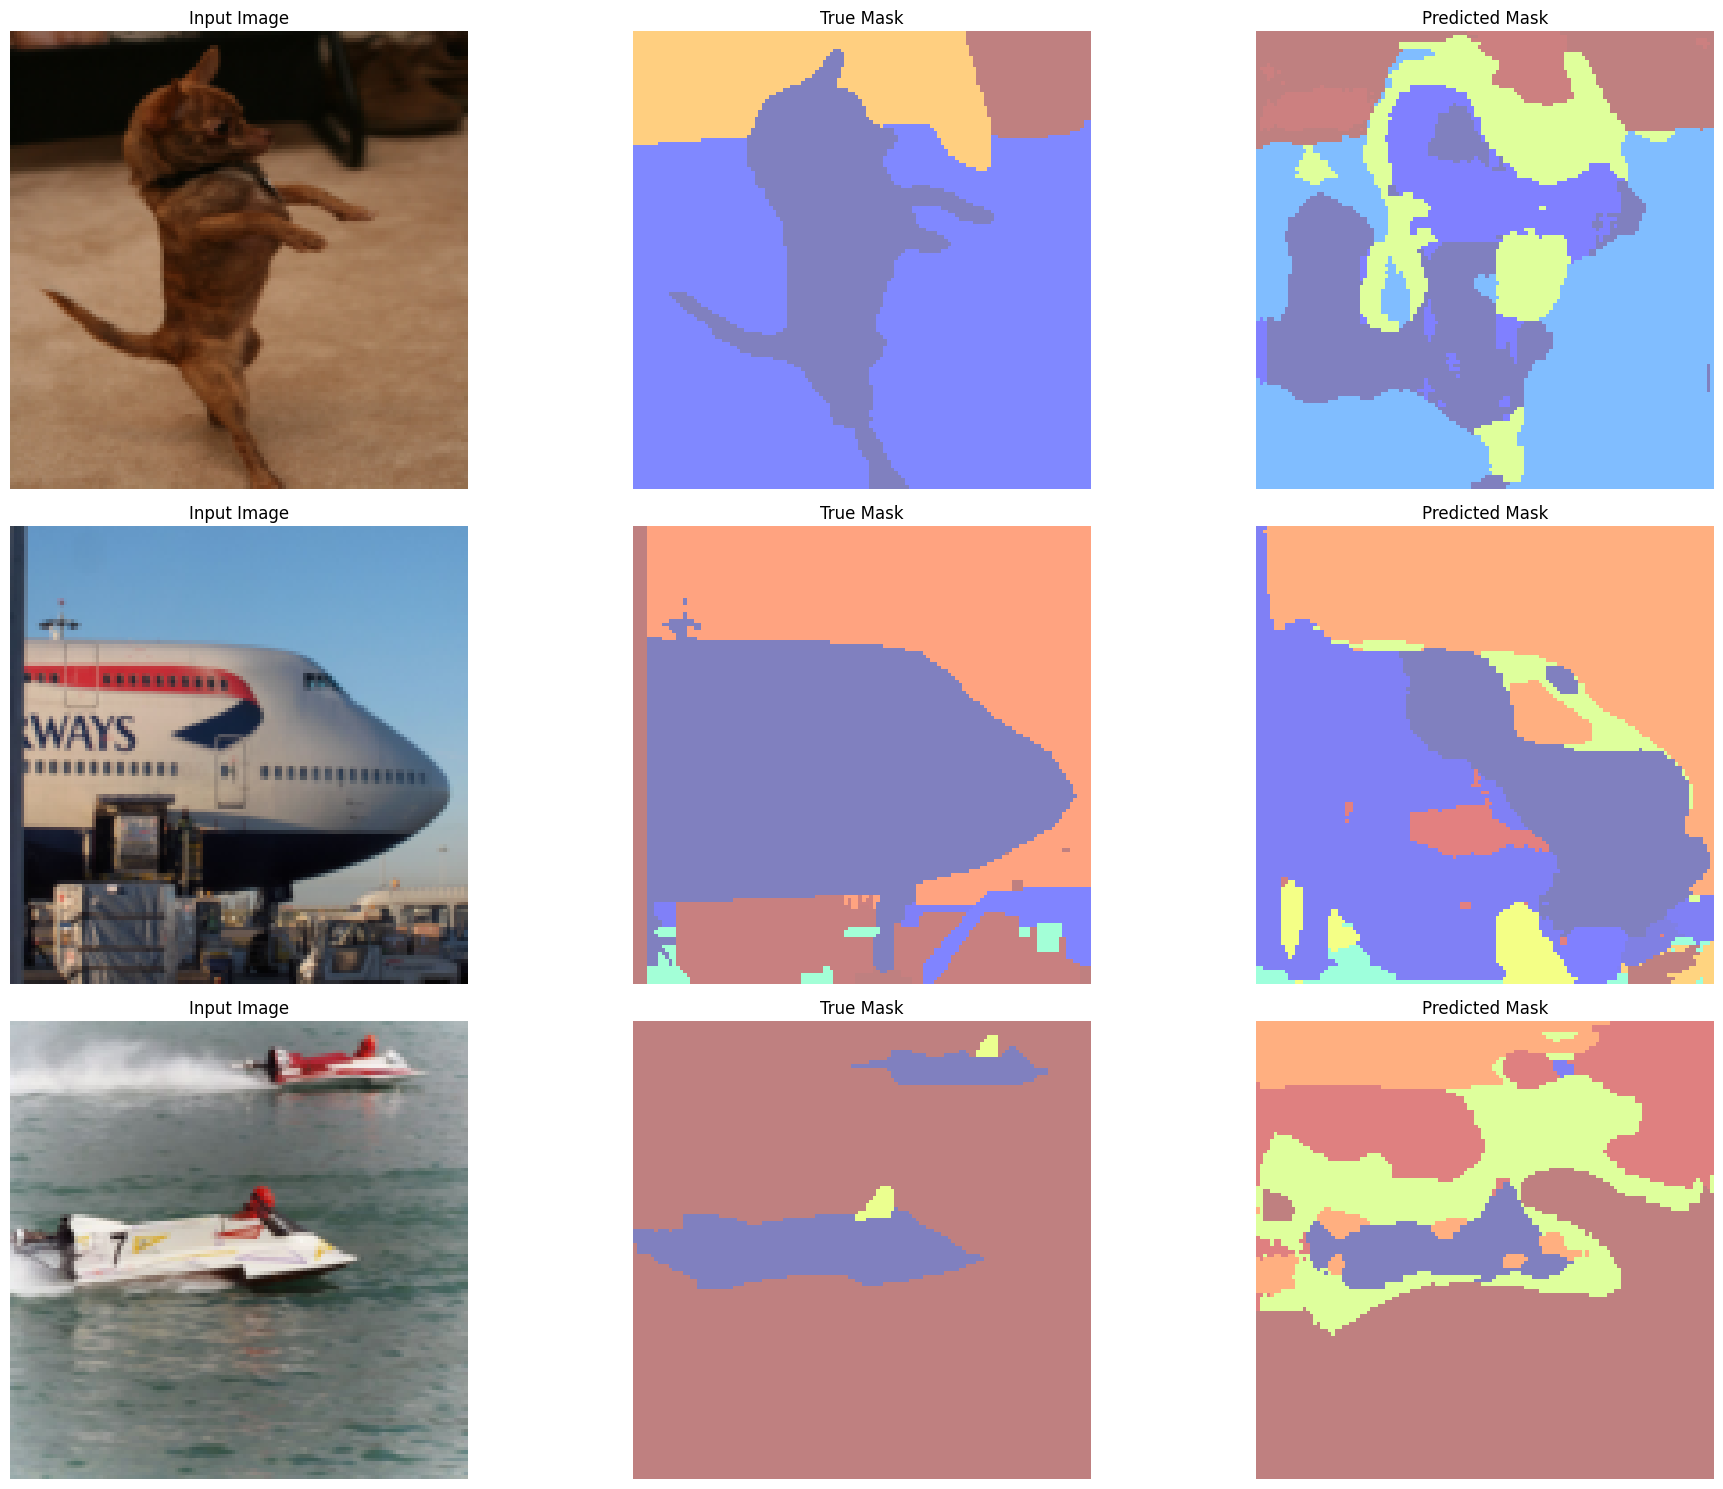

110/110 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.4597 - loss: 2.1067 - val_accuracy: 0.3665 - val_loss: 2.7464
Epoch 17/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4651 - loss: 2.0788
Epoch 17: saving model to unet_model_epoch_17_val_loss_3.1688.keras

Evaluating on test data at the end of epoch 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


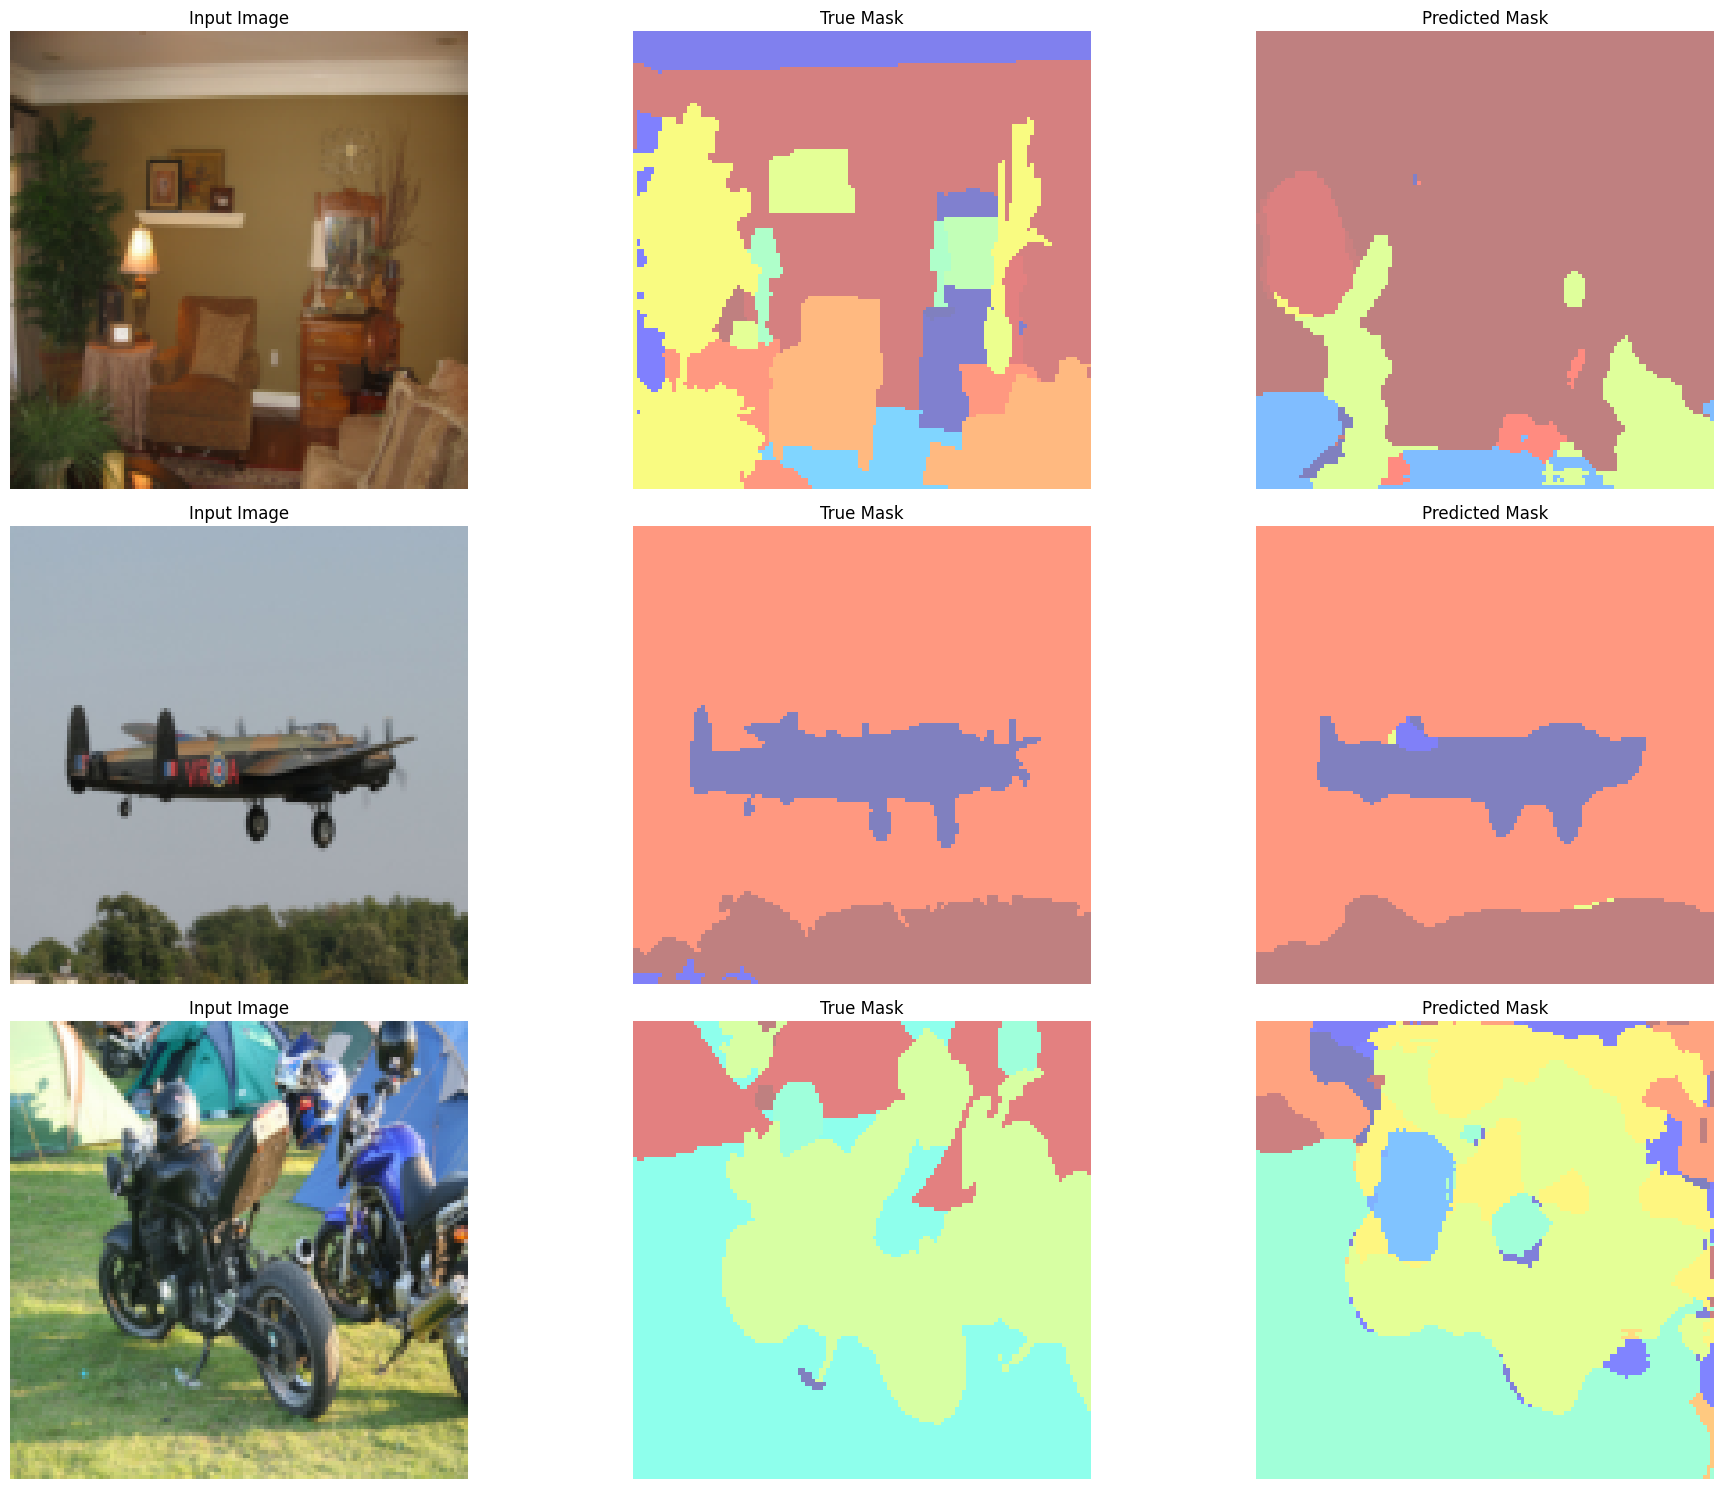

110/110 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.4650 - loss: 2.0793 - val_accuracy: 0.3073 - val_loss: 3.1688
Epoch 18/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4605 - loss: 2.0857
Epoch 18: saving model to unet_model_epoch_18_val_loss_2.6221.keras

Evaluating on test data at the end of epoch 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


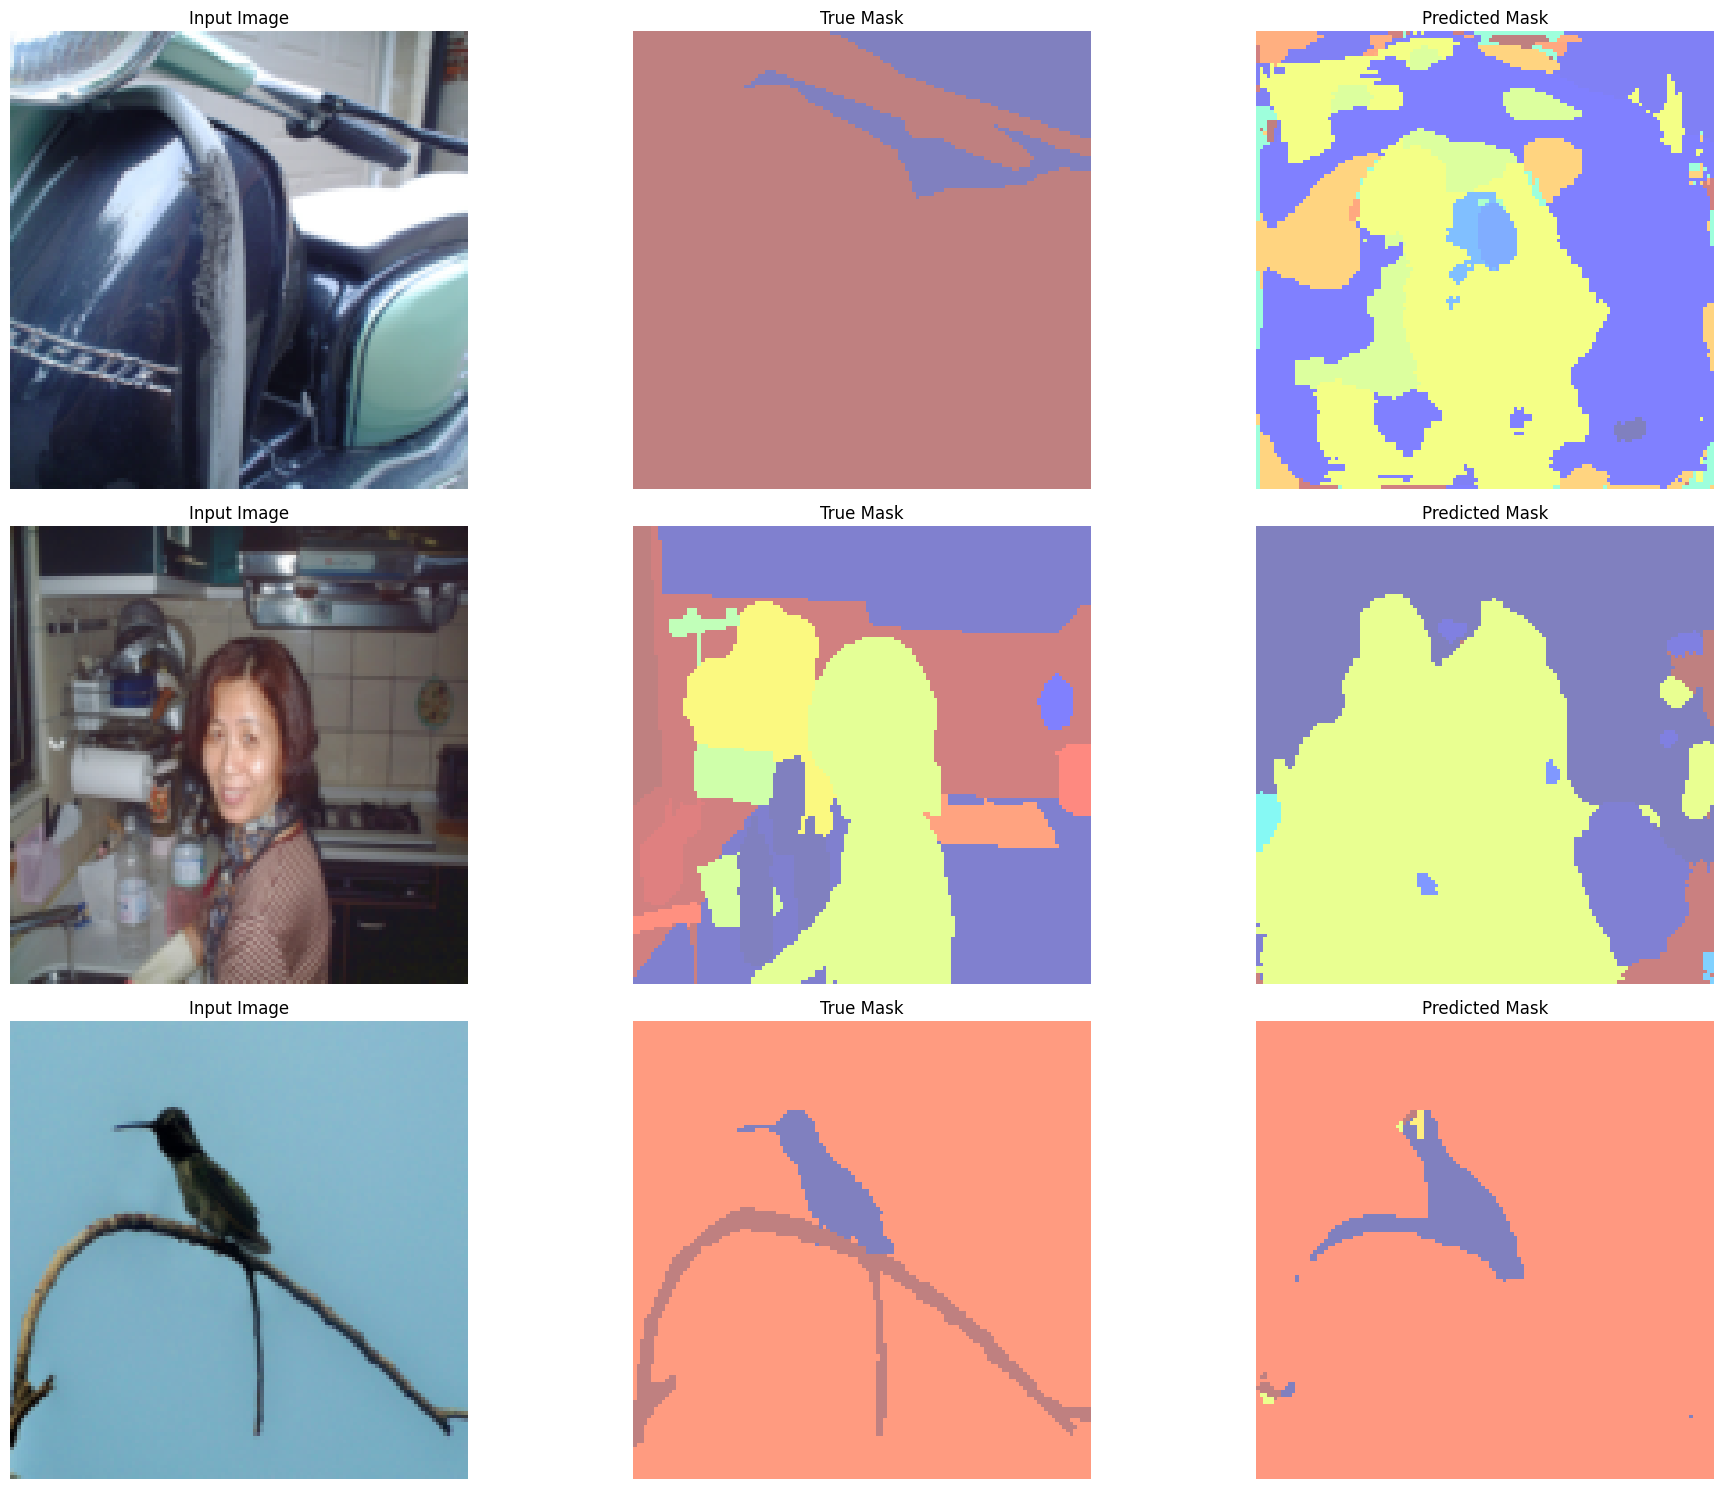

110/110 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.4604 - loss: 2.0859 - val_accuracy: 0.3889 - val_loss: 2.6221
Epoch 19/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4745 - loss: 2.0248
Epoch 19: saving model to unet_model_epoch_19_val_loss_2.5970.keras

Evaluating on test data at the end of epoch 19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


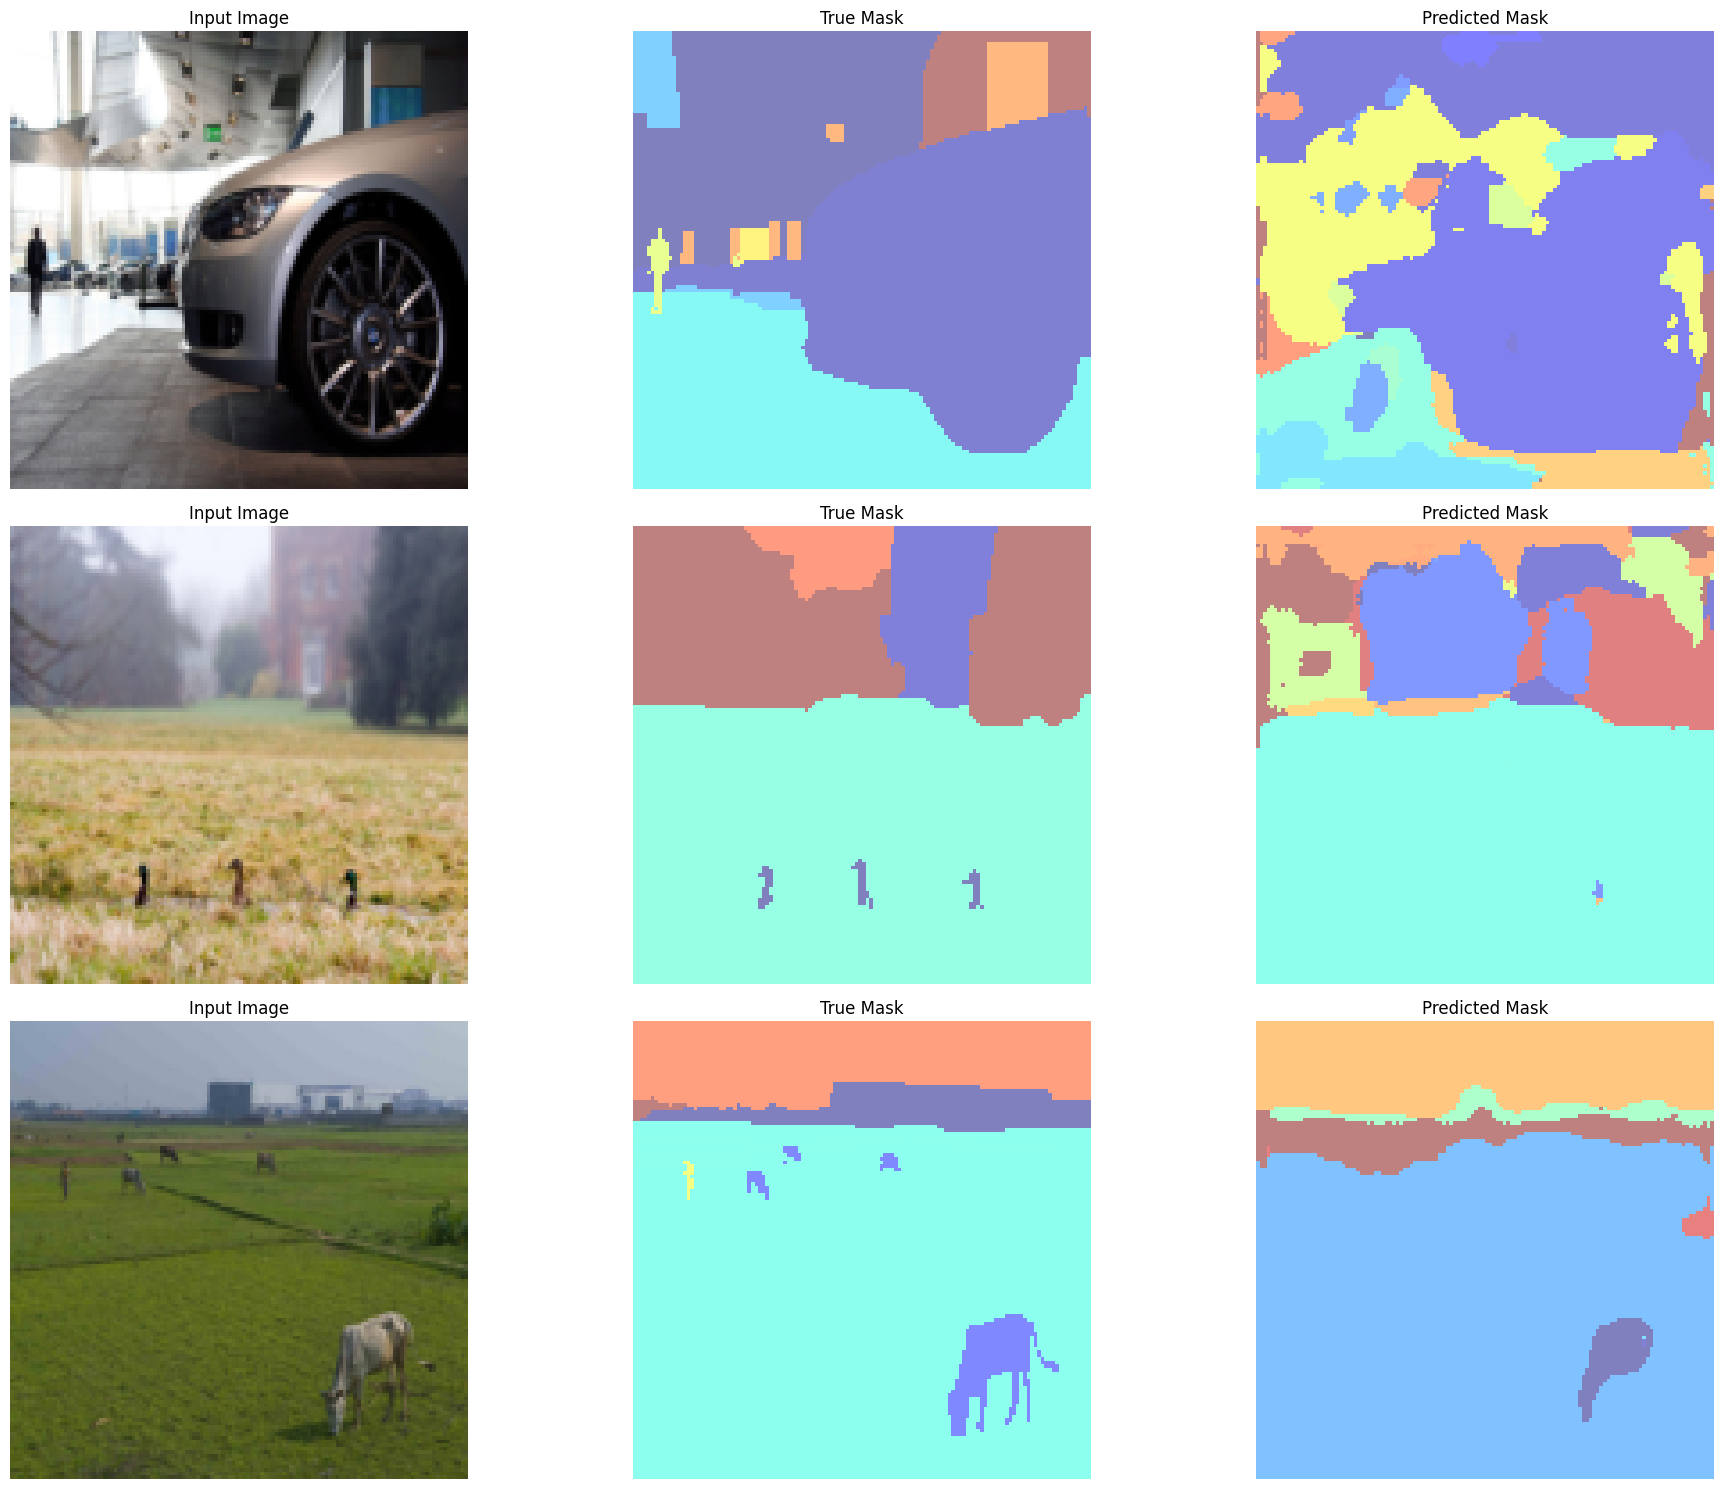

110/110 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.4744 - loss: 2.0250 - val_accuracy: 0.3818 - val_loss: 2.5970
Epoch 20/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4798 - loss: 1.9928
Epoch 20: saving model to unet_model_epoch_20_val_loss_2.6643.keras

Evaluating on test data at the end of epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


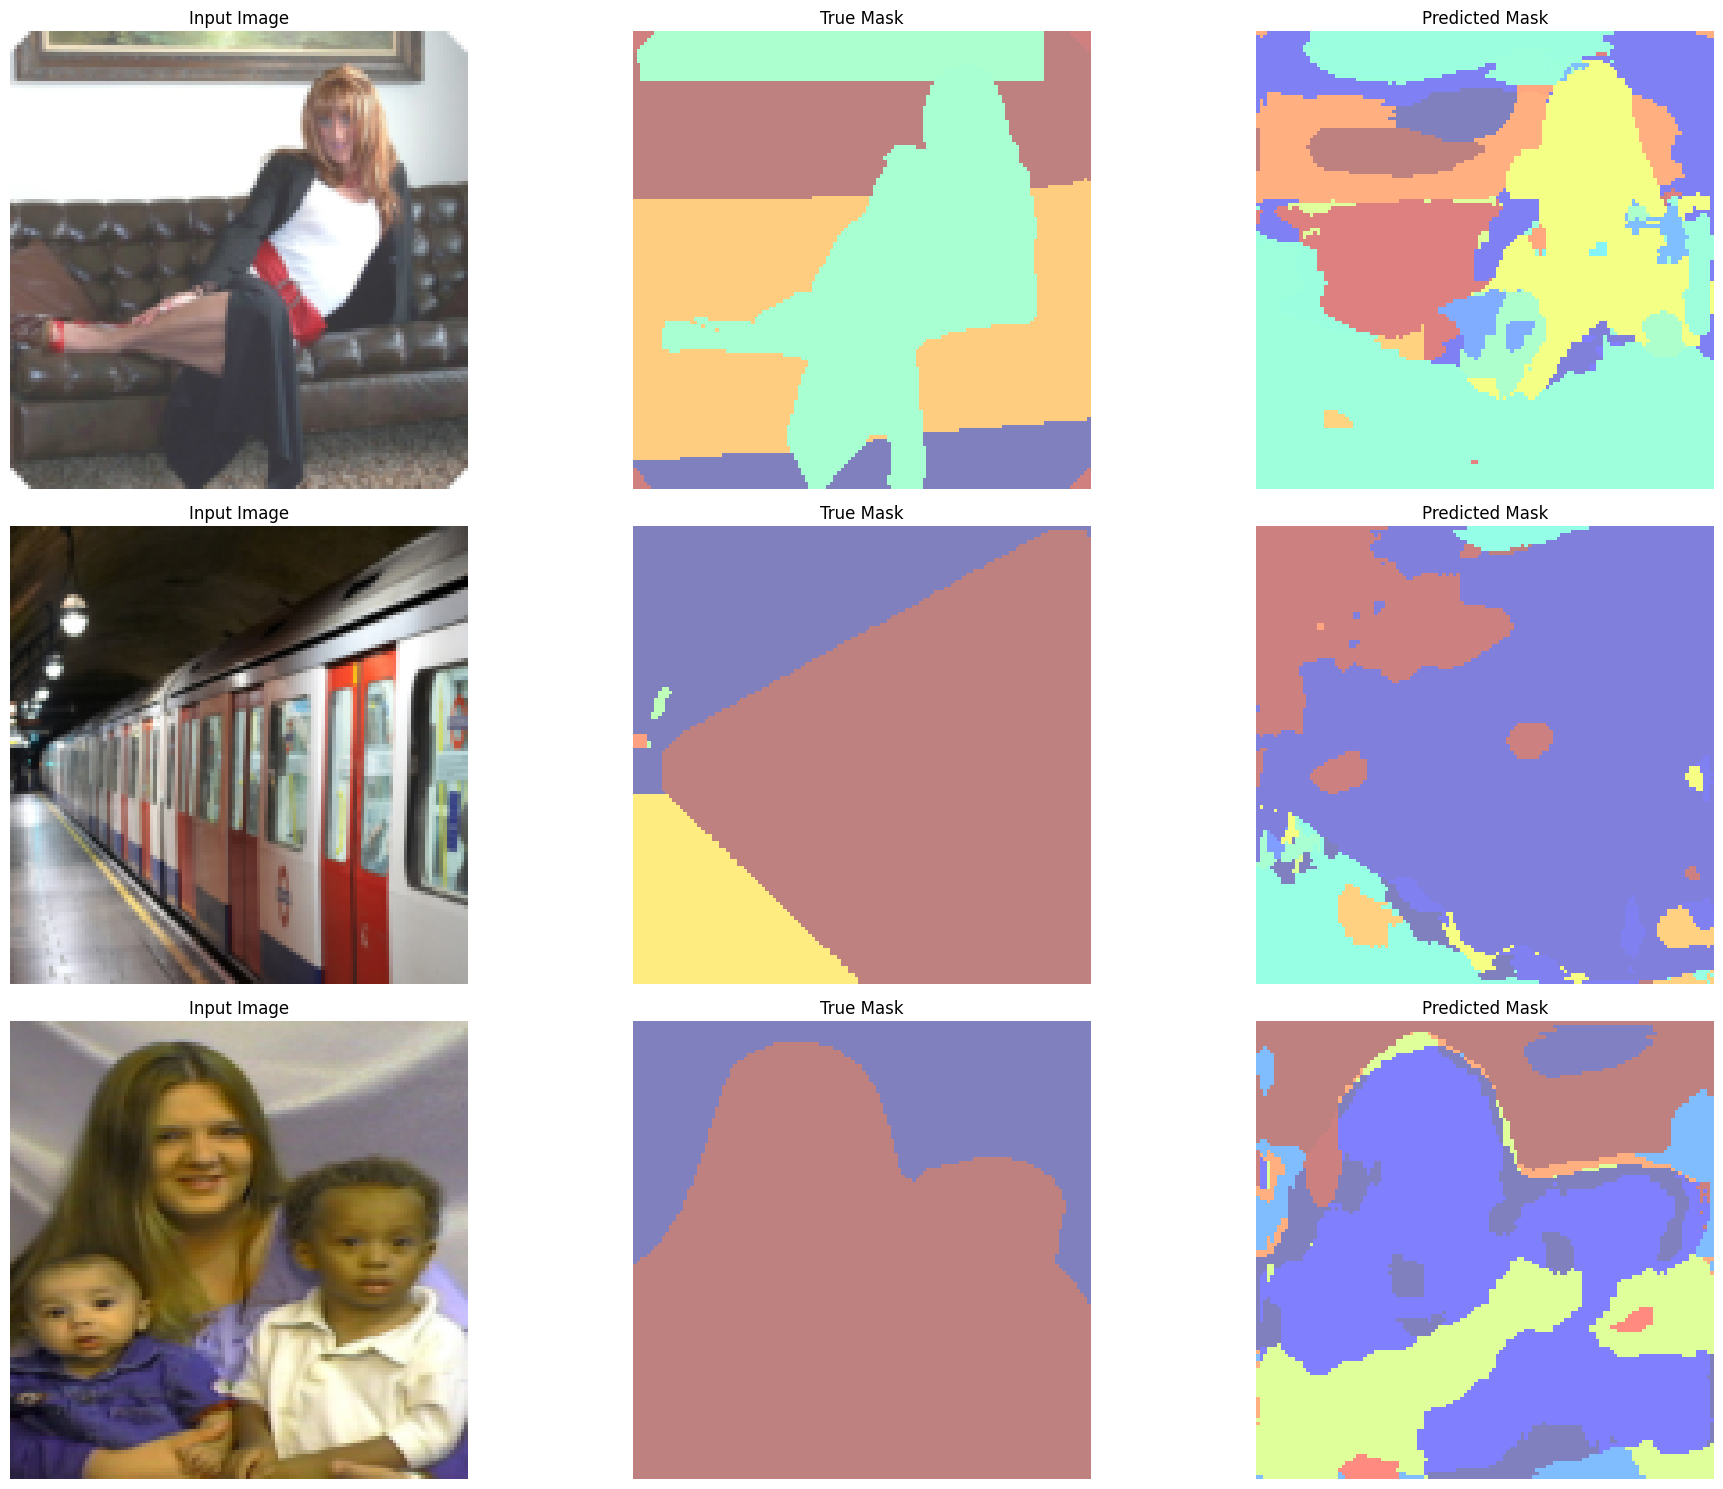

110/110 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.4797 - loss: 1.9929 - val_accuracy: 0.3747 - val_loss: 2.6643
Epoch 21/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4864 - loss: 1.9744
Epoch 21: saving model to unet_model_epoch_21_val_loss_2.5324.keras

Evaluating on test data at the end of epoch 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


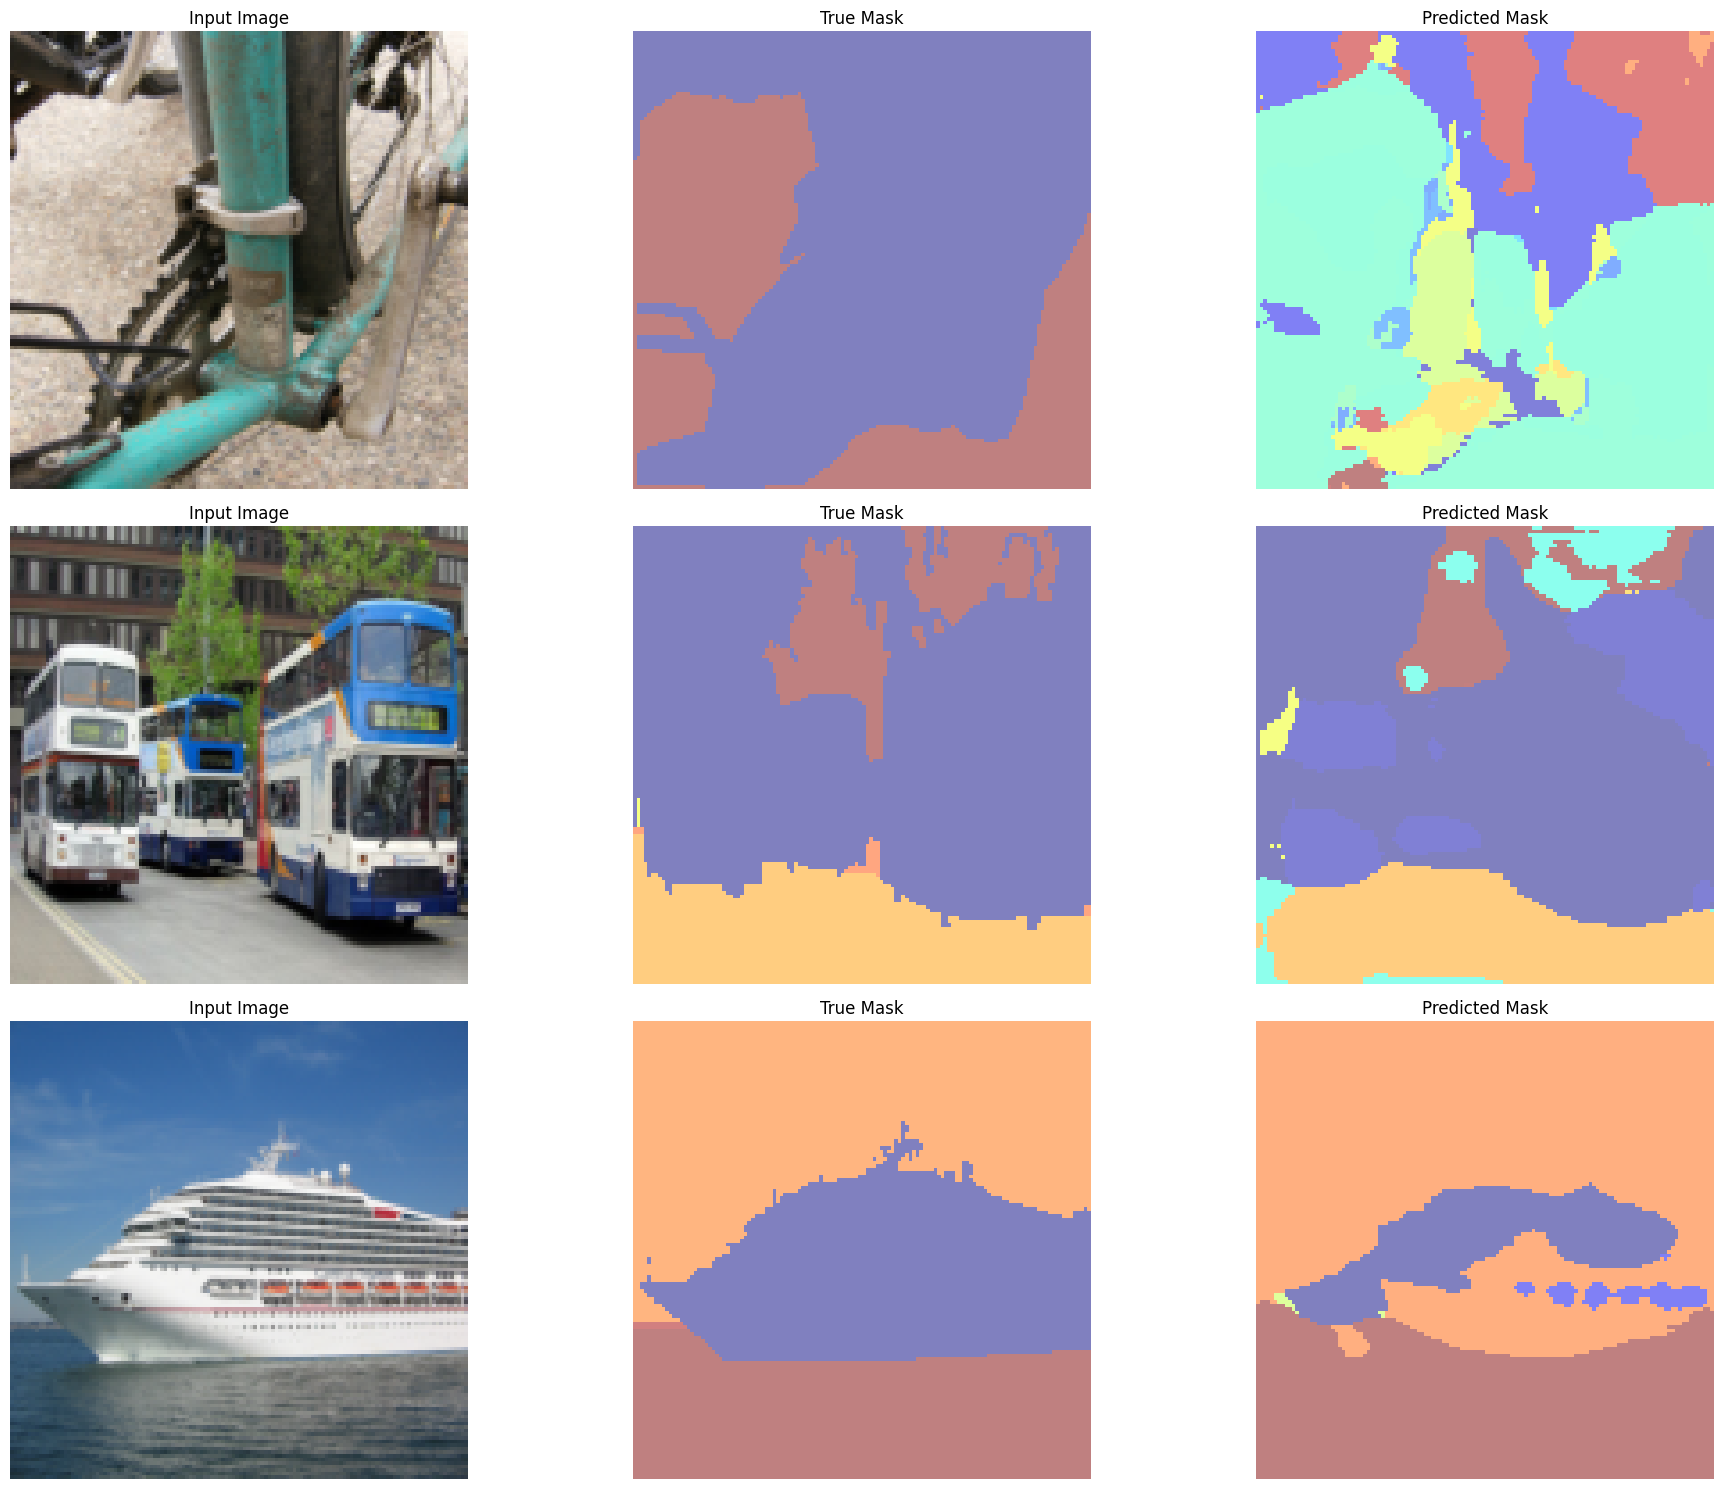

110/110 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.4863 - loss: 1.9746 - val_accuracy: 0.3949 - val_loss: 2.5324
Epoch 22/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4949 - loss: 1.9417
Epoch 22: saving model to unet_model_epoch_22_val_loss_2.8180.keras

Evaluating on test data at the end of epoch 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


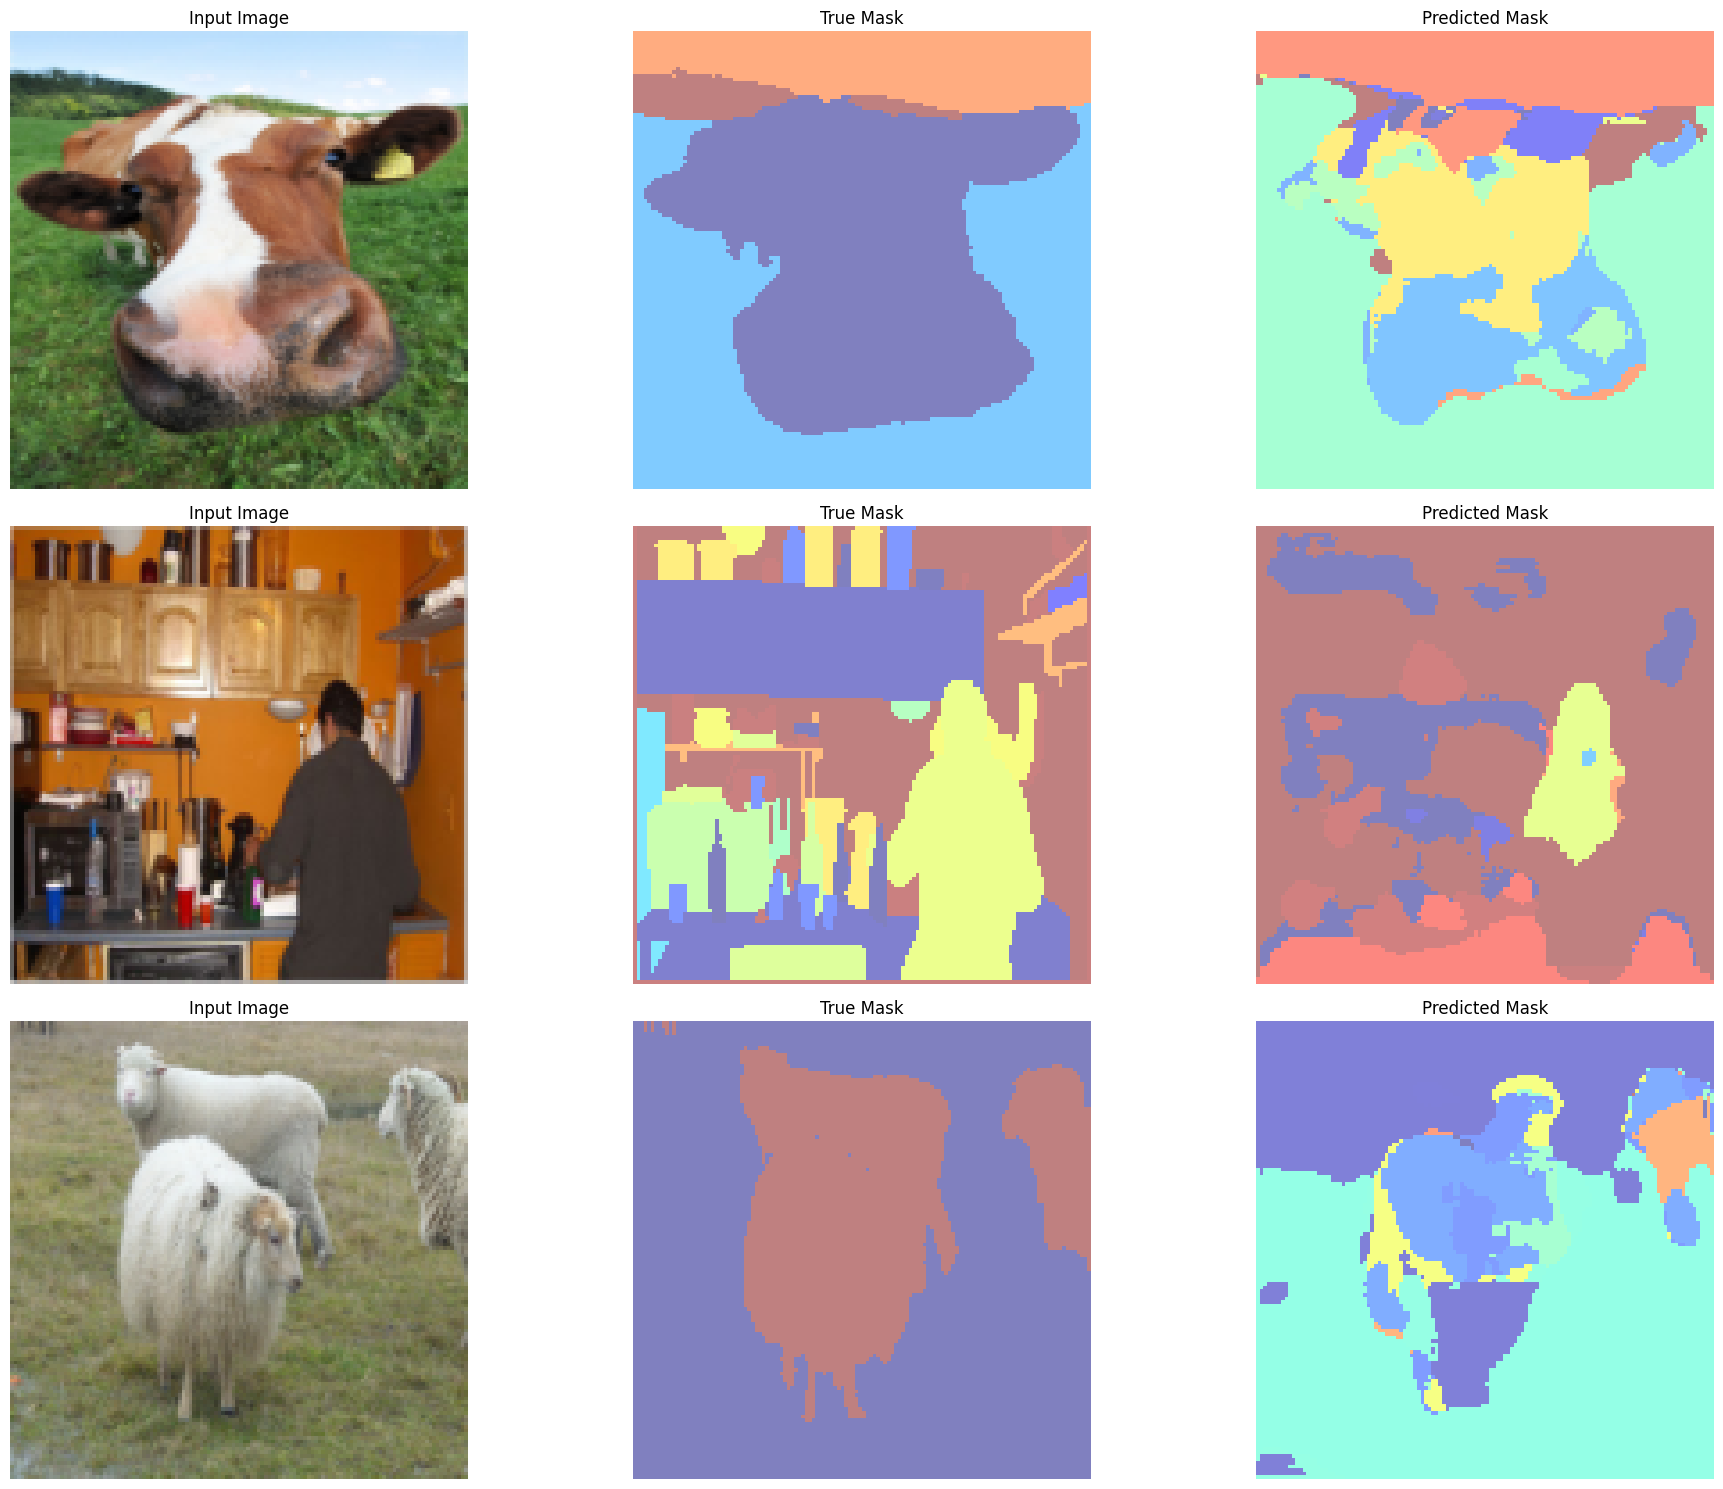

110/110 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.4948 - loss: 1.9418 - val_accuracy: 0.3442 - val_loss: 2.8180
Epoch 23/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4977 - loss: 1.9160
Epoch 23: saving model to unet_model_epoch_23_val_loss_2.9645.keras

Evaluating on test data at the end of epoch 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


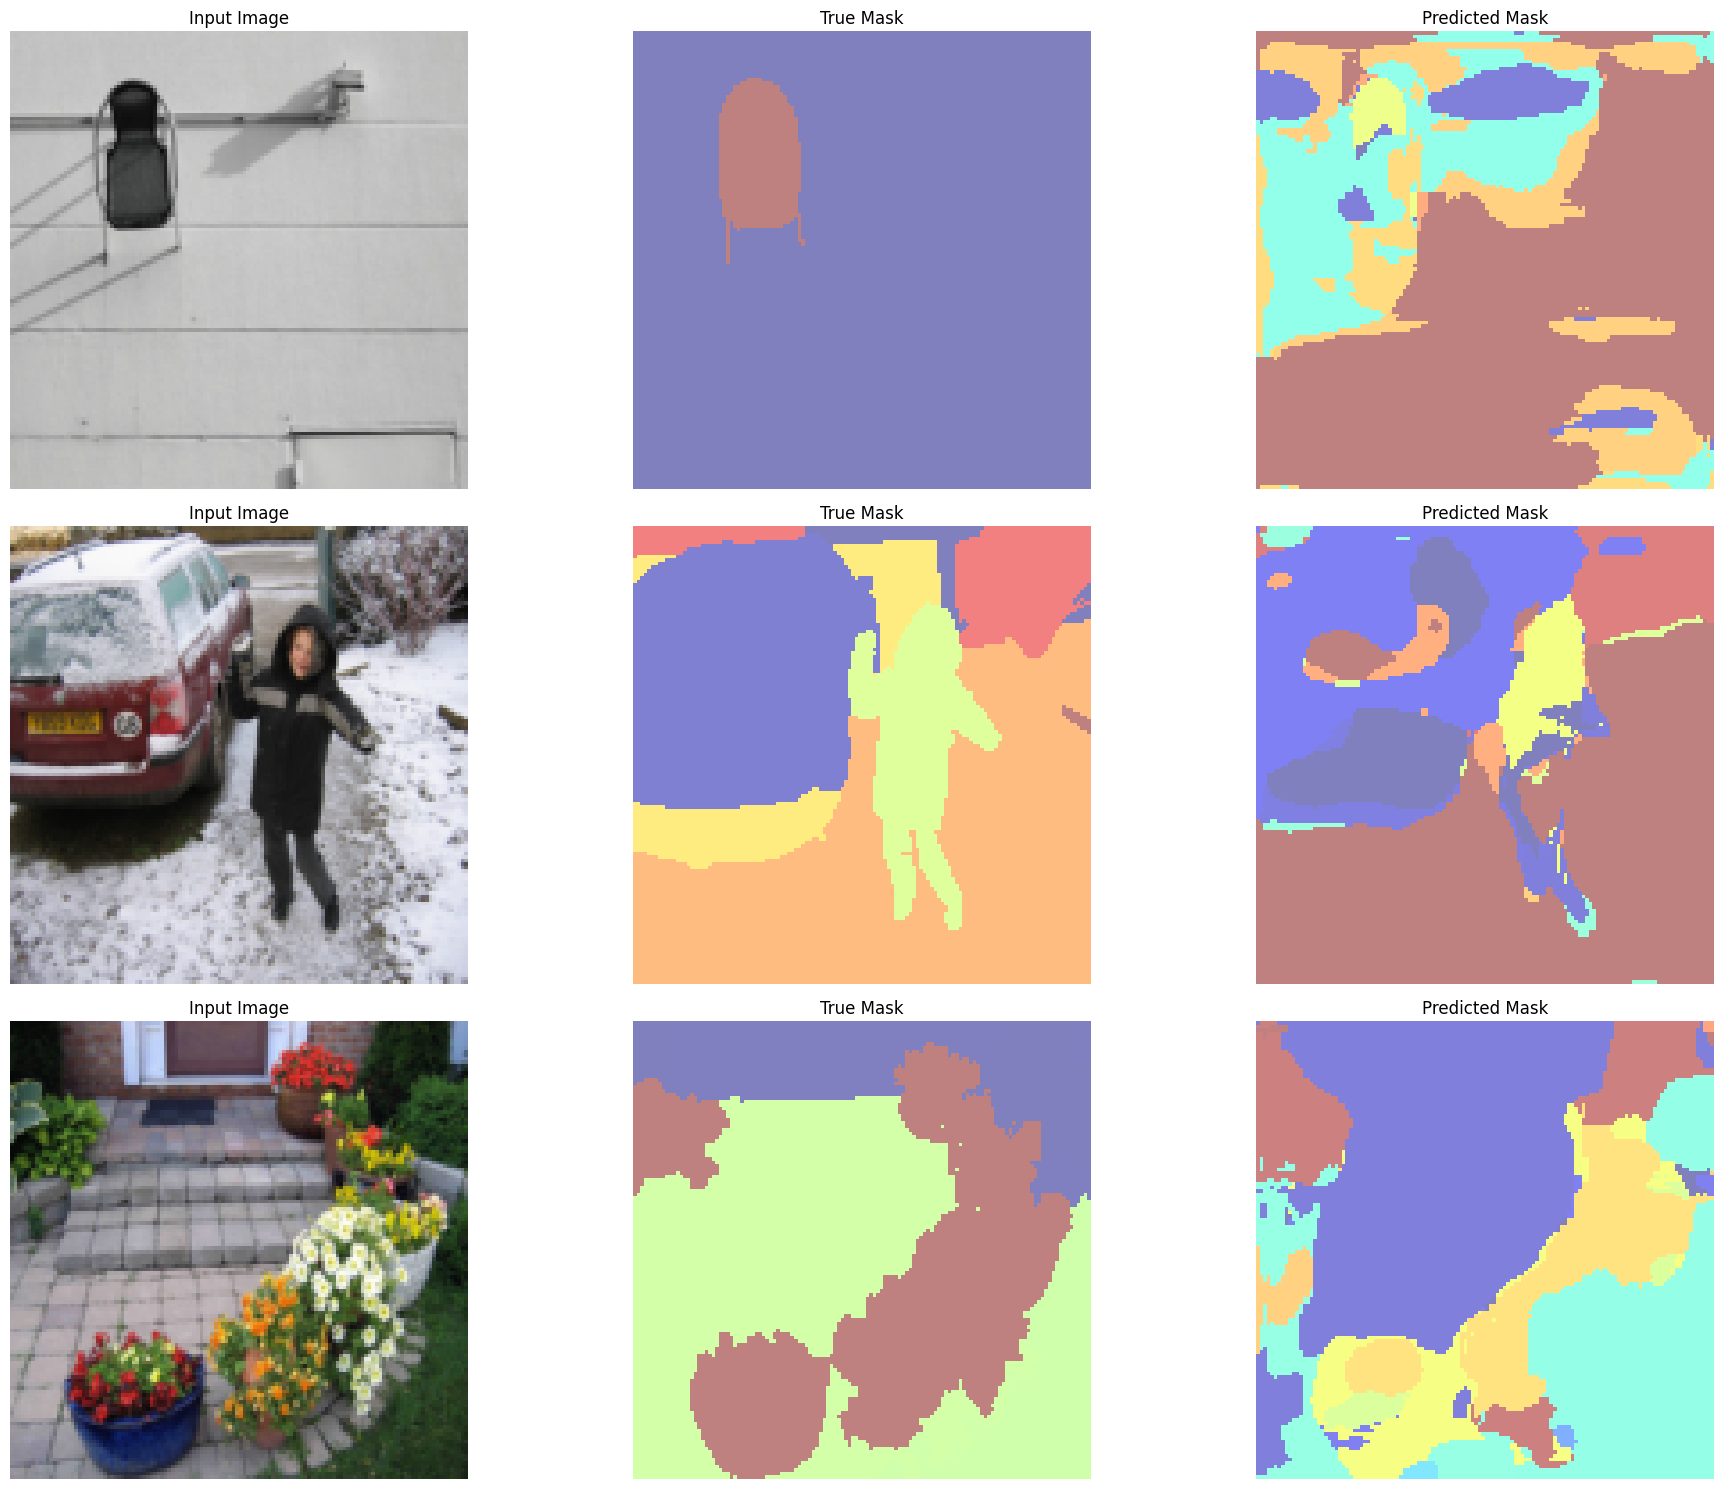

110/110 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.4976 - loss: 1.9161 - val_accuracy: 0.3560 - val_loss: 2.9645
Epoch 24/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5070 - loss: 1.8772
Epoch 24: saving model to unet_model_epoch_24_val_loss_3.0289.keras

Evaluating on test data at the end of epoch 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


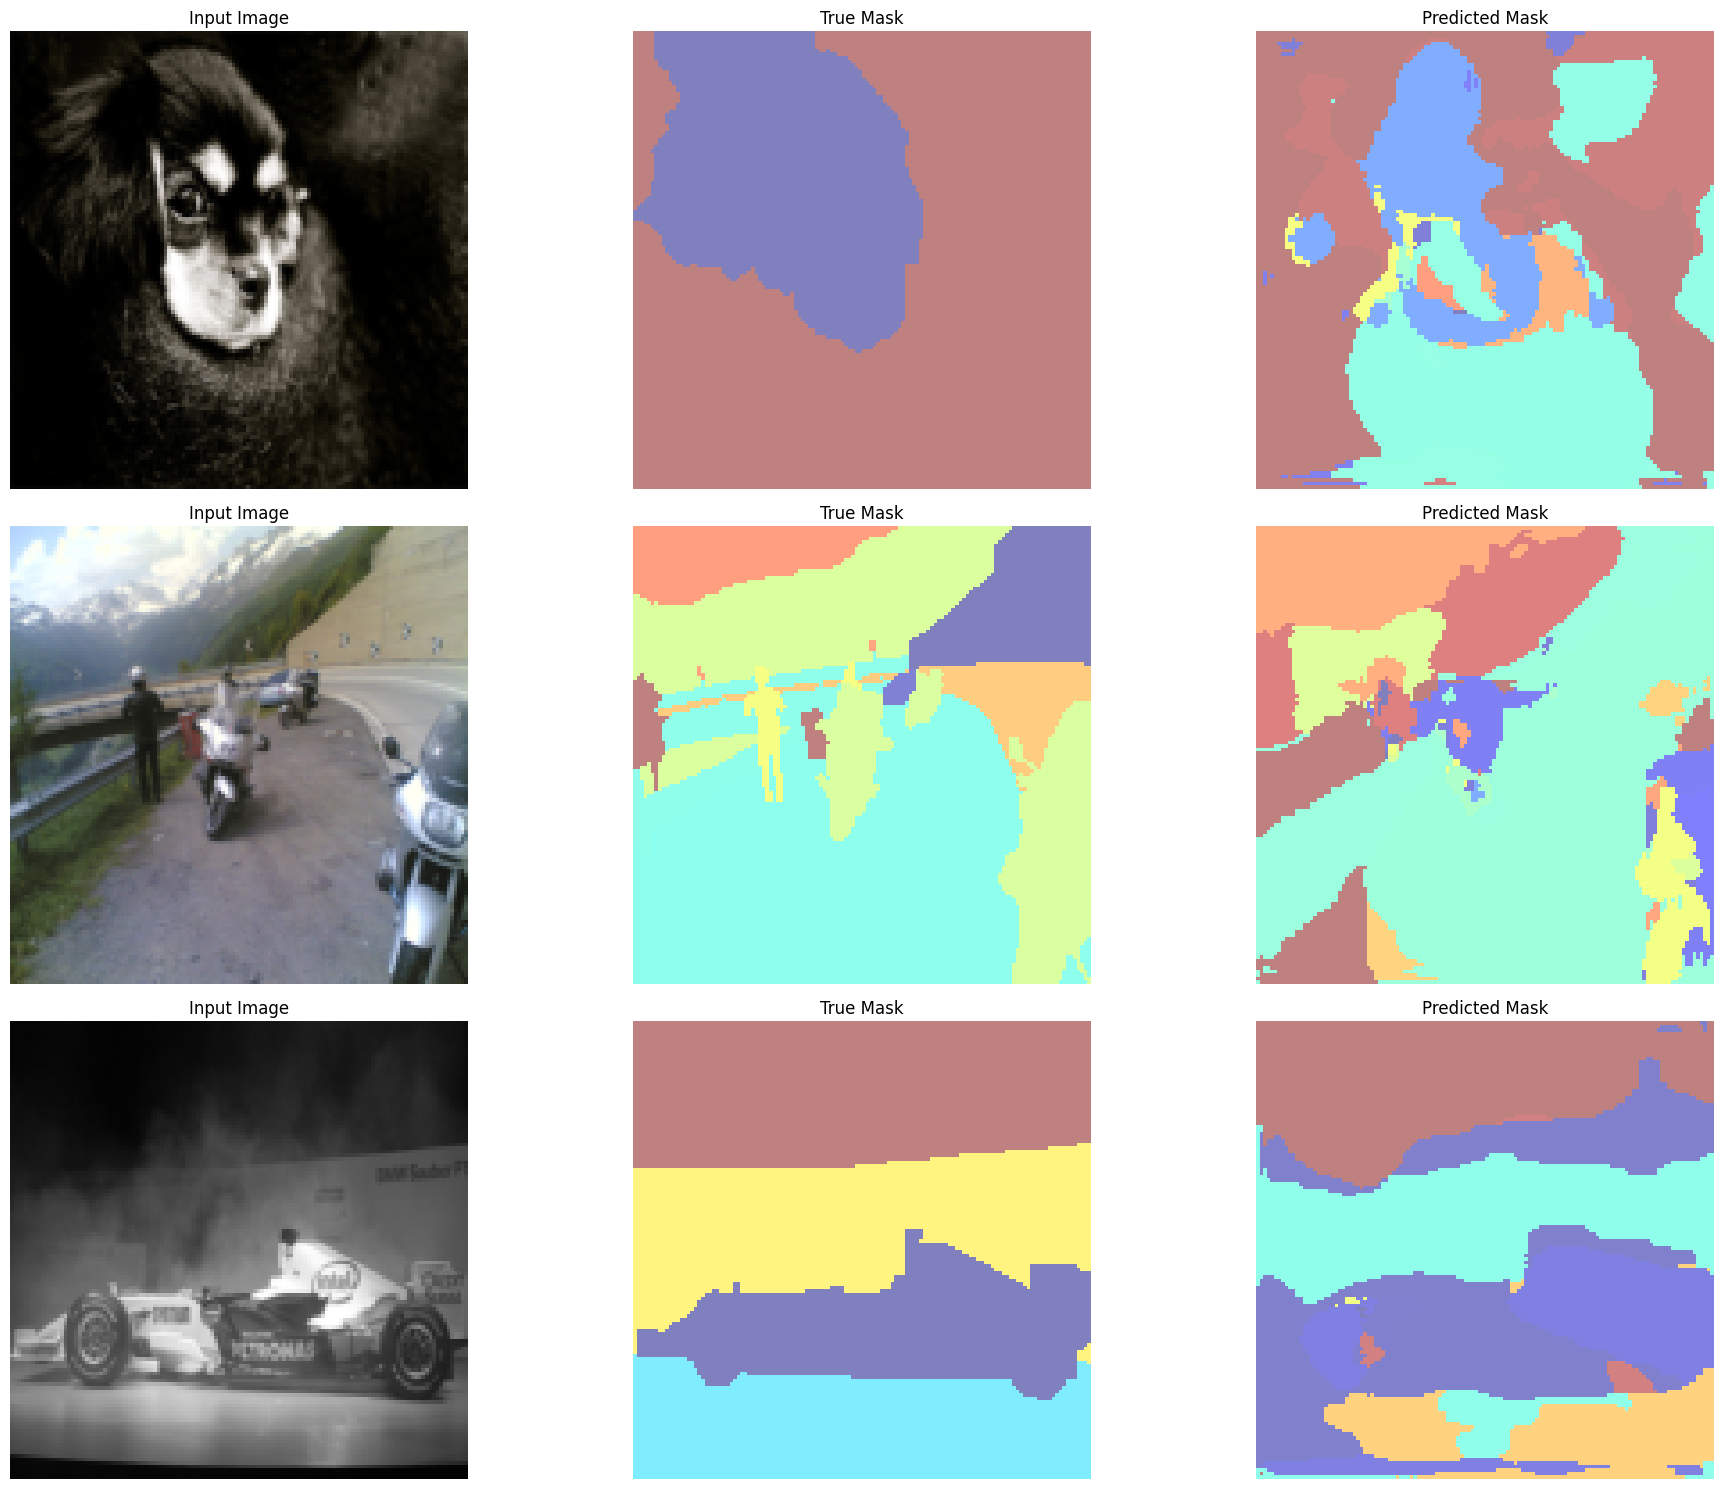

110/110 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.5070 - loss: 1.8773 - val_accuracy: 0.3433 - val_loss: 3.0289
Epoch 25/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5154 - loss: 1.8381
Epoch 25: saving model to unet_model_epoch_25_val_loss_3.0995.keras

Evaluating on test data at the end of epoch 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


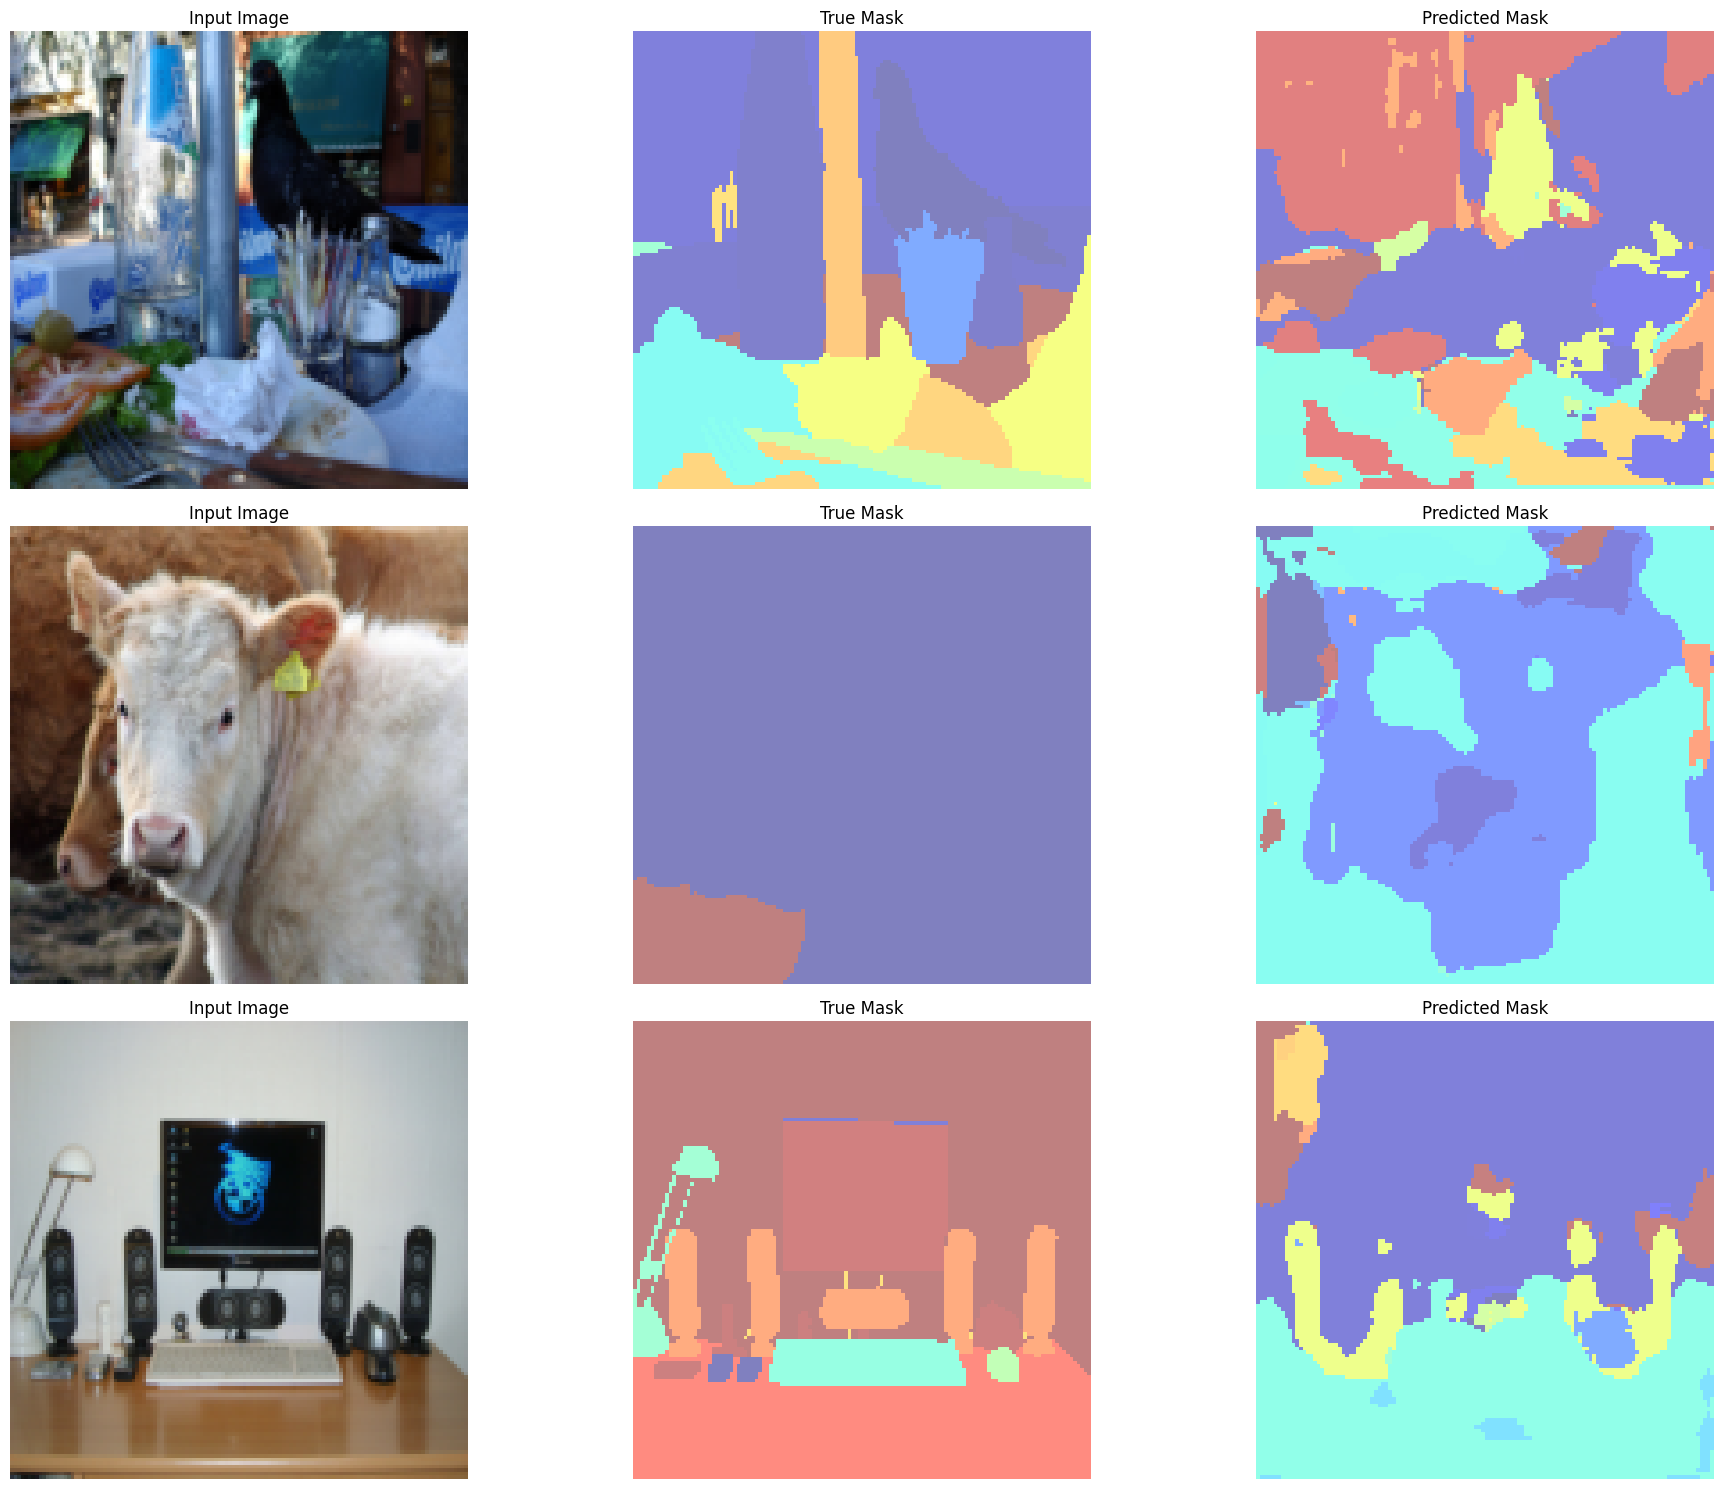

110/110 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.5154 - loss: 1.8382 - val_accuracy: 0.3255 - val_loss: 3.0995


In [21]:
# Train the model with both callbacks
model.fit(
    train_gen,
    steps_per_epoch=len(train_image_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_image_paths) // batch_size,
    epochs=25,
    callbacks=[checkpoint_callback, test_callback]  # Add both the checkpoint and test callbacks here
)

## Save The model into Drive

In [22]:
drive_dir = 'drive/MyDrive/UNET/'
model.save(drive_dir + 'UNet_Image_Segmentation_method2.keras')

## Model link
You can access to the model: [Link](https://drive.google.com/file/d/1n6uZ-QnNgdzmKPwgWhi5ydjYQyWDGI0M/view?usp=sharing)

## Load the saved model

In [ ]:
model = load_model(drive_dir + 'UNet_Image_Segmentation_method2.keras')

## Define IoU calculation function

In [23]:
# Define IoU calculation function
def mean_iou(y_true, y_pred, num_classes):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    ious = []
    for c in range(num_classes):
        true_class = (y_true == c)
        pred_class = (y_pred == c)

        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in mean IoU
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)  # Compute mean IoU ignoring NaN values

# Function to evaluate mean IoU on test data
def evaluate_mean_iou(model, test_gen, num_steps, num_classes):
    ious = []

    for _ in range(num_steps):
        test_images, test_masks = next(test_gen)
        predicted_masks = model.predict(test_images)

        for true_mask, pred_mask in zip(test_masks, predicted_masks):
            iou = mean_iou(true_mask, pred_mask, num_classes)
            ious.append(iou)

    return np.nanmean(ious)


In [24]:
# Evaluate mean IoU on the test set
num_test_steps = len(test_image_paths) // batch_size
mean_iou_score = evaluate_mean_iou(model, test_gen, num_test_steps, num_classes)
print(f"Mean IoU on test data: {mean_iou_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mean IoU on test data: 0.0721
